In [1]:
from matplotlib import pyplot as plt, style, ticker
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from datetime import datetime, timedelta
import pandas as pd
from lxml import html, etree, objectify
from collections import defaultdict
import requests
import csv
import re

style.use('ggplot')

In [2]:
# getting html tree from the url
domen = "https://www.sec.gov"
start_url = "/cgi-bin/browse-edgar?action=getcompany&CIK=0001656456&owner=exclude&count=40&hidefilings=0"
page = requests.get(domen + start_url)
tree = html.fromstring(page.content)
table = tree.find('.//div[@id="seriesDiv"]')

detail_page_links = []
for row in table.findall('.//tr'):
    link_cell, title_cell = row[1:3]
    if link_cell.tag == "td":  # not a header element th
        if title_cell.text is not None and title_cell.text.startswith("Quarterly report"):
            detail_page_links.append(link_cell[0].get('href'))

detail_page_links

['/Archives/edgar/data/1656456/000165645617000004/0001656456-17-000004-index.htm',
 '/Archives/edgar/data/1656456/000165645617000003/0001656456-17-000003-index.htm',
 '/Archives/edgar/data/1656456/000165645617000002/0001656456-17-000002-index.htm',
 '/Archives/edgar/data/1656456/000165645616000010/0001656456-16-000010-index.htm',
 '/Archives/edgar/data/1656456/000165645616000008/0001656456-16-000008-index.htm',
 '/Archives/edgar/data/1656456/000165645616000007/0001656456-16-000007-index.htm']

In [3]:
detail_page_links = detail_page_links[:4]  # we get only 4 latest reports

file_links = []
for detail_url in detail_page_links:
    page = requests.get(domen + detail_url)
    tree = html.fromstring(page.content)
    table = tree.find('.//table[@class="tableFile"]')
    
    for row in table.findall('.//tr'):
        doc_cell, type_cell = row[2:4]
        
        if type_cell.text == "INFORMATION TABLE":
            link = doc_cell[0]            
            if link.text.endswith(".xml"):
                file_link = doc_cell[0].get("href")
                
                period_header = tree.xpath('.//div[text()="Period of Report"]')[0]
                period_container = period_header.getnext()
                report_date = period_container.text
                
                file_links.append((file_link, report_date))
                
file_links

[('/Archives/edgar/data/1656456/000165645617000004/Form13FInfoTable.xml',
  '2017-06-30'),
 ('/Archives/edgar/data/1656456/000165645617000003/Form13FInfoTable.xml',
  '2017-03-31'),
 ('/Archives/edgar/data/1656456/000165645617000002/Form13FInfoTable.xml',
  '2016-12-31'),
 ('/Archives/edgar/data/1656456/000165645616000010/Form13FInfoTable.xml',
  '2016-09-30')]

In [4]:
data = []
for link, report_date in file_links:
    page = requests.get(domen + link)
    table = objectify.fromstring(page.content)
    
    for row in table.infoTable:
        data.append((row.nameOfIssuer.text, report_date, row.value.text))

shares = pd.DataFrame.from_records(sorted(data), columns=("Name", "Date", "Value"))
shares[15:30]

Name        Date   Value
15                 ALPHABET INC  2017-03-31  394041
16                 ALPHABET INC  2017-06-30  531607
17                  ALPS ETF TR  2016-09-30   60461
18                  ALPS ETF TR  2016-12-31   60032
19                  ALPS ETF TR  2017-03-31   26800
20                   ALTABA INC  2017-06-30  279431
21     AMERICAN AIRLS GROUP INC  2016-12-31   60387
22              ANTERO RES CORP  2017-06-30   10805
23                    APPLE INC  2016-09-30   90440
24                    APPLE INC  2016-12-31   52119
25                    APPLE INC  2017-03-31   43098
26                    APPLE INC  2017-06-30   90013
27  ARCELORMITTAL SA LUXEMBOURG  2016-12-31    7129
28  ARCELORMITTAL SA LUXEMBOURG  2017-03-31   41629
29                ARCH COAL INC  2016-12-31    2121

In [5]:
symbols = []
with open("nasdaqtraded.txt") as f:
    reader = csv.reader(f, delimiter='|', quotechar='"')
    for row in list(reader)[1:]:
        symbol, name = row[1:3]
        name = re.sub(r"[^\w ]", "", name).upper()
        symbols.append((name, symbol))
symbols

[('AGILENT TECHNOLOGIES INC COMMON STOCK', 'A'),
 ('ALCOA CORPORATION COMMON STOCK ', 'AA'),
 ('ADVANCED ACCELERATOR APPLICATIONS SA  AMERICAN DEPOSITARY SHARES', 'AAAP'),
 ('ALTABA INC  COMMON STOCK', 'AABA'),
 ('AAC HOLDINGS INC COMMON STOCK', 'AAC'),
 ('ADVISORSHARES DORSEY WRIGHT ADR ETF', 'AADR'),
 ('AMERICAN AIRLINES GROUP INC  COMMON STOCK', 'AAL'),
 ('ALTISOURCE ASSET MANAGEMENT CORP COM', 'AAMC'),
 ('ATLANTIC AMERICAN CORPORATION  COMMON STOCK', 'AAME'),
 ('AARONS INC COMMON STOCK', 'AAN'),
 ('APPLIED OPTOELECTRONICS INC  COMMON STOCK', 'AAOI'),
 ('AAON INC  COMMON STOCK', 'AAON'),
 ('ADVANCE AUTO PARTS INC ADVANCE AUTO PARTS INC WI', 'AAP'),
 ('APPLE INC  COMMON STOCK', 'AAPL'),
 ('AMERICAN ASSETS TRUST INC COMMON STOCK', 'AAT'),
 ('ALMADEN MINERALS LTD COMMON SHARES', 'AAU'),
 ('ADVANTAGE OIL  GAS LTD  ORDINARY SHARES', 'AAV'),
 ('ATLAS AIR WORLDWIDE HOLDINGS  COMMON STOCK', 'AAWW'),
 ('ISHARES MSCI ALL COUNTRY ASIA EX JAPAN INDEX FUND', 'AAXJ'),
 ('AXON ENTERPRISE INC  COMM

In [6]:
def resolve_symbol(name):
    # 
    hardcoded_symbols = {
        "ARCELORMITTAL SA LUXEMBOURG": "MT",
        "GOODYEAR TIRE & RUBR CO": "GT",
        "HAIN CELESTIAL GROUP INC": "HAIN",
        "PENNEY J C INC": "JCP",
    }
    if name in hardcoded_symbols:
        return hardcoded_symbols[name]
    
    # looking for a whole name occurrence at first
    name_parts = name.split()    
    while name_parts:   
        name = " ".join(name_parts)
        for n, s in symbols:
            if n.startswith(name):
                return s     
            
        # then remove the last word, until we either find or run out of words
        name_parts = name_parts[:-1]

resolve_symbol("APPLE INC")

'AAPL'

In [7]:
DATE_FM = "%Y-%m-%d"

def get_price_data(symbol, start, end): 
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1d&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), end.timestamp())
            
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(symbol, page.json())
        return
    
    data = result[0]
    quote = data['indicators']['quote'][0]
    if 'timestamp' not in data:
        return
    
    result = dict(
        index=[datetime.fromtimestamp(t) for t in data['timestamp']],
        close=quote["close"],
    )           
    return result

price_data = get_price_data("AAPL", datetime(2017, 1, 1), datetime(2017, 7, 1))
price_data

{'close': [116.1500015258789,
  116.0199966430664,
  116.61000061035156,
  117.91000366210938,
  118.98999786376953,
  119.11000061035156,
  119.75,
  119.25,
  119.04000091552734,
  120.0,
  119.98999786376953,
  119.77999877929688,
  120.0,
  120.08000183105469,
  119.97000122070312,
  121.87999725341797,
  121.94000244140625,
  121.94999694824219,
  121.62999725341797,
  121.3499984741211,
  128.75,
  128.52999877929688,
  129.0800018310547,
  130.2899932861328,
  131.52999877929688,
  132.0399932861328,
  132.4199981689453,
  132.1199951171875,
  133.2899932861328,
  135.02000427246094,
  135.50999450683594,
  135.35000610351562,
  135.72000122070312,
  136.6999969482422,
  137.11000061035156,
  136.52999877929688,
  136.66000366210938,
  136.92999267578125,
  136.99000549316406,
  139.7899932861328,
  138.9600067138672,
  139.77999877929688,
  139.33999633789062,
  139.52000427246094,
  139.0,
  138.67999267578125,
  139.13999938964844,
  139.1999969482422,
  138.99000549316406,
 

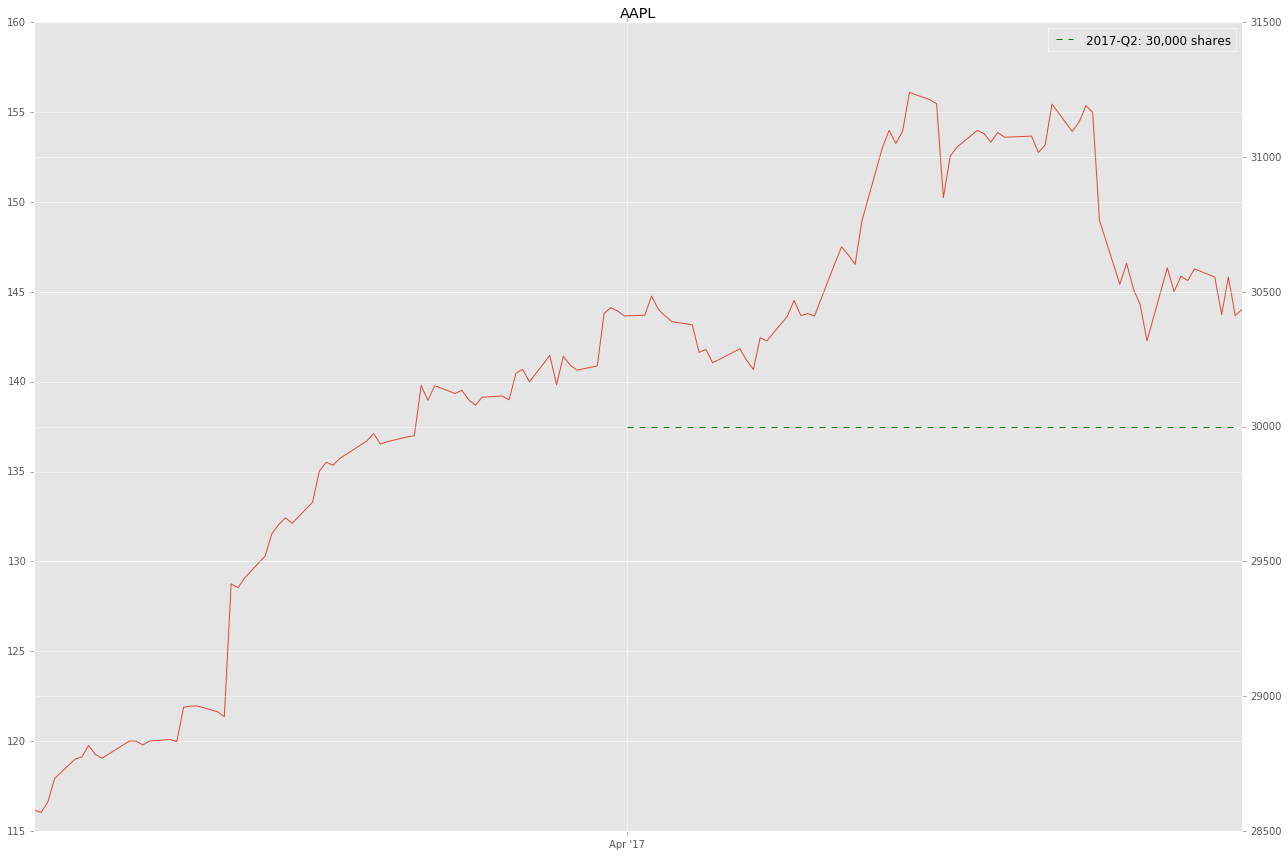

In [8]:
months = MonthLocator(range(1, 13), bymonthday=1, interval=3)
monthsFmt = DateFormatter("%b '%y")

def plot_data(symbol, p_data, s_data):
    fig = plt.figure(figsize=(18, 12)) 
    ax1 = plt.subplot(111)
    ax1.set_title(symbol)
    ax1.plot(p_data["index"], p_data["close"], label='Price')    
    
    ax1.xaxis.set_major_locator(months)
    ax1.xaxis.set_major_formatter(monthsFmt)
    
    ax2 = ax1.twinx()
    for line in s_data:
        start, end, value = line
        ax2.plot([start, end], [value, value], "g--", 
                 label='{}-Q{}: {:,} shares'.format(start.year, start.month // 3 + 1, value))
    
    fig.tight_layout()
    plt.legend(loc='best')
    plt.show()

shares_data = [(datetime(2017, 4, 1), datetime(2017, 6, 30), 30000)]
plot_data("AAPL", price_data, shares_data)

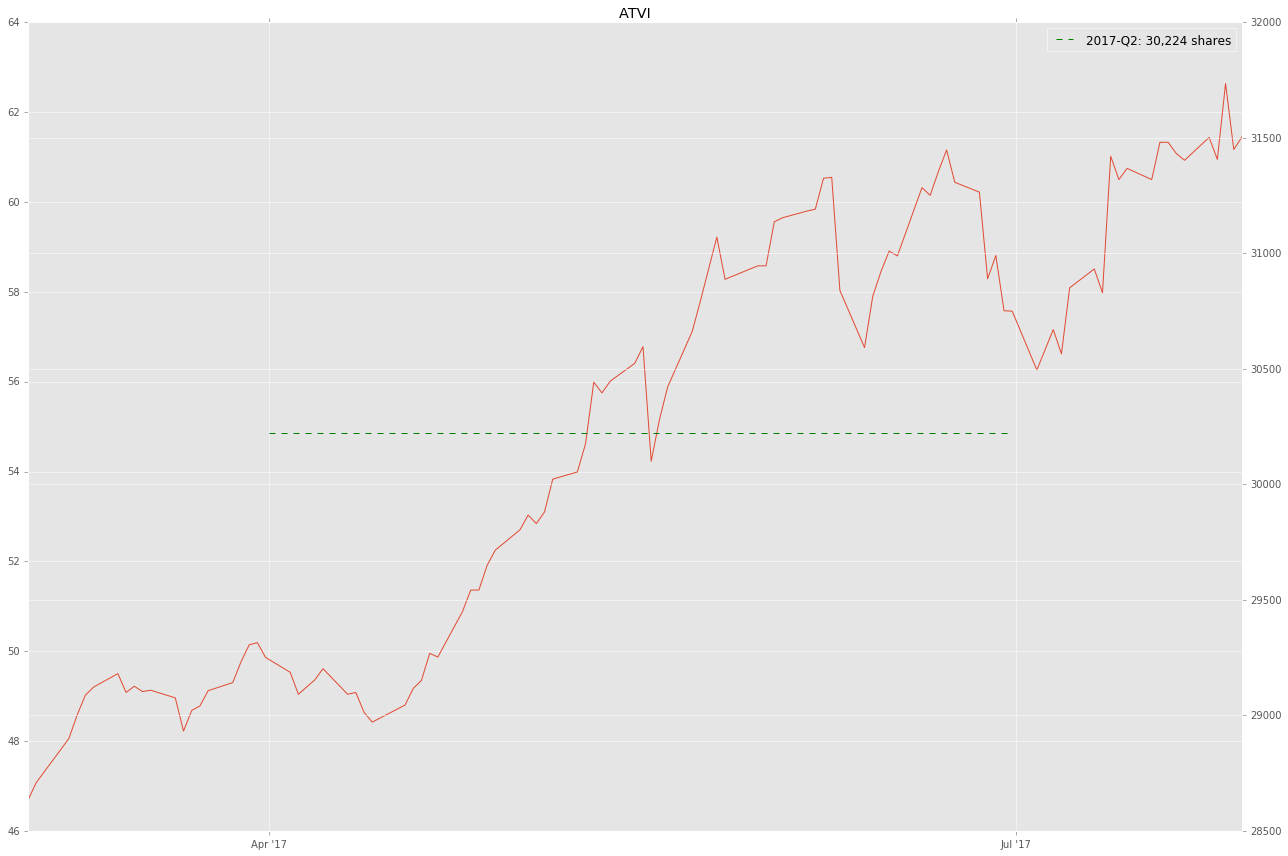

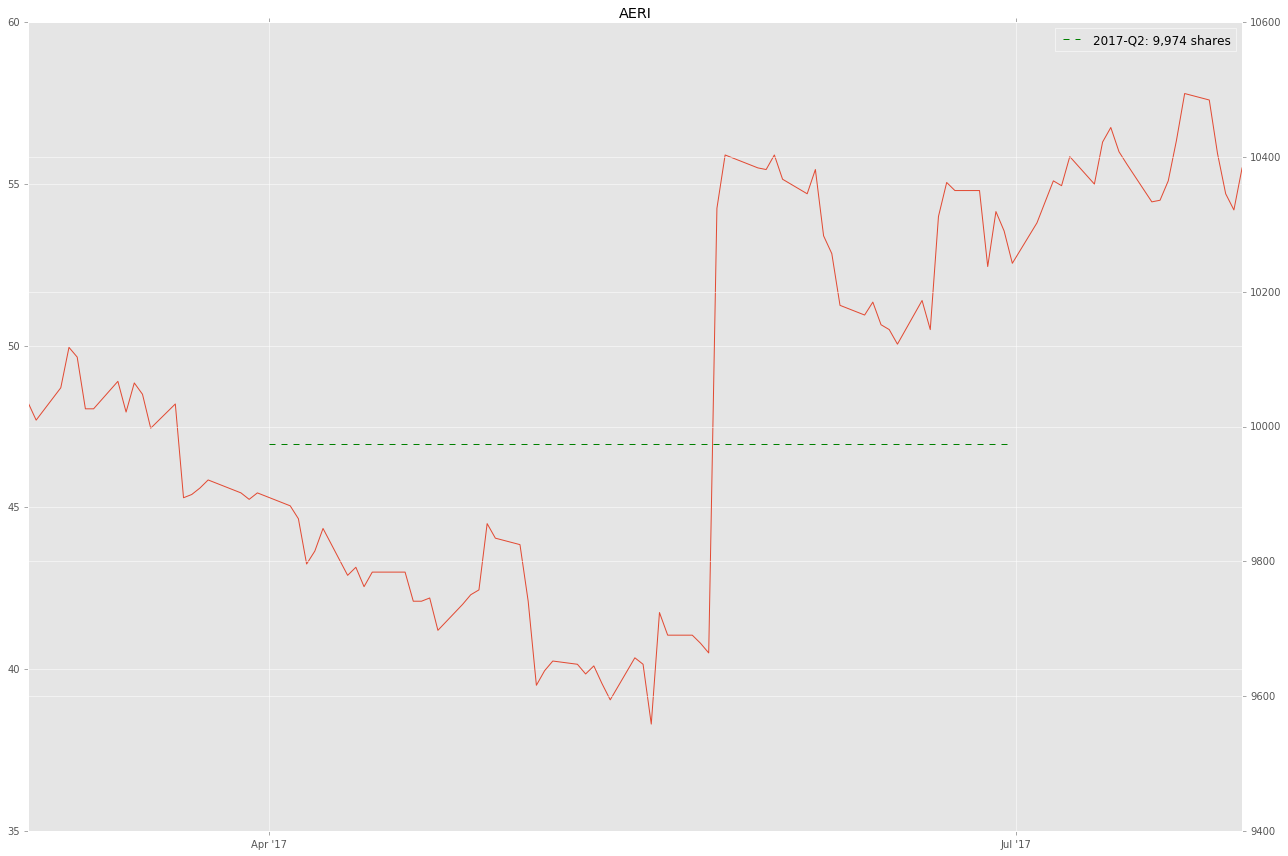

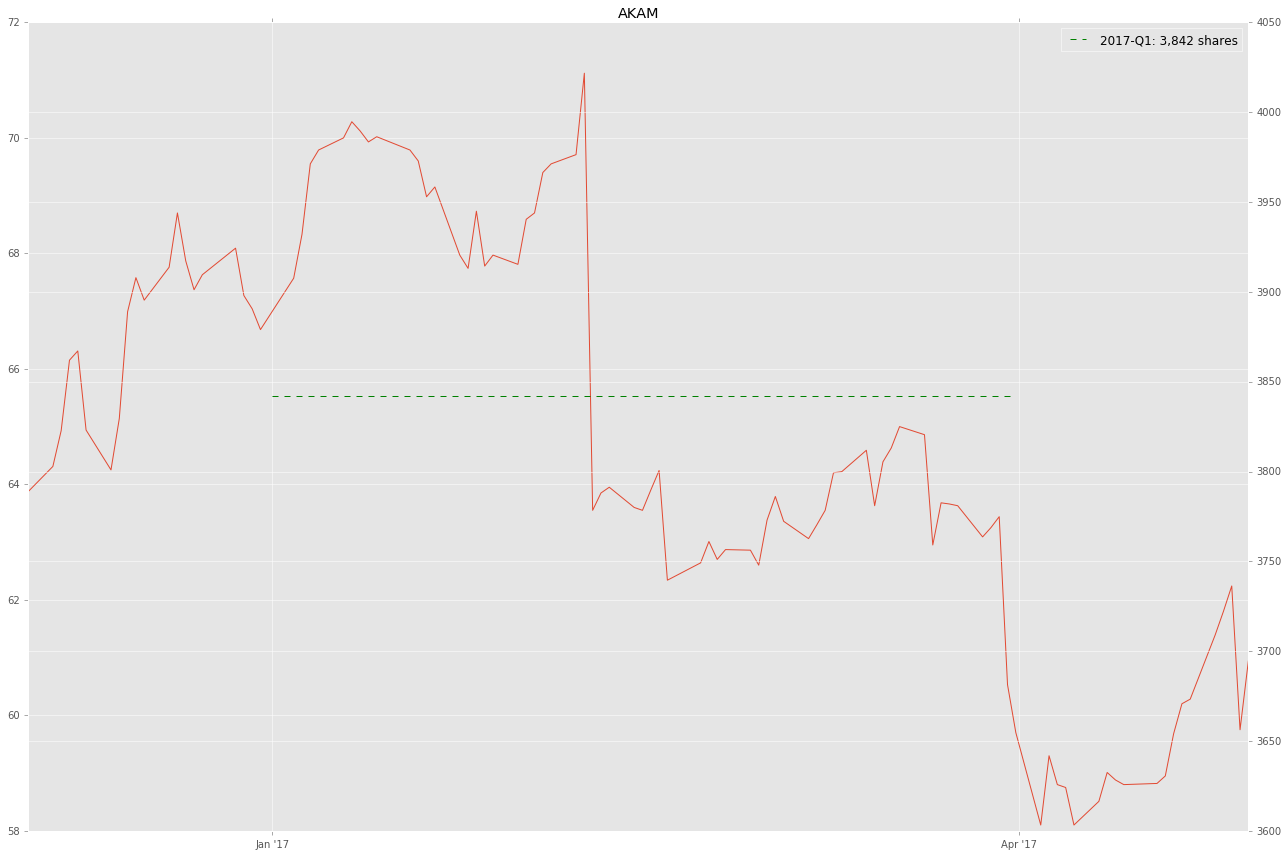

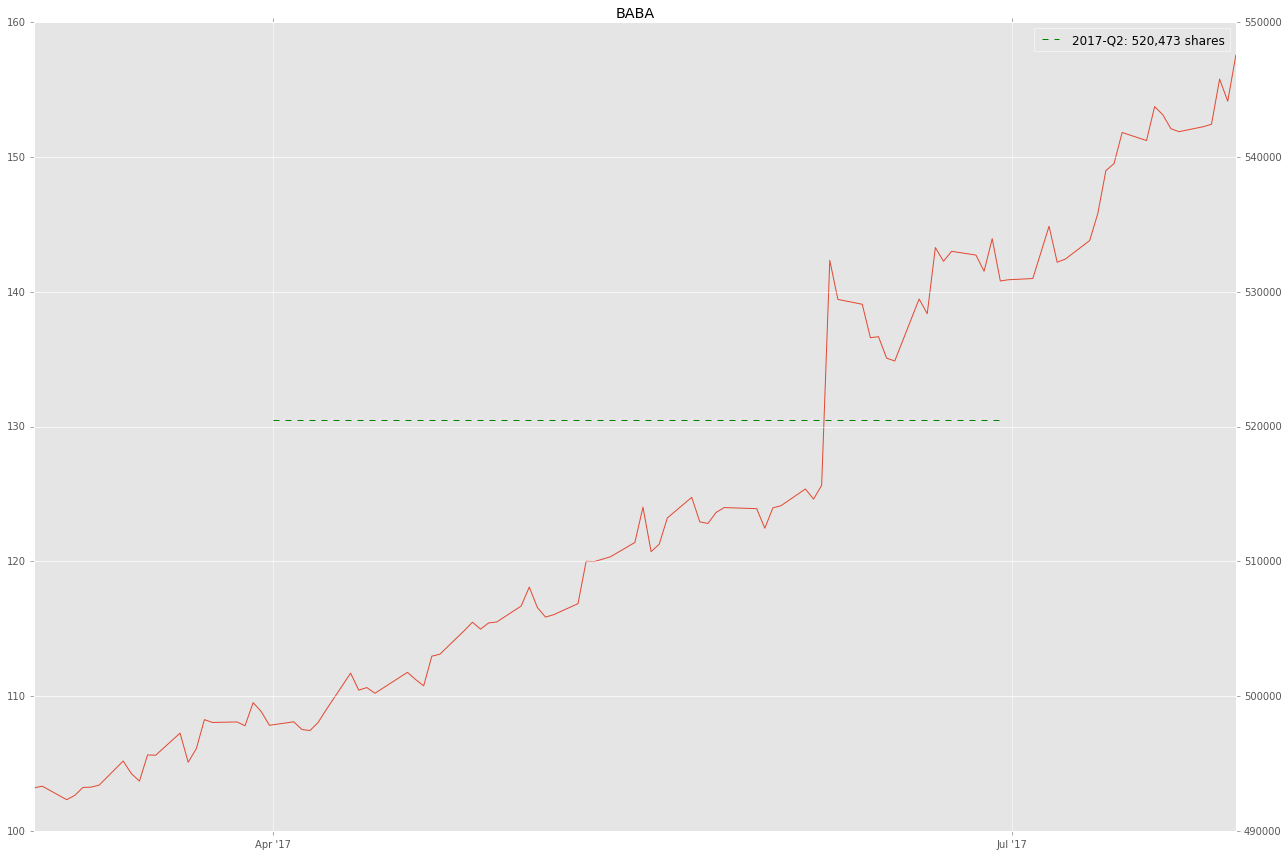

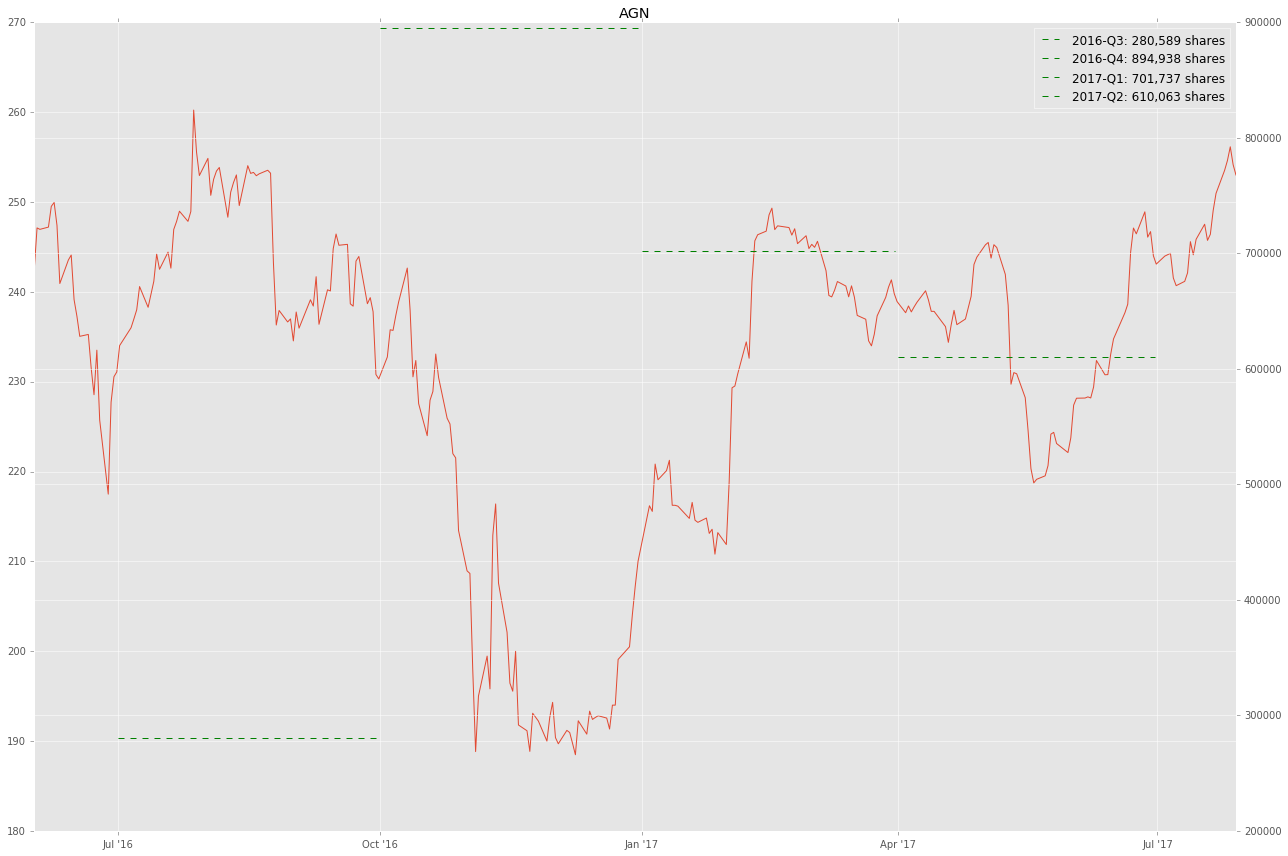

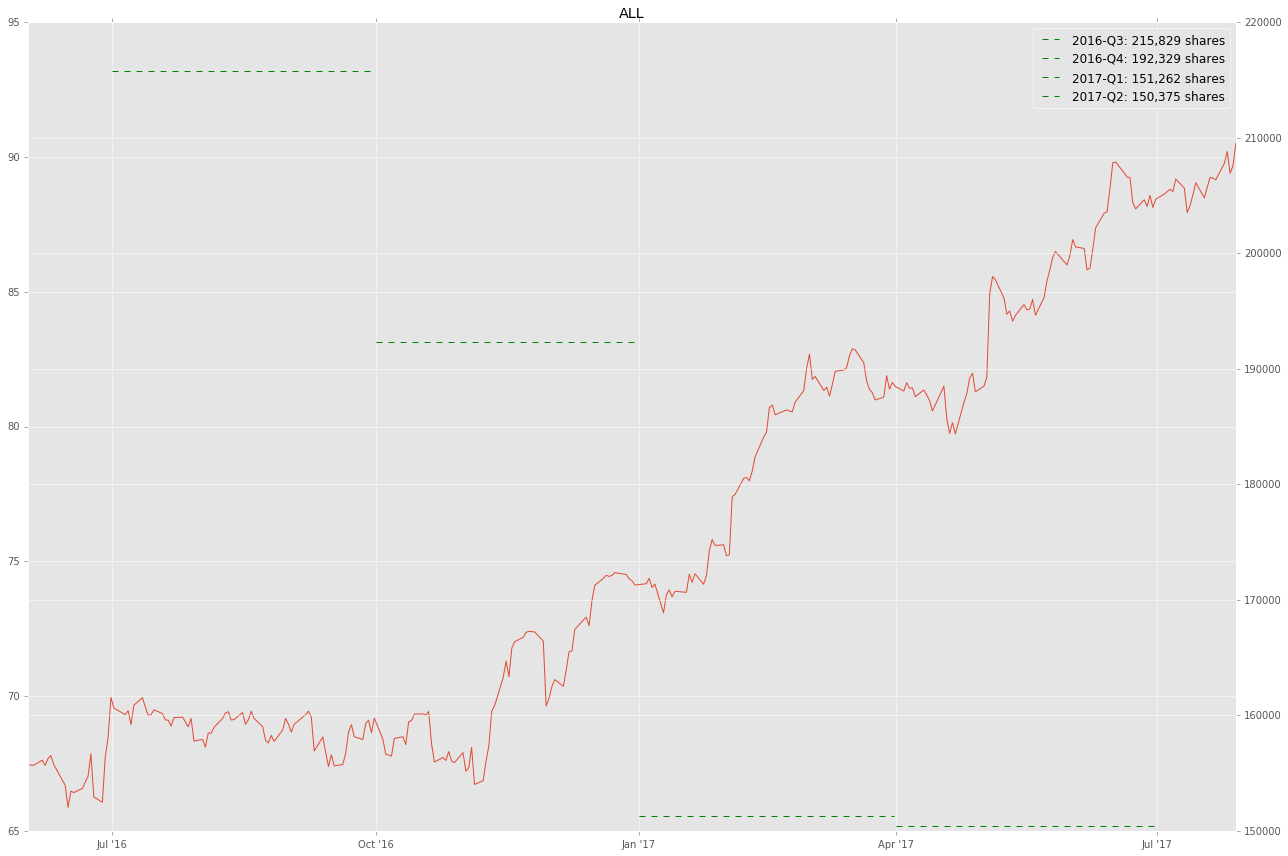

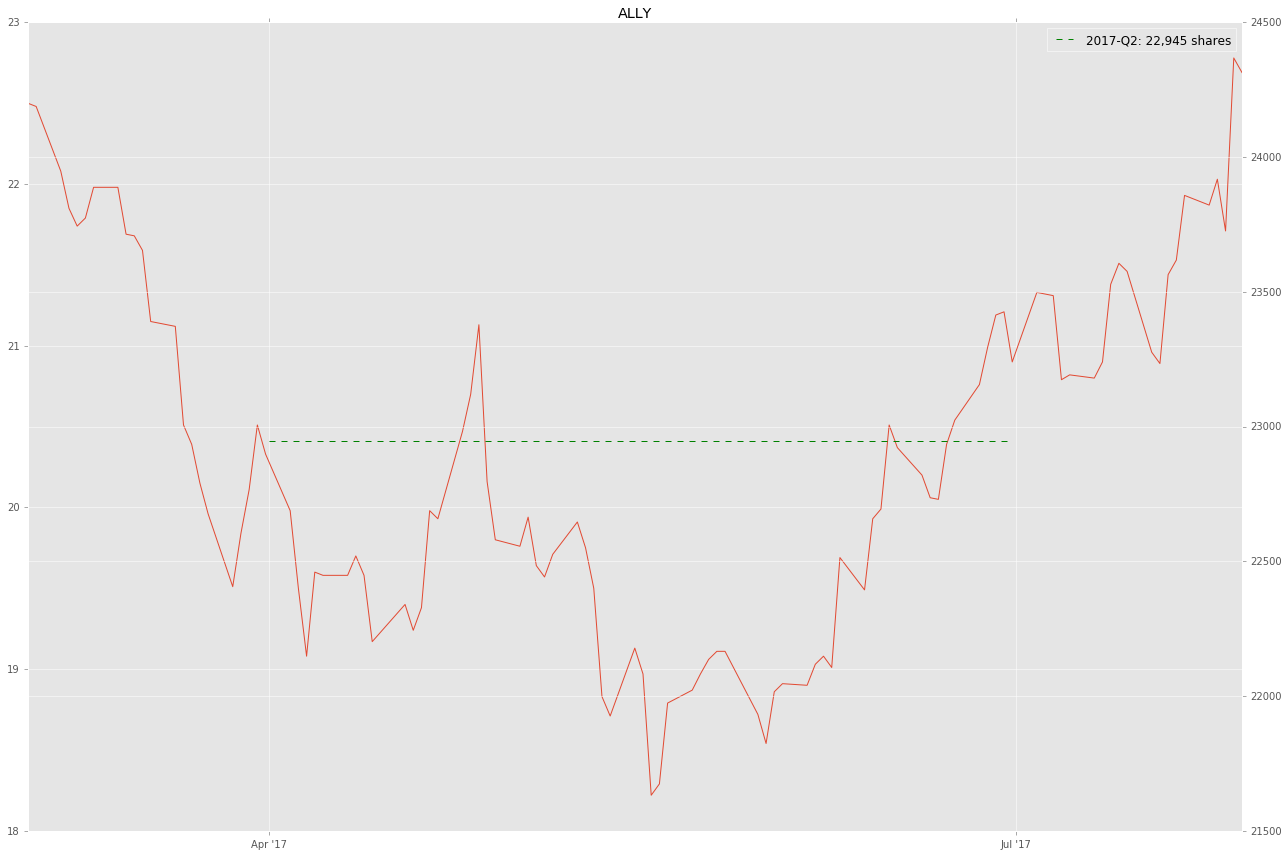

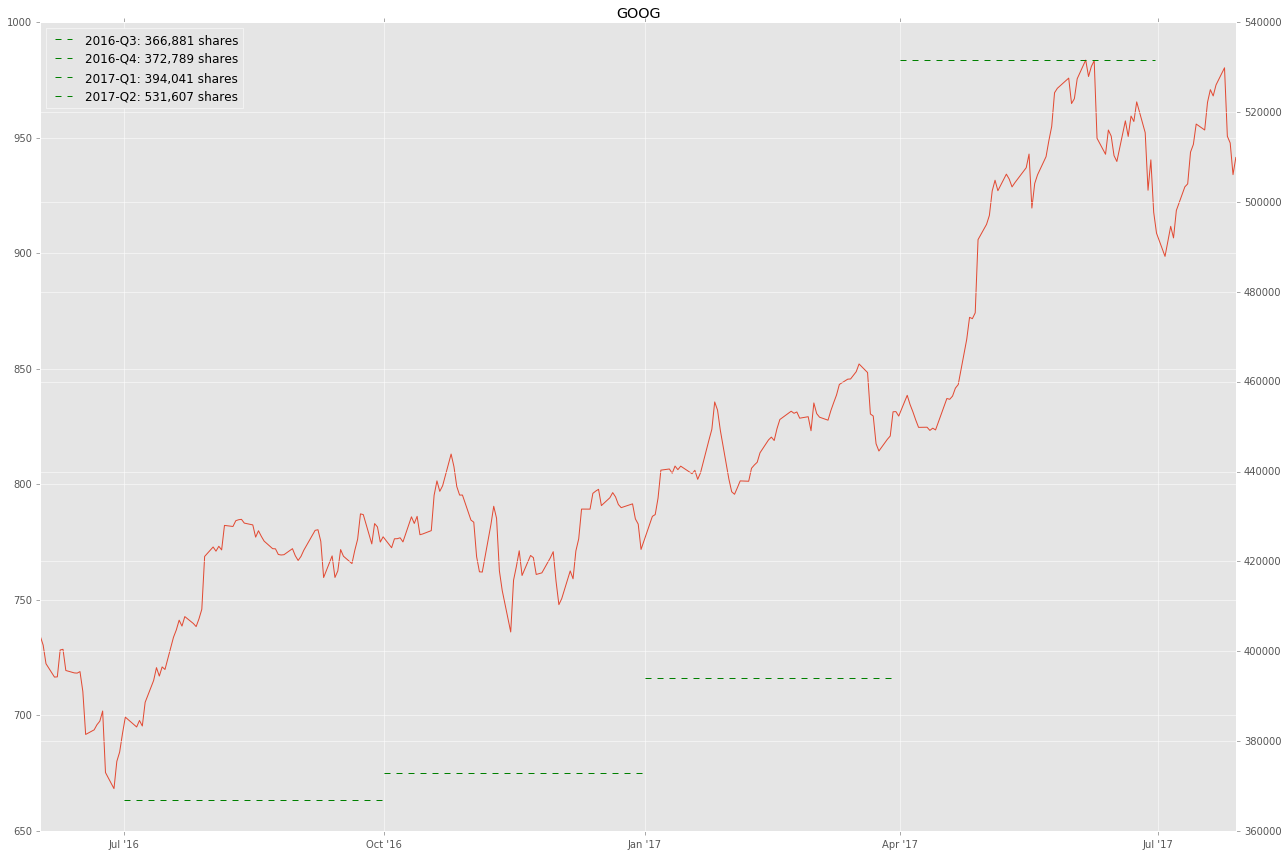

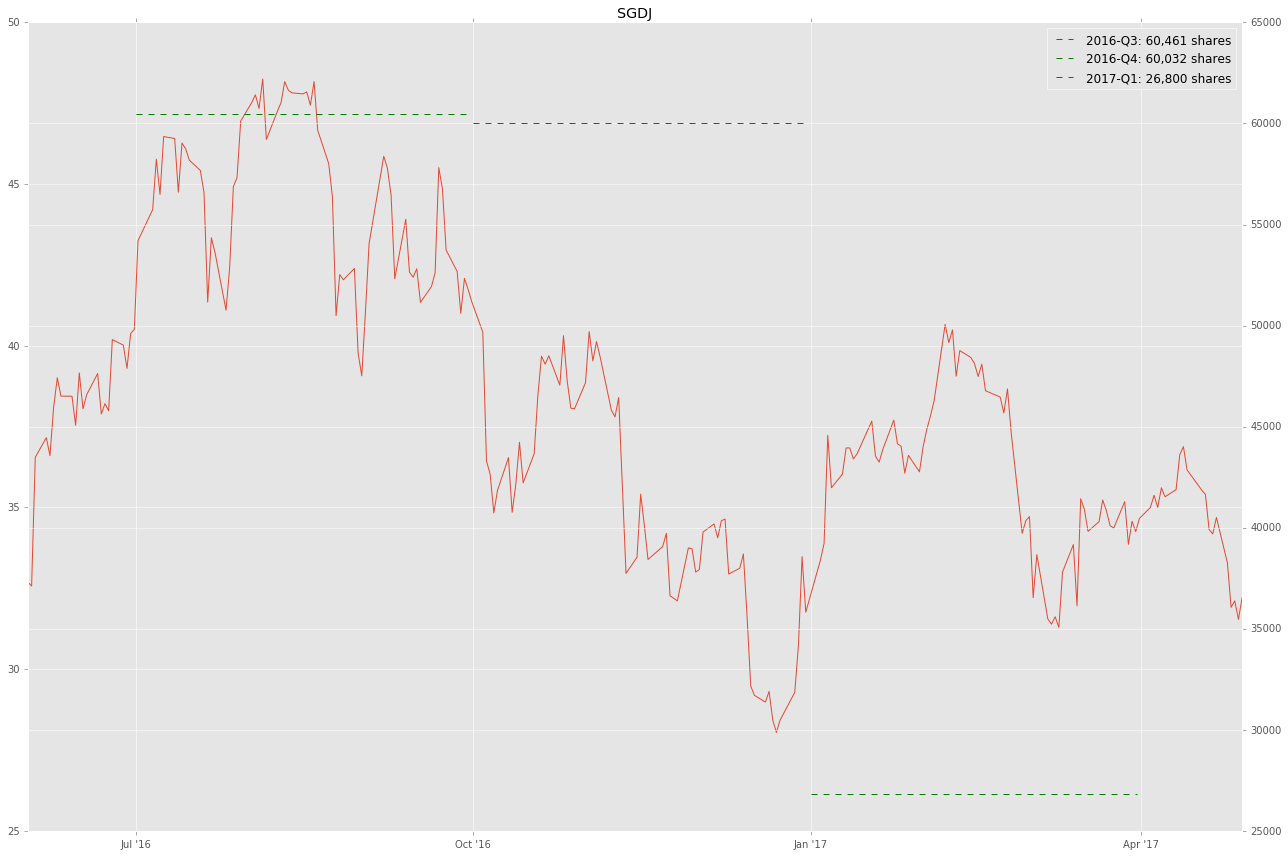

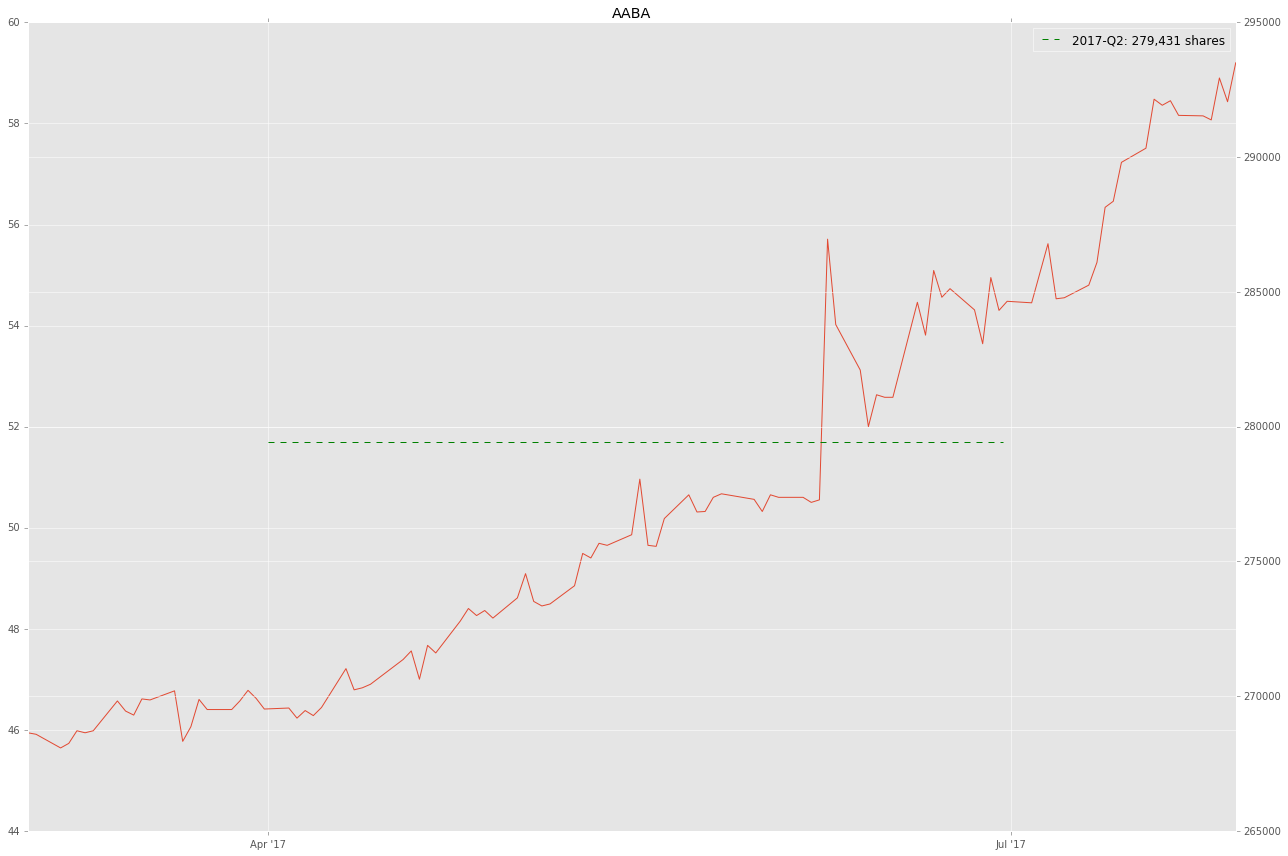

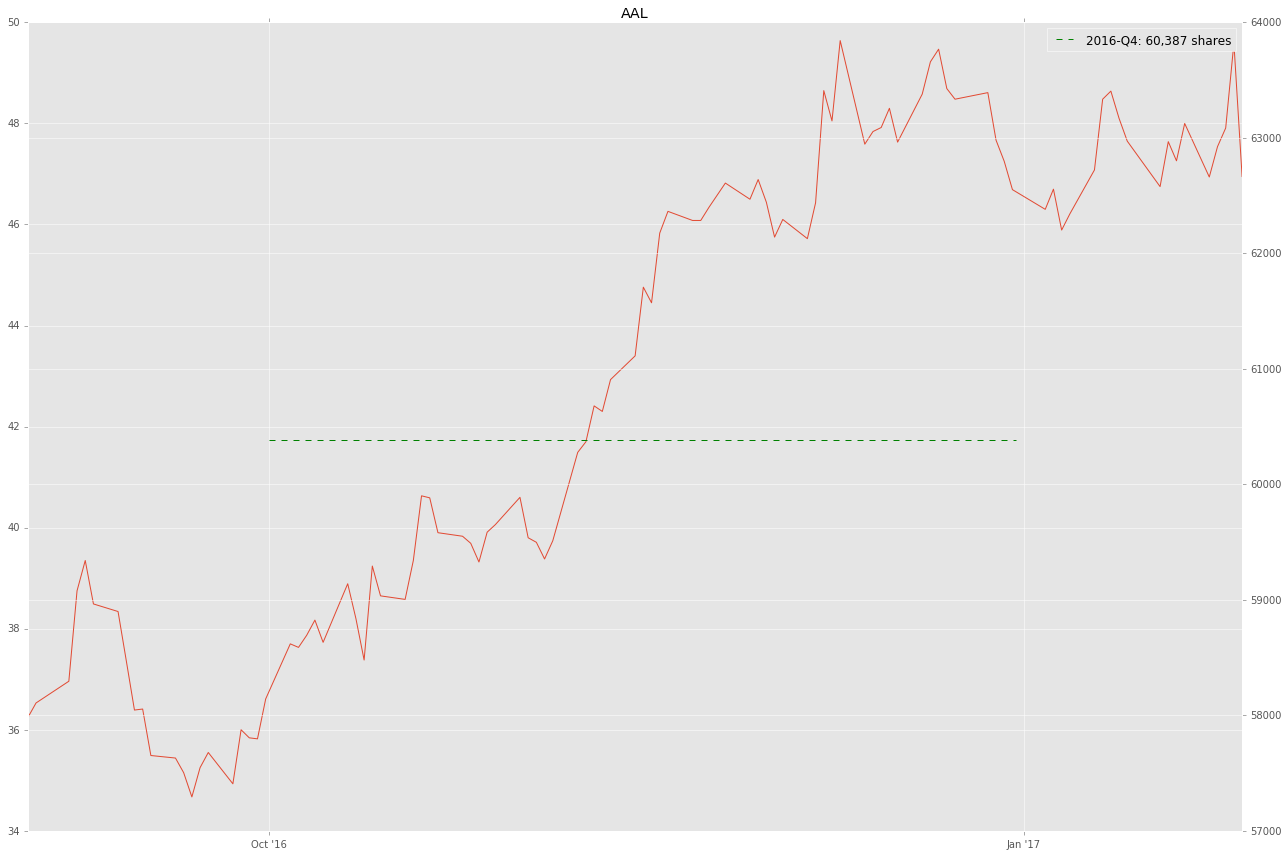

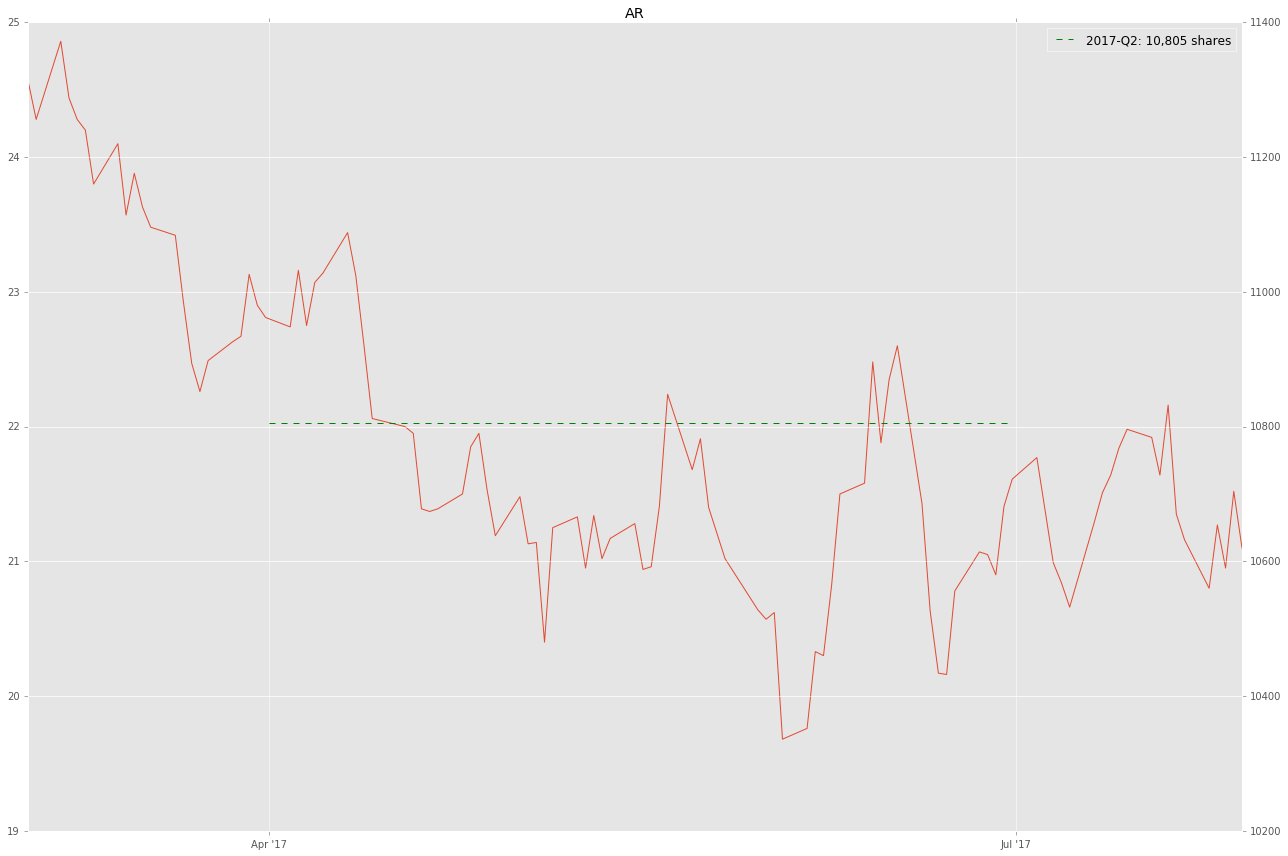

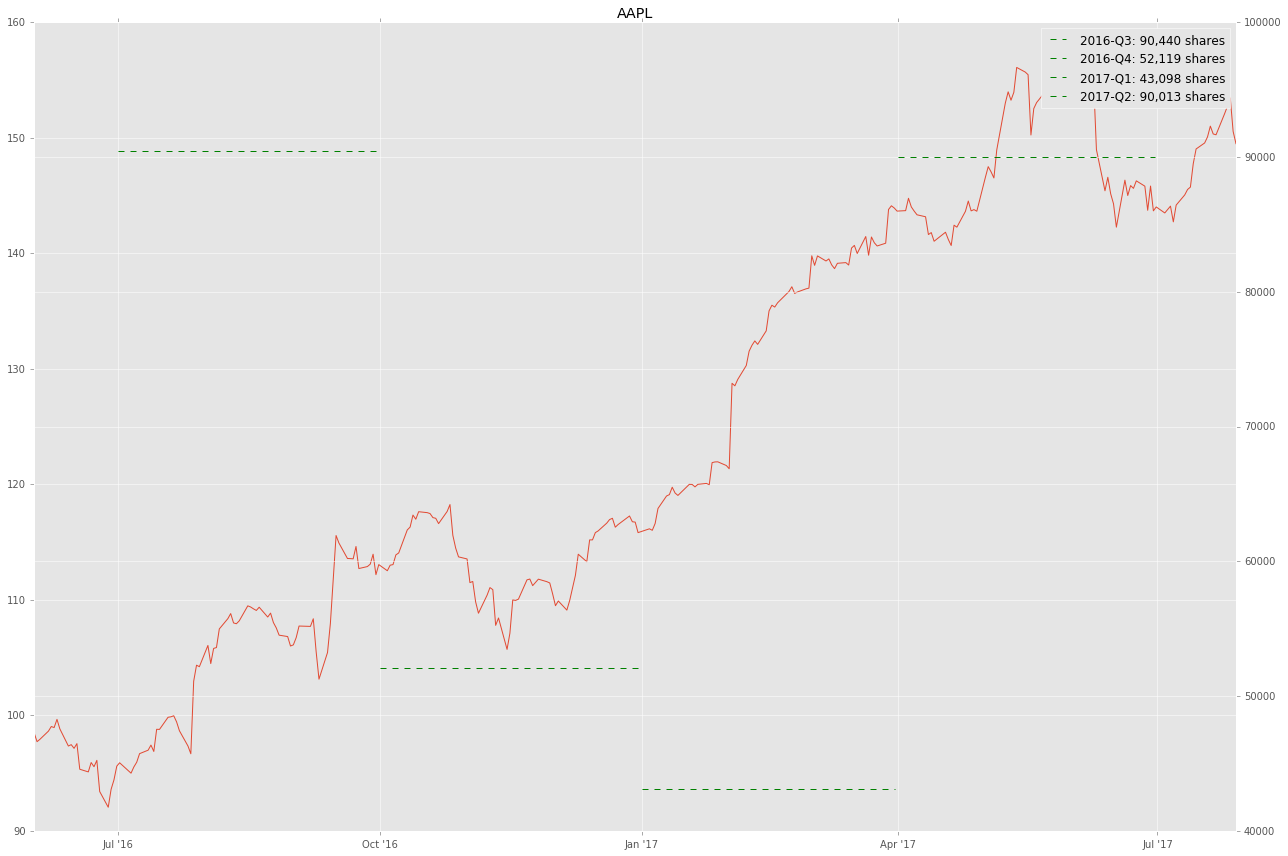

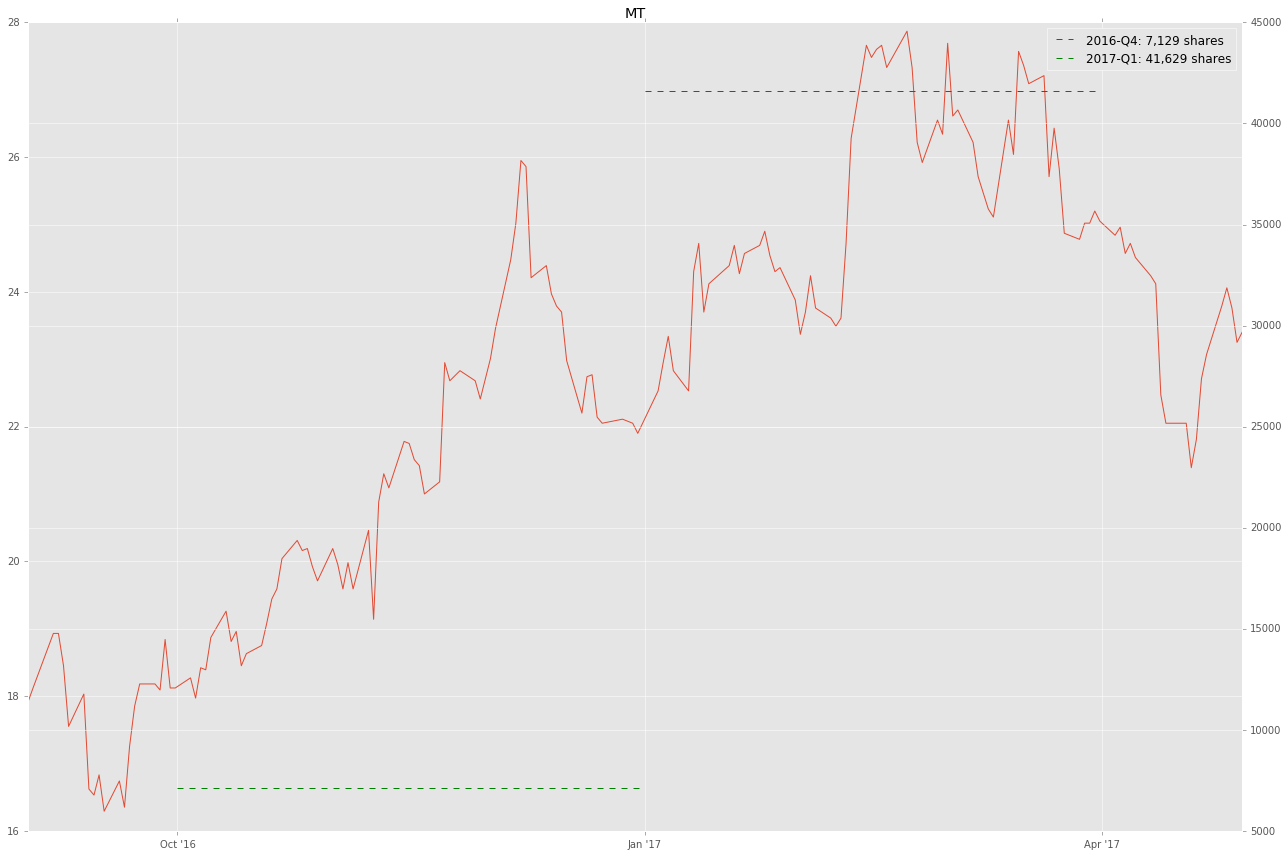

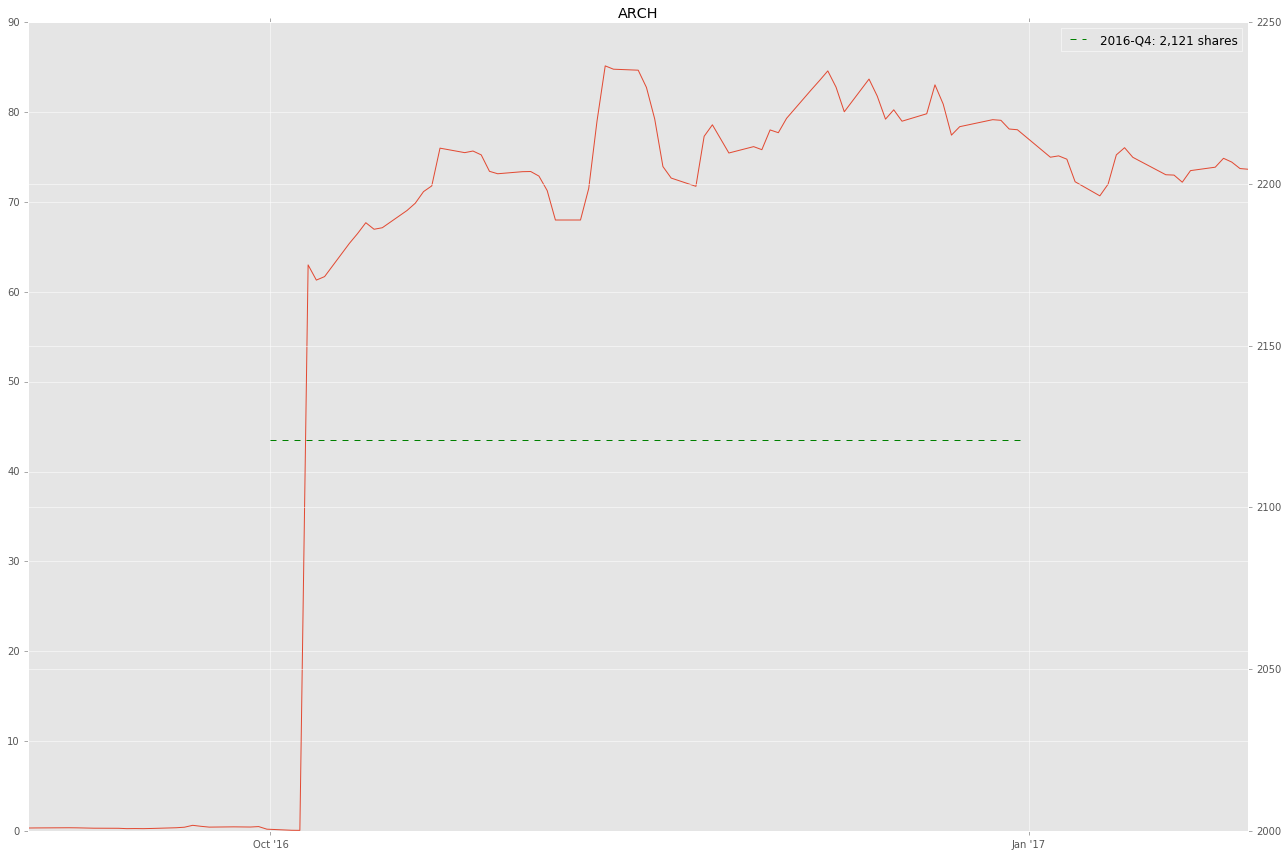

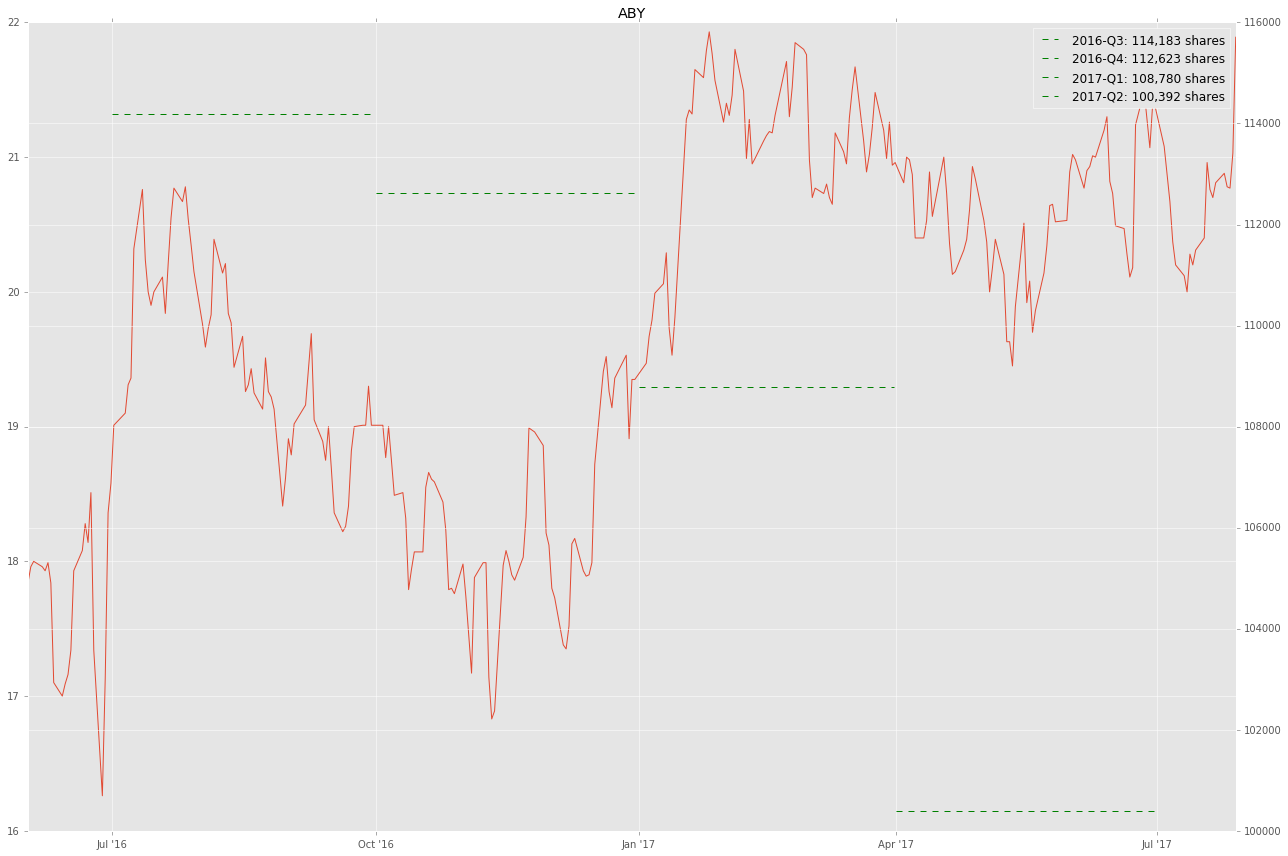

BAC$I {'chart': {'error': {'description': 'No data found, symbol may be delisted', 'code': 'Not Found'}, 'result': None}}


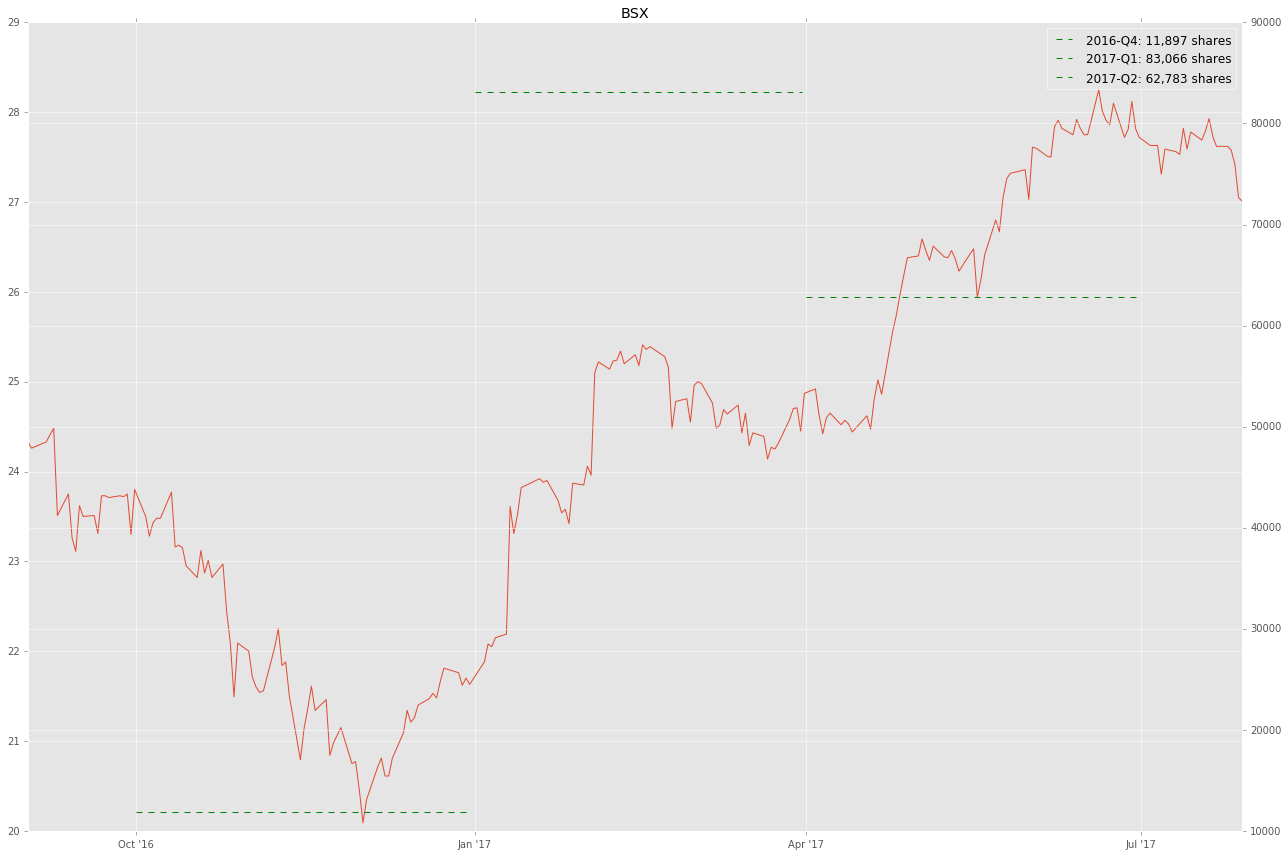

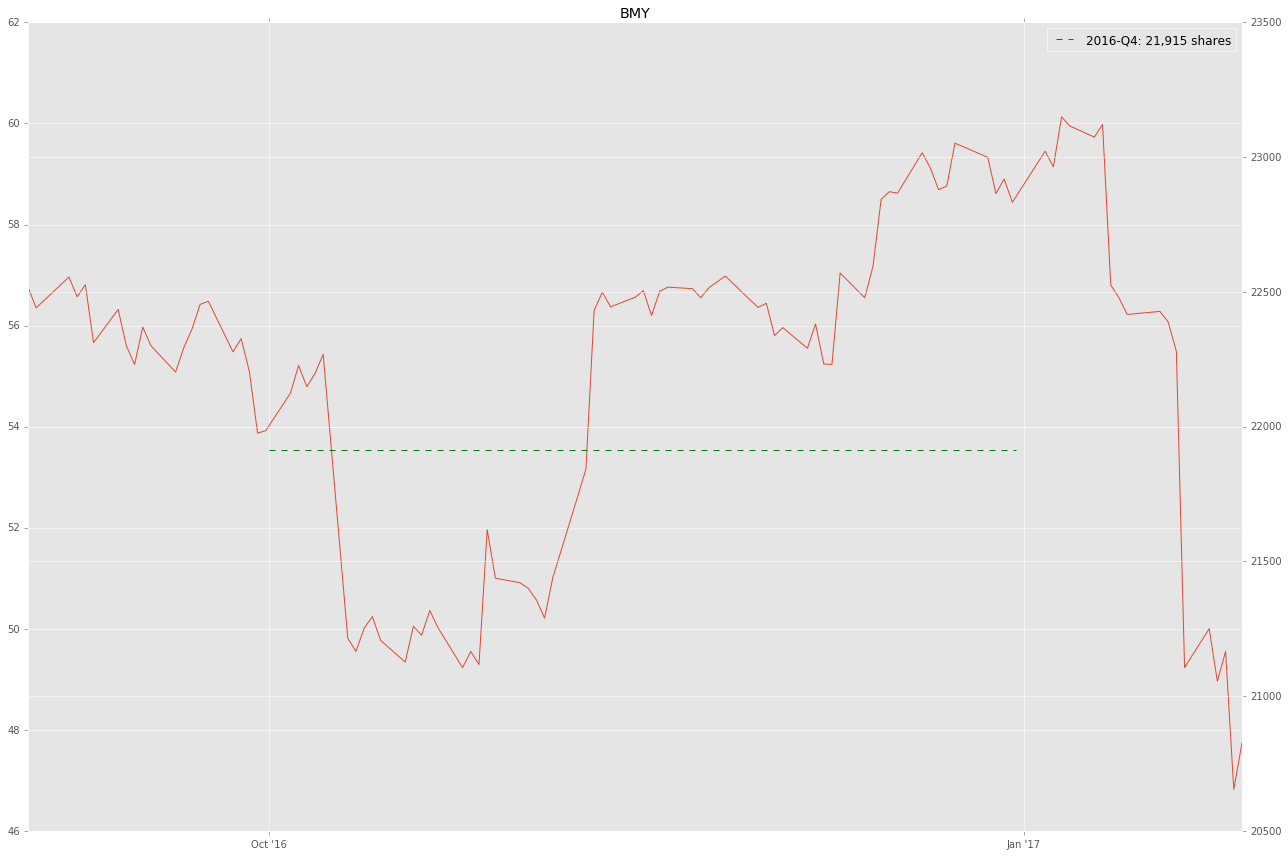

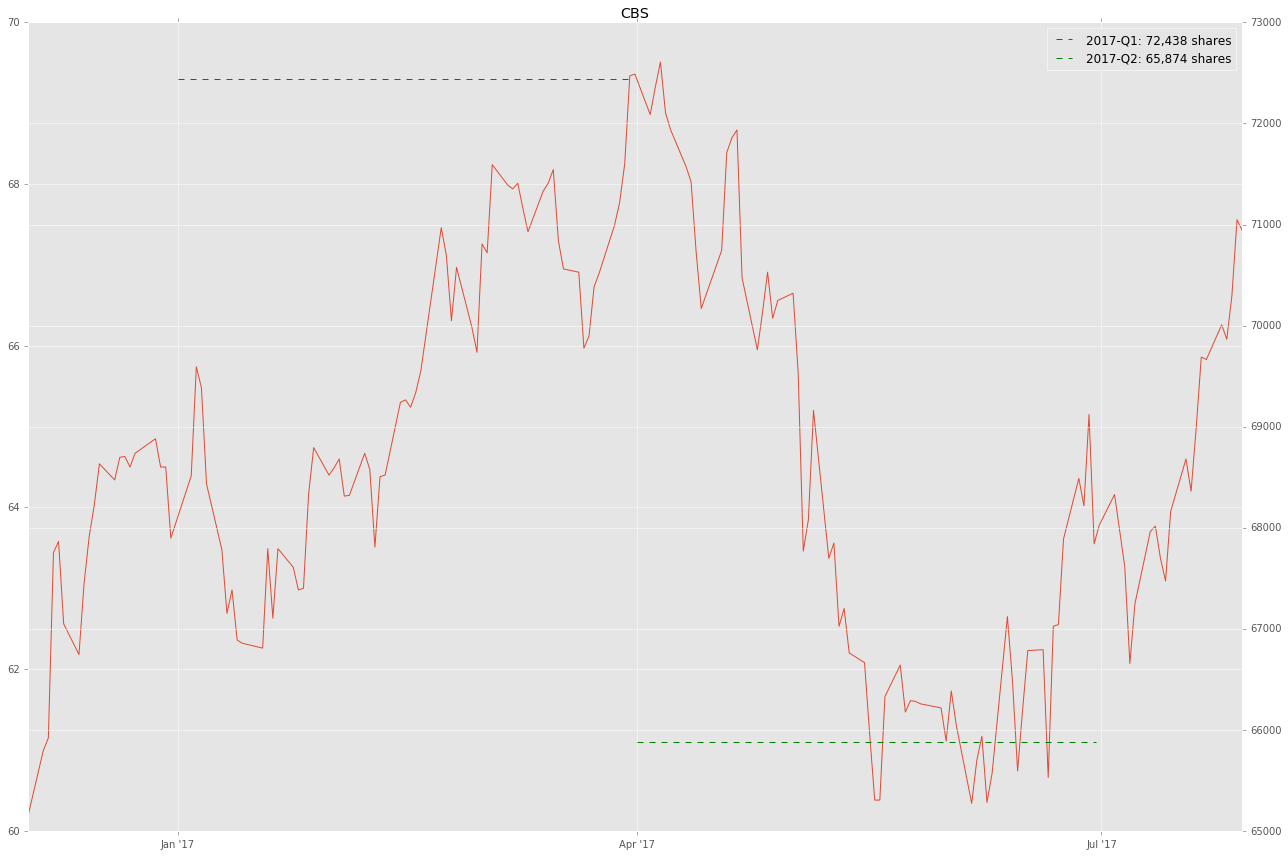

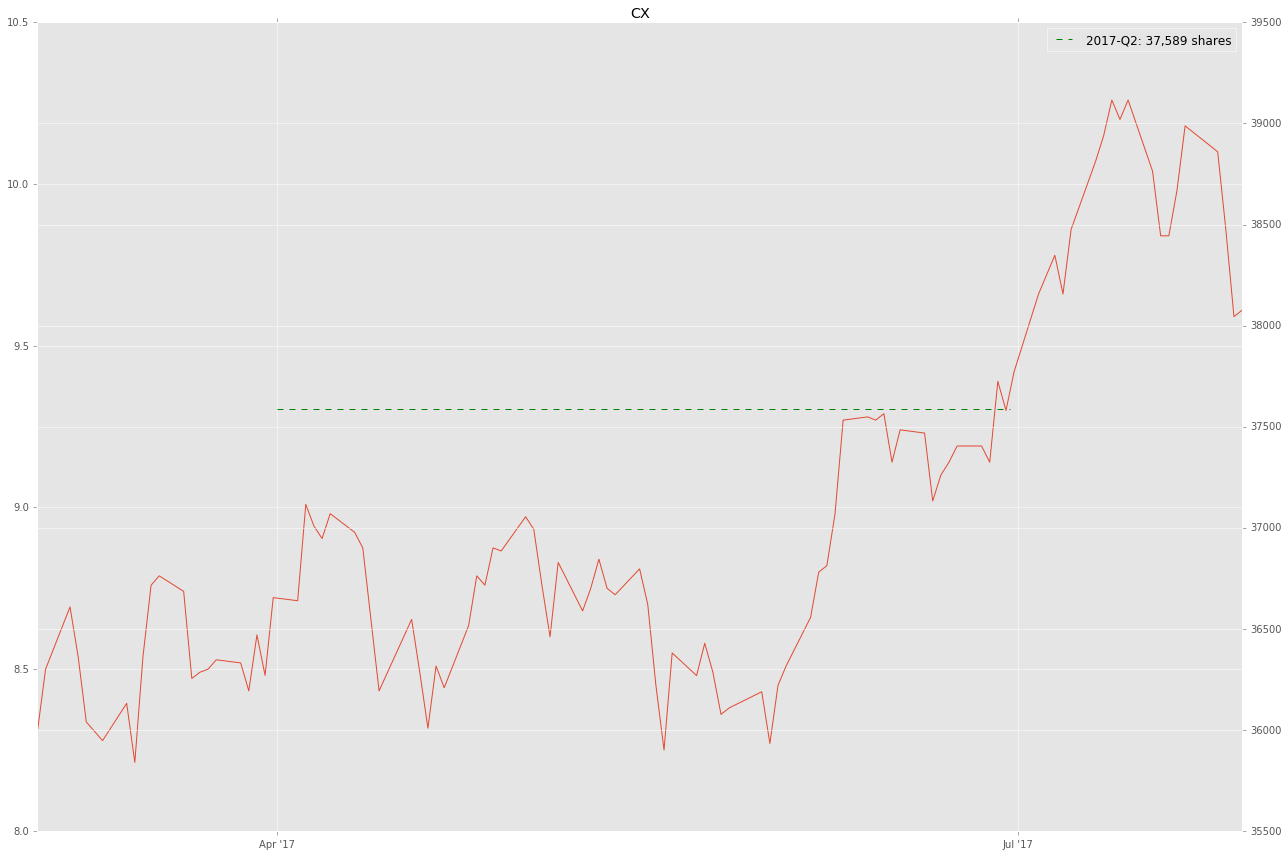

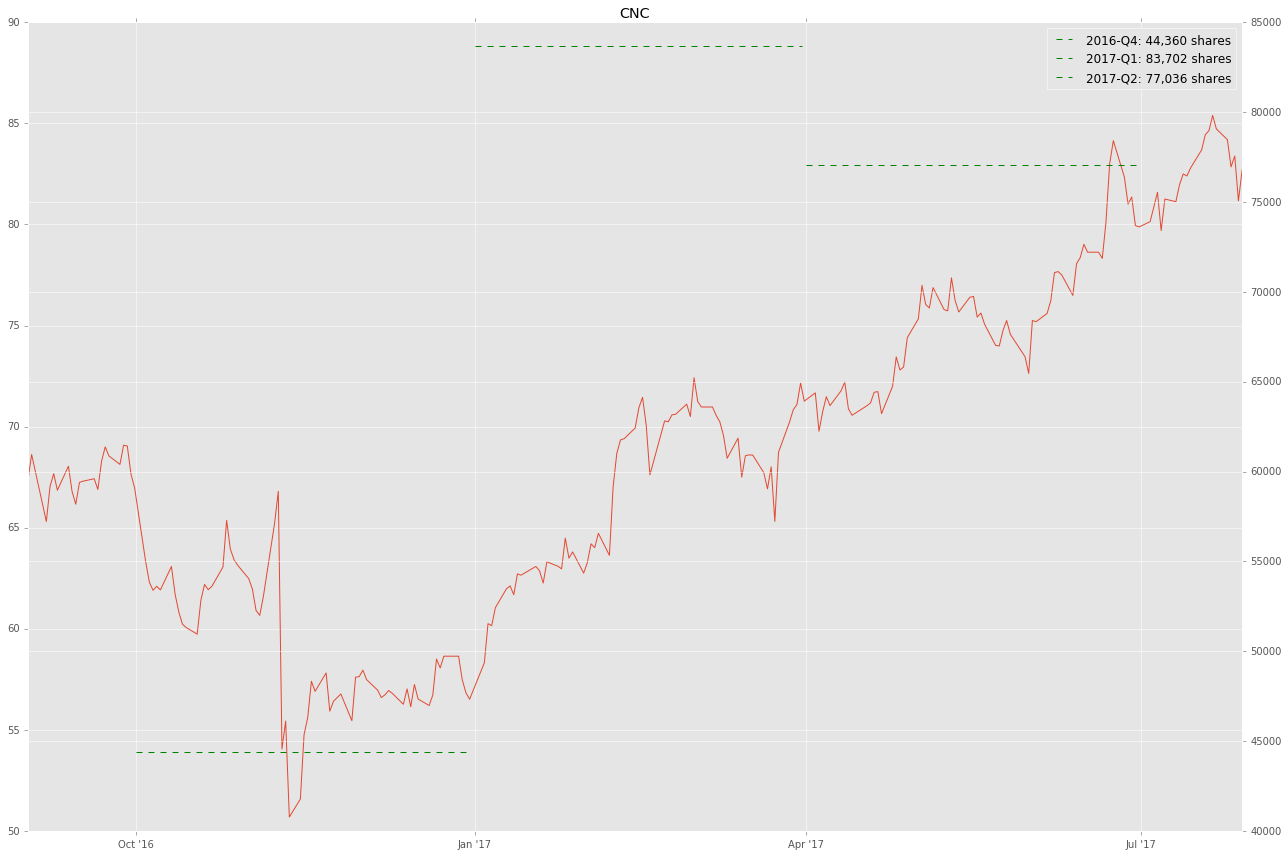

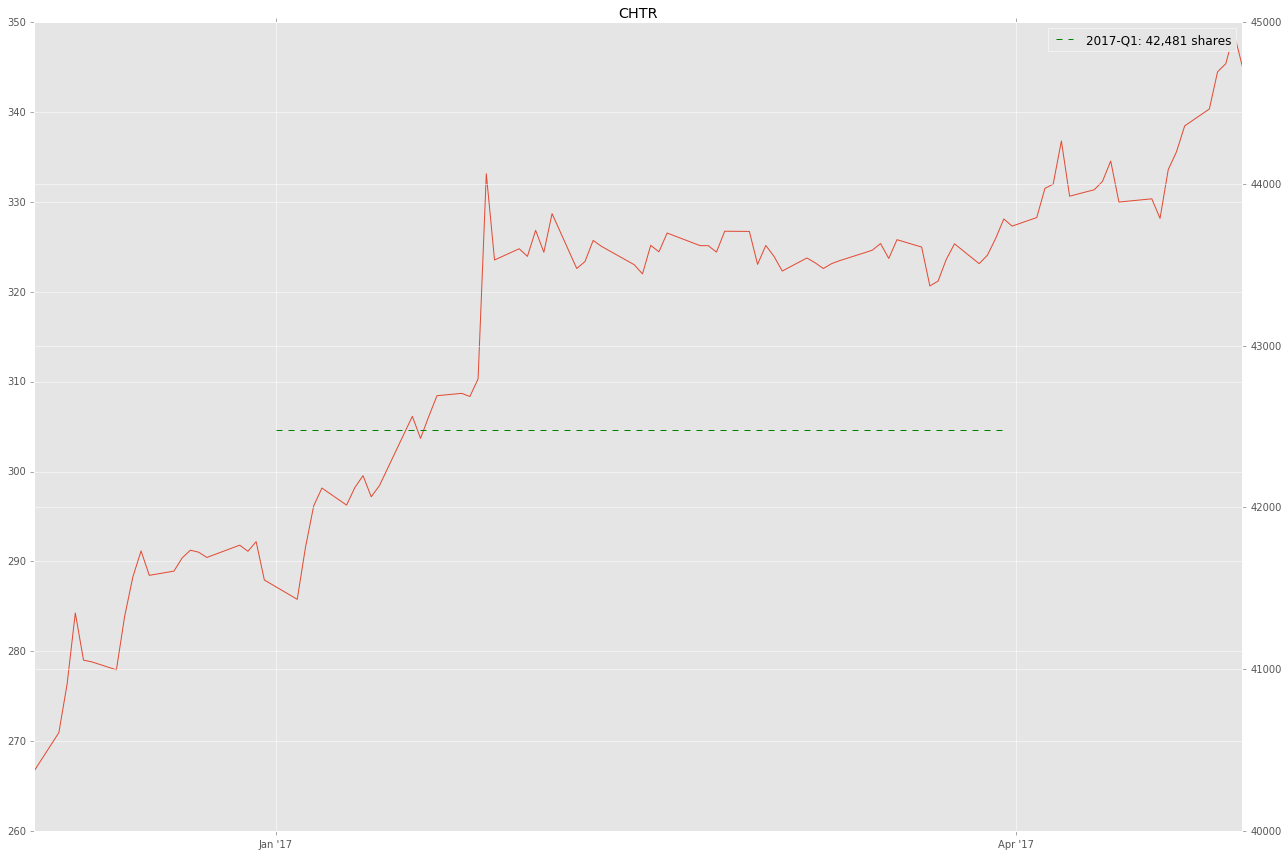

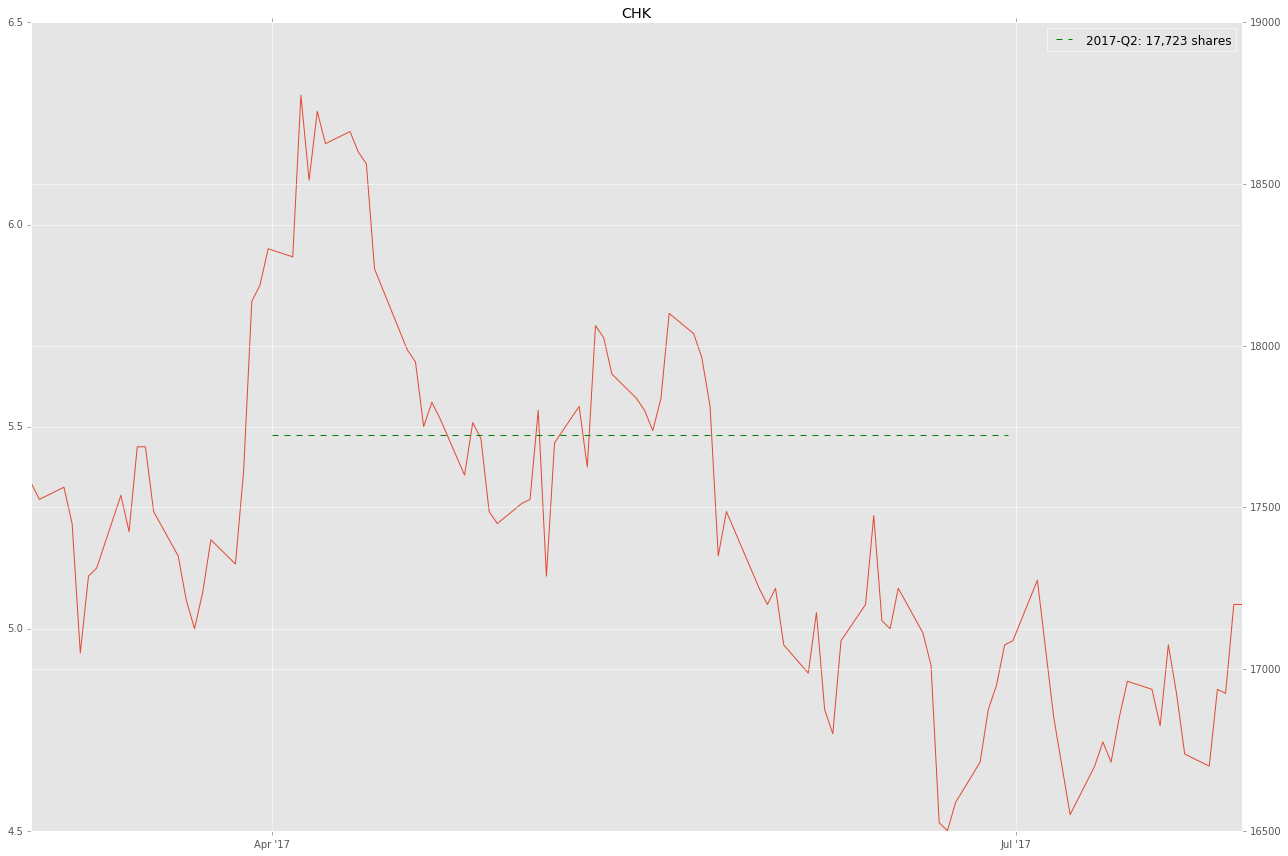

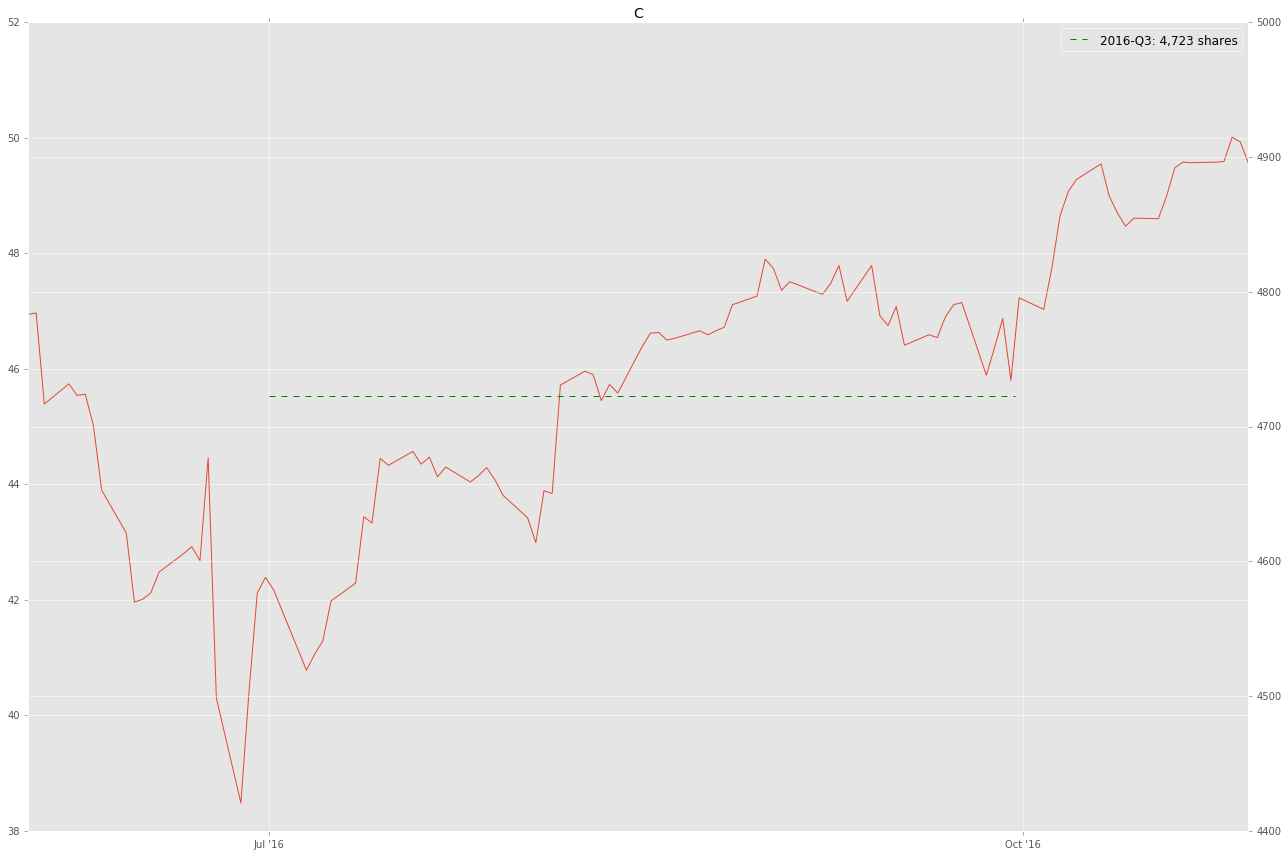

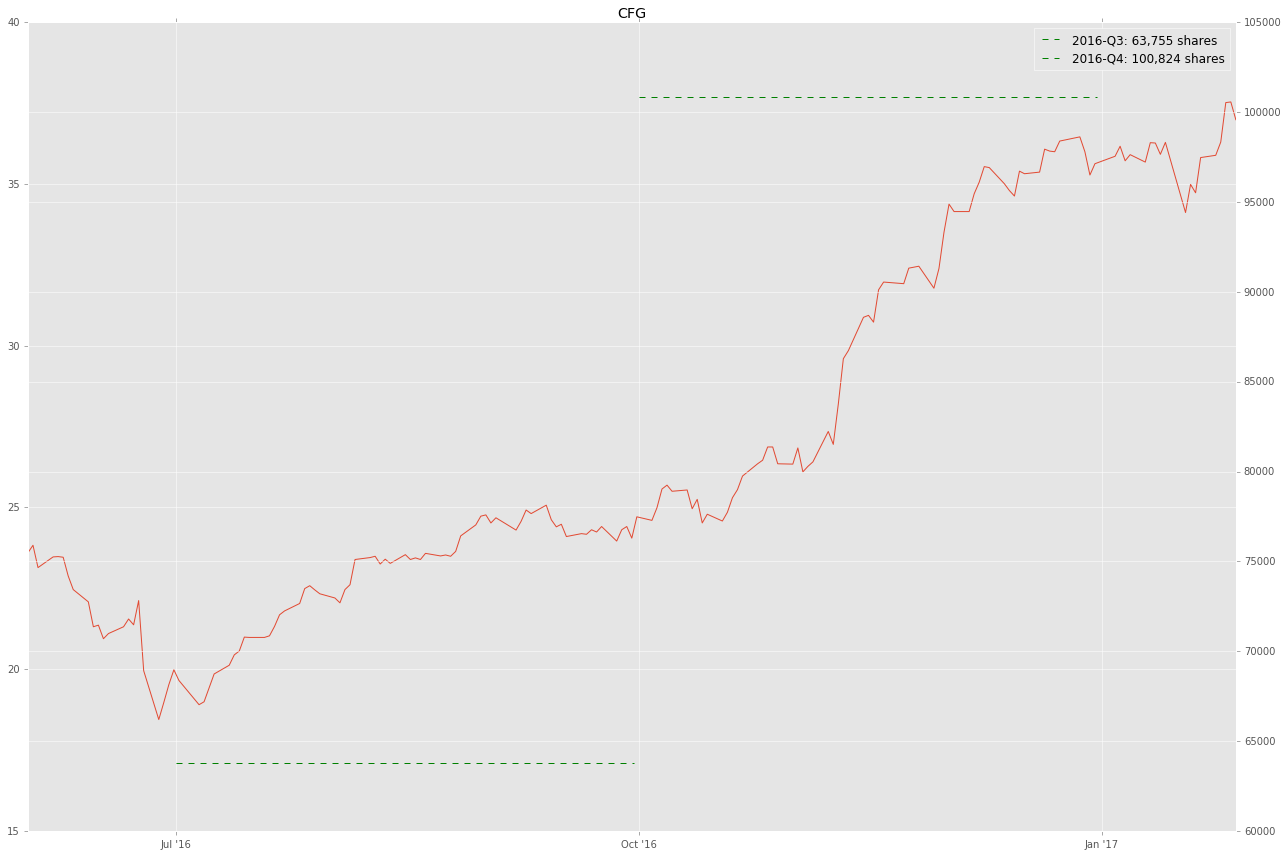

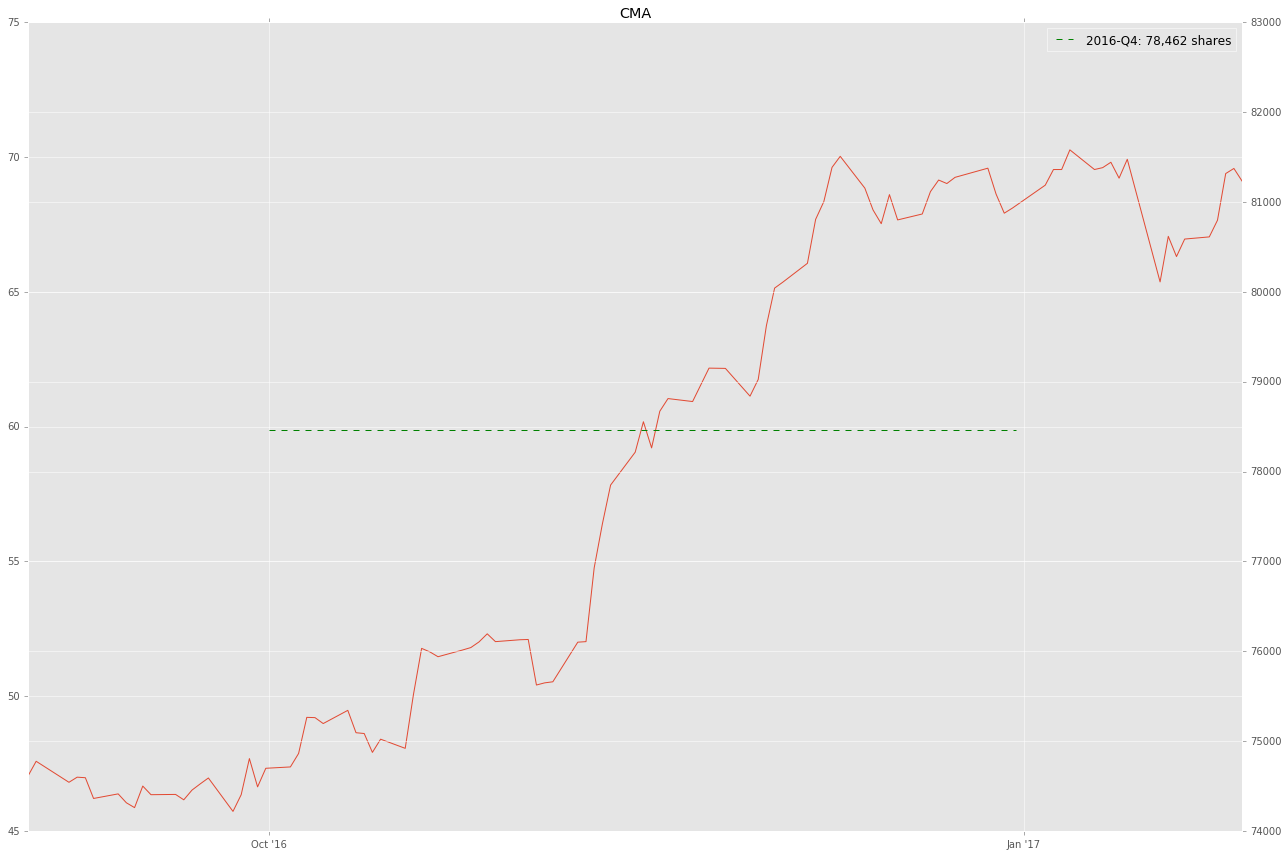

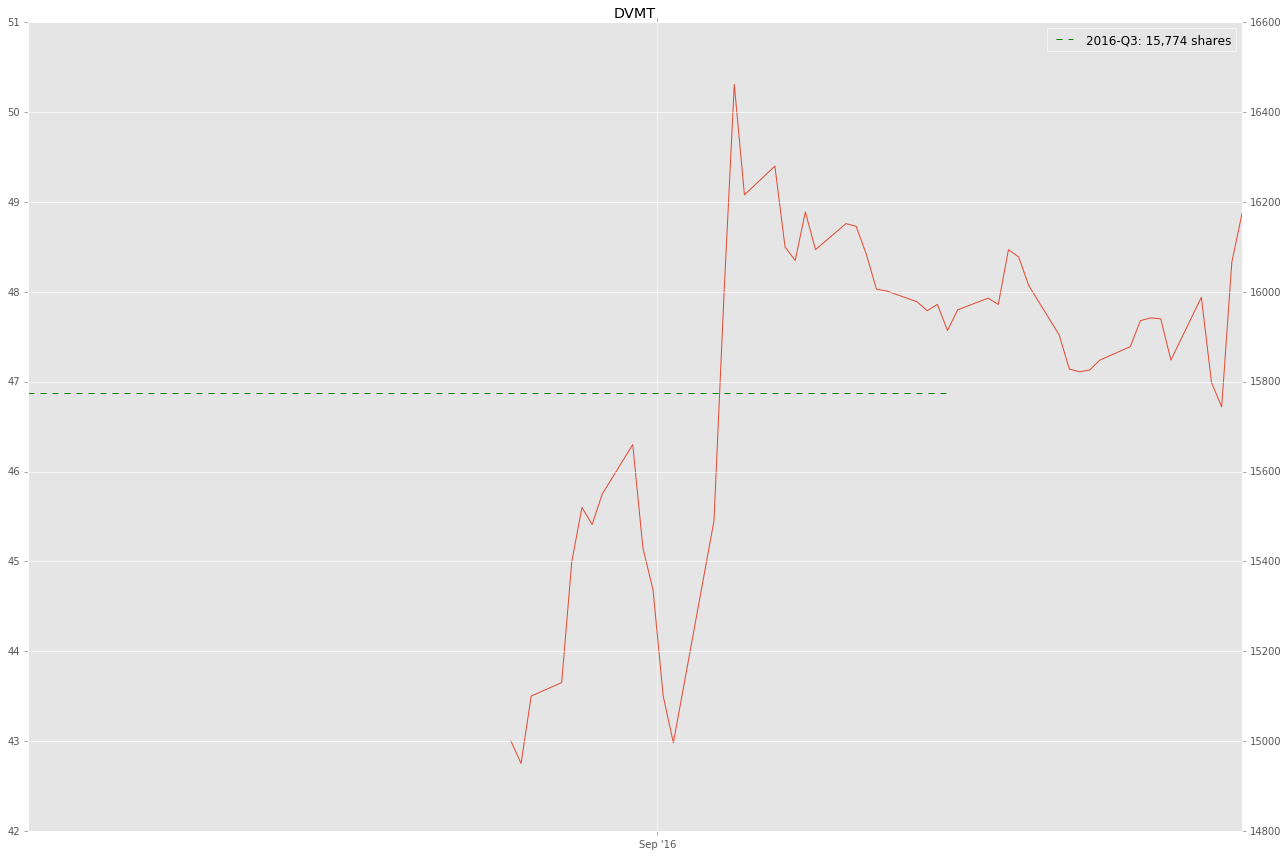

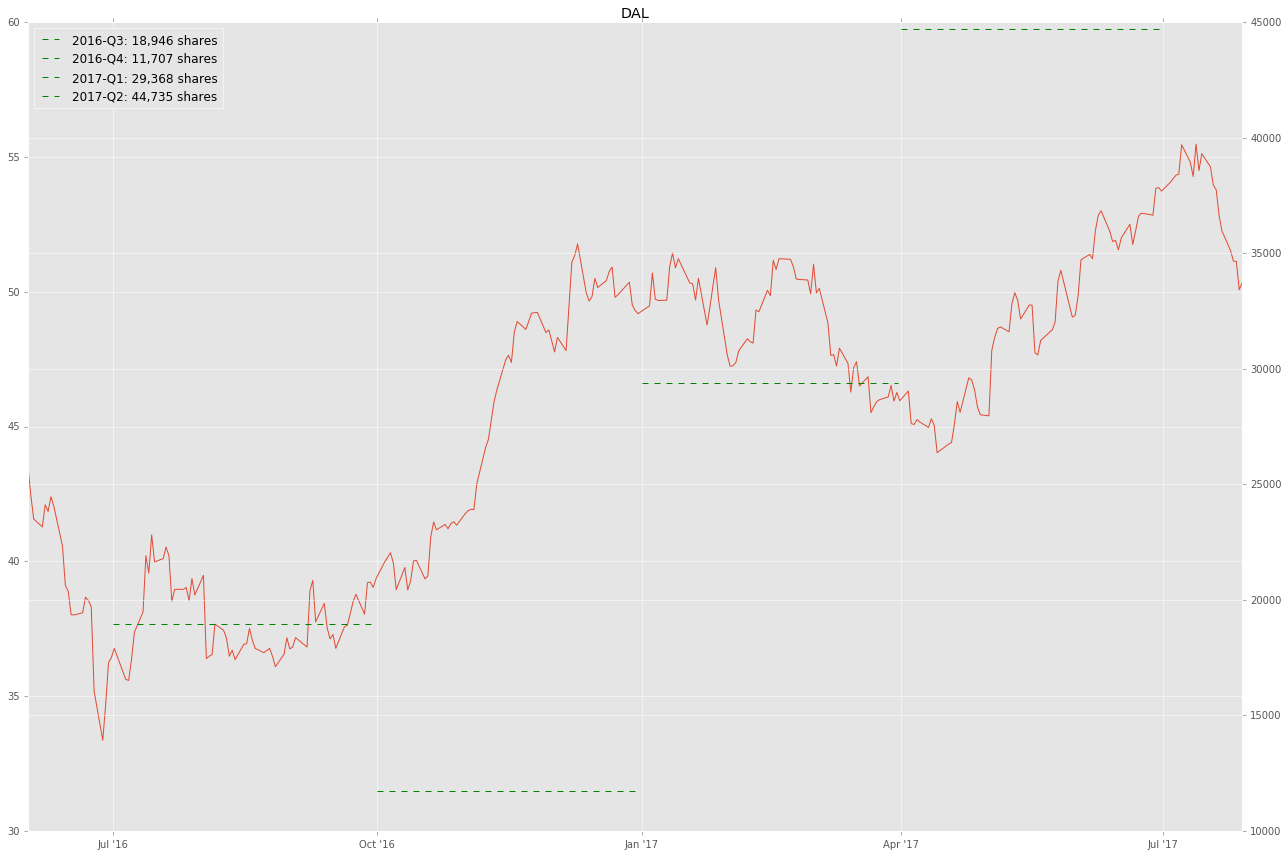

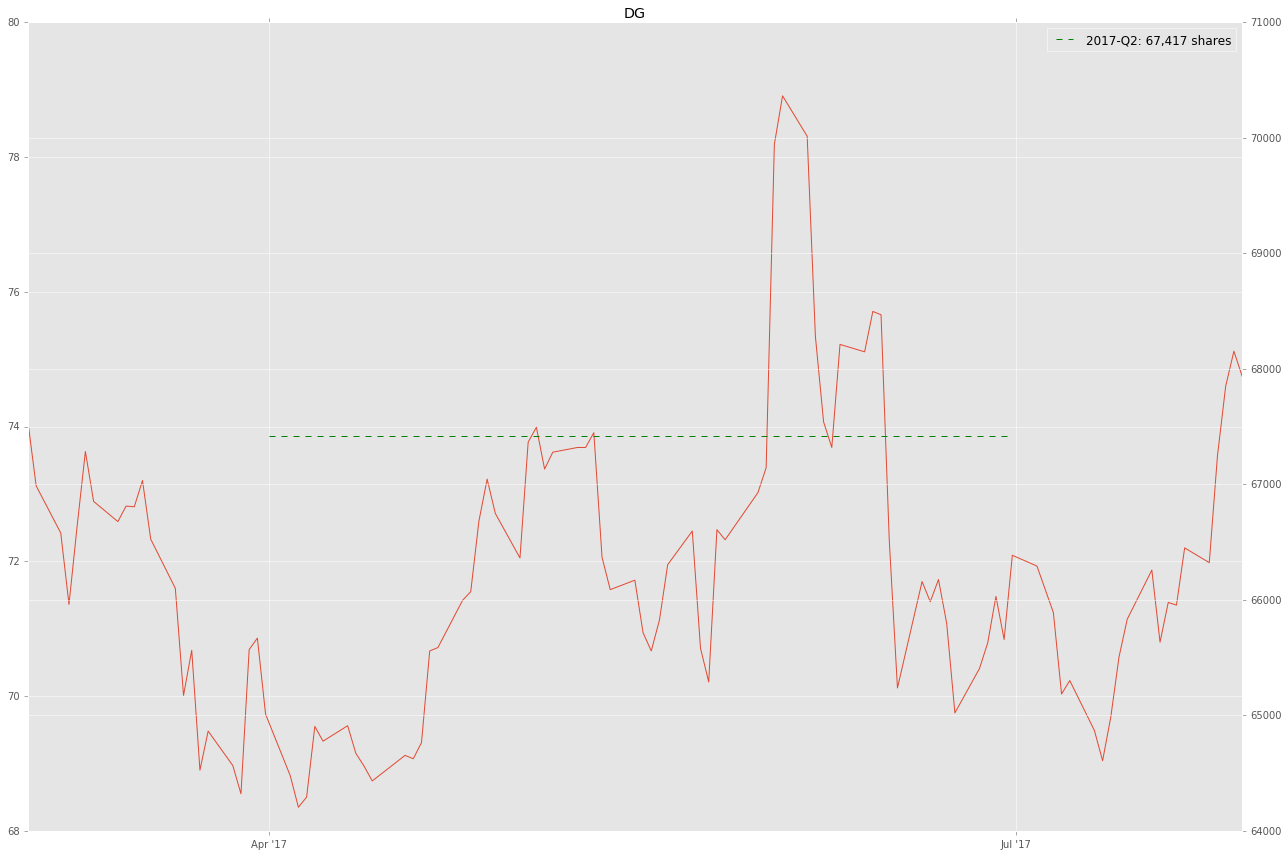

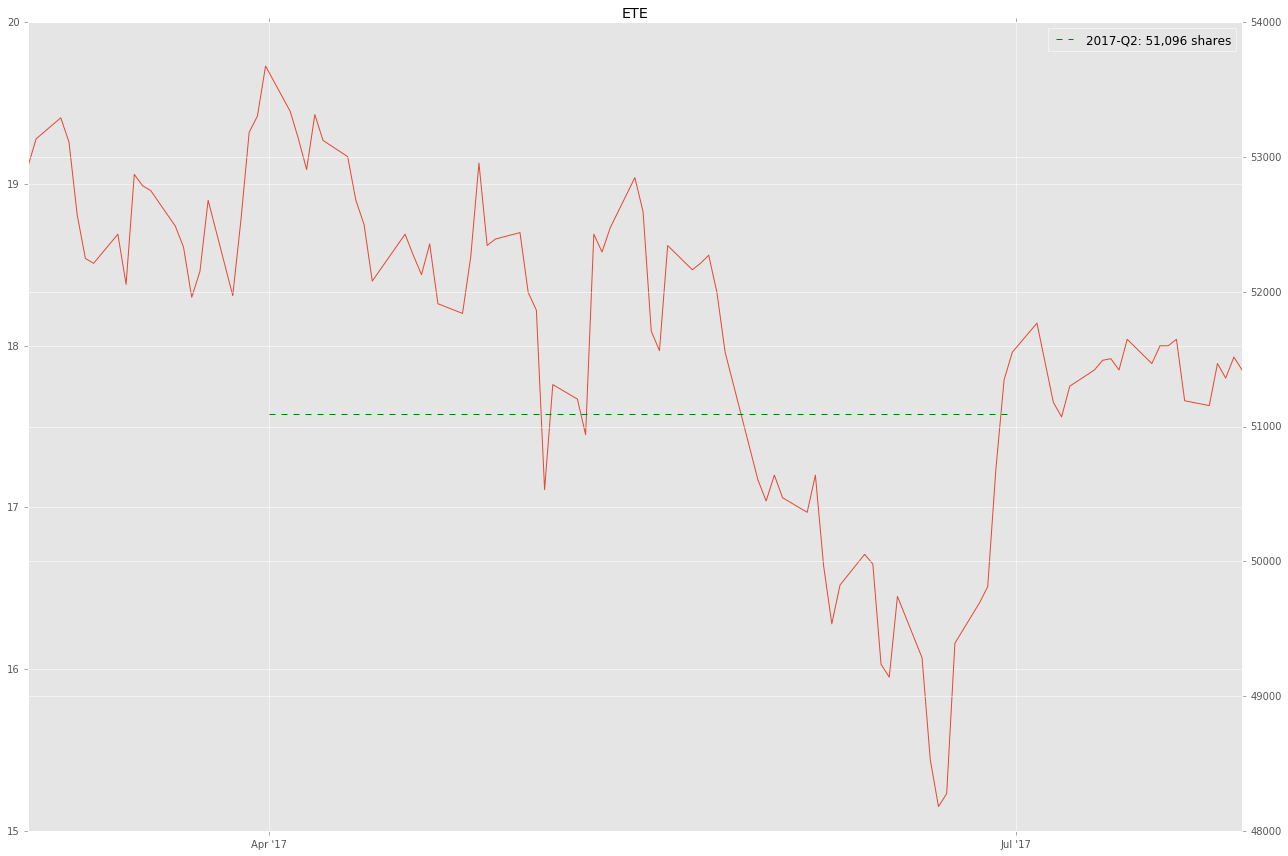

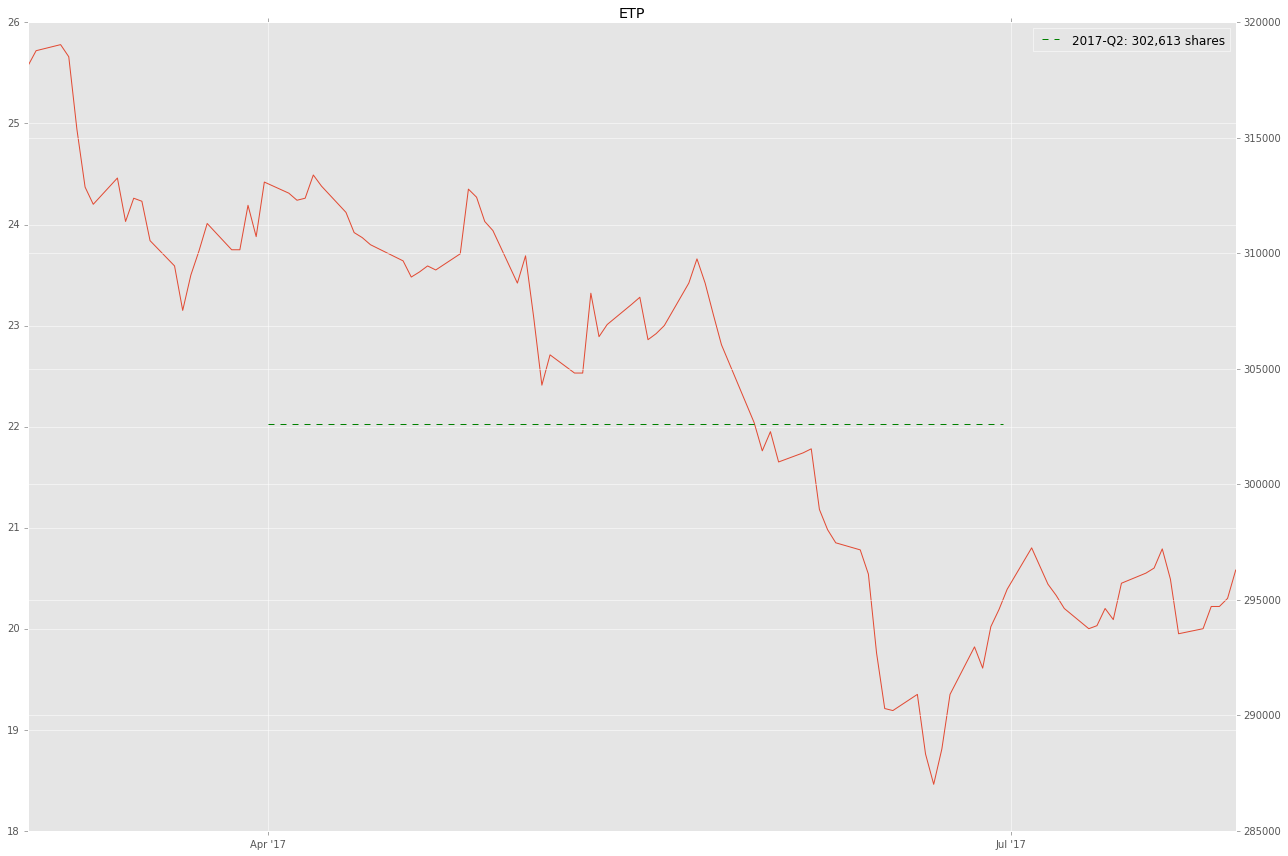

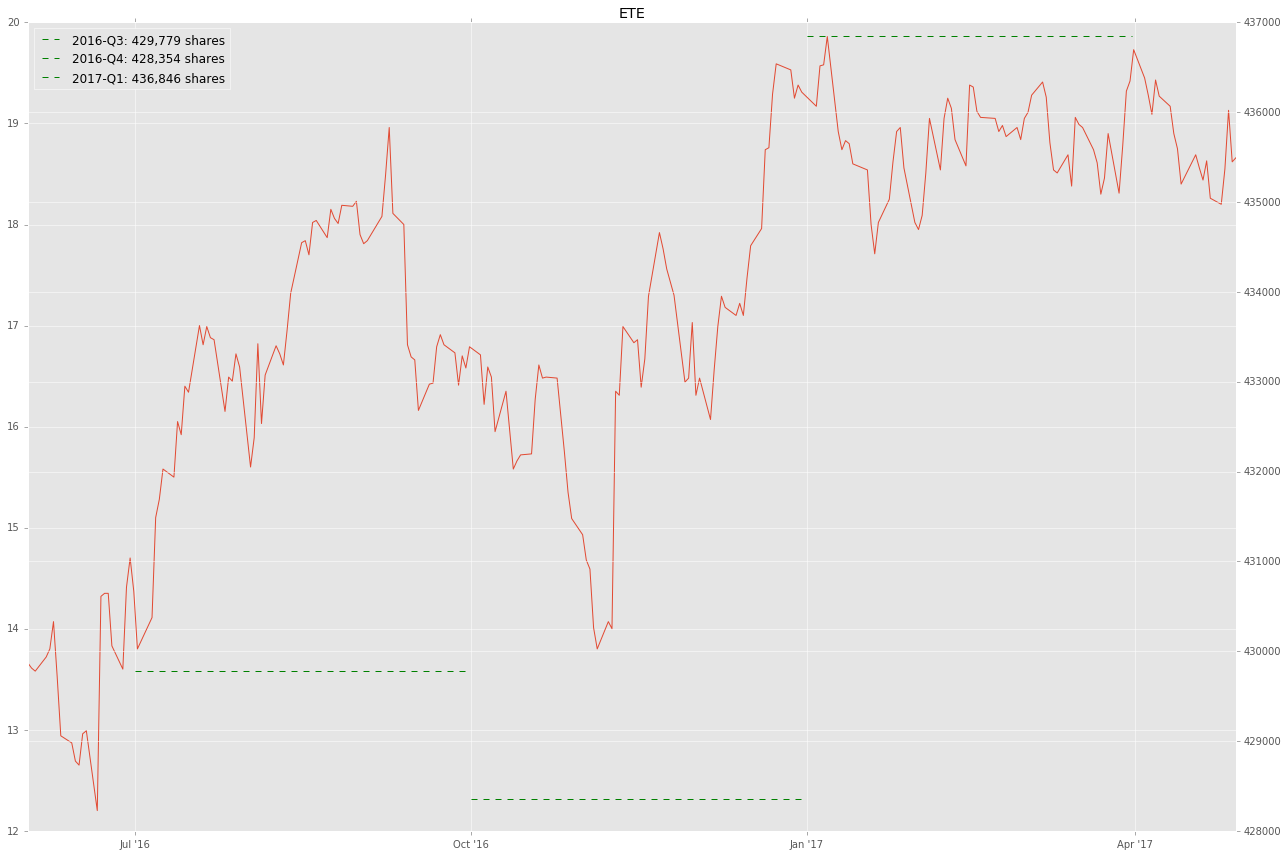

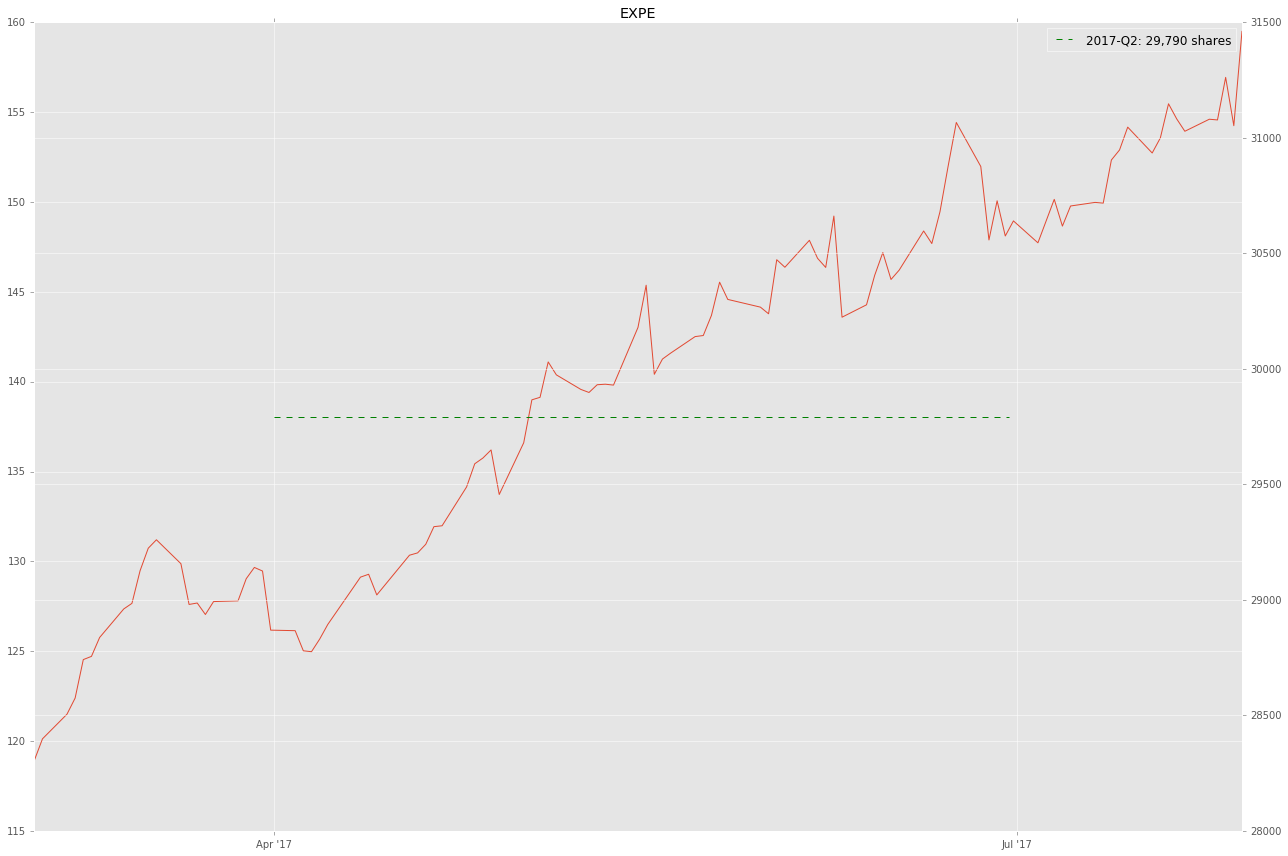

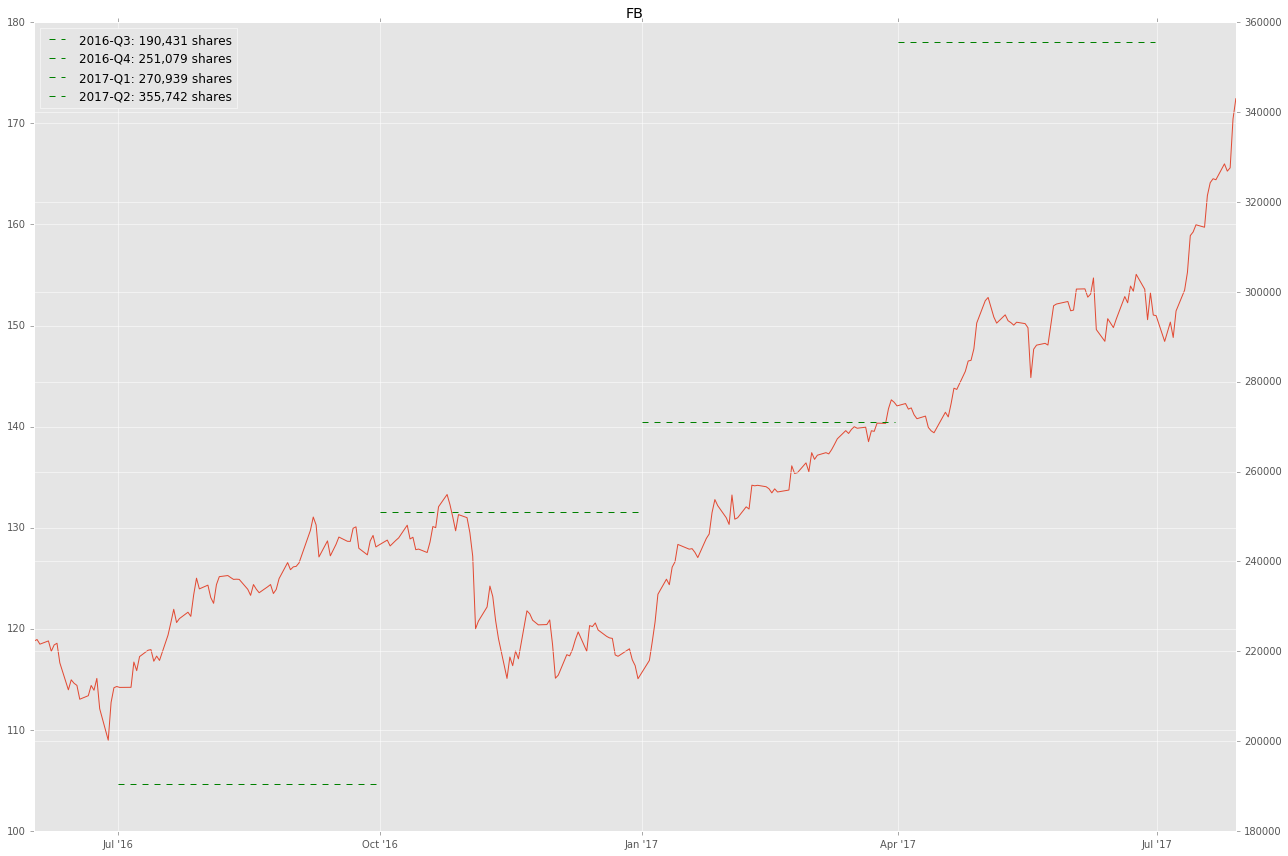

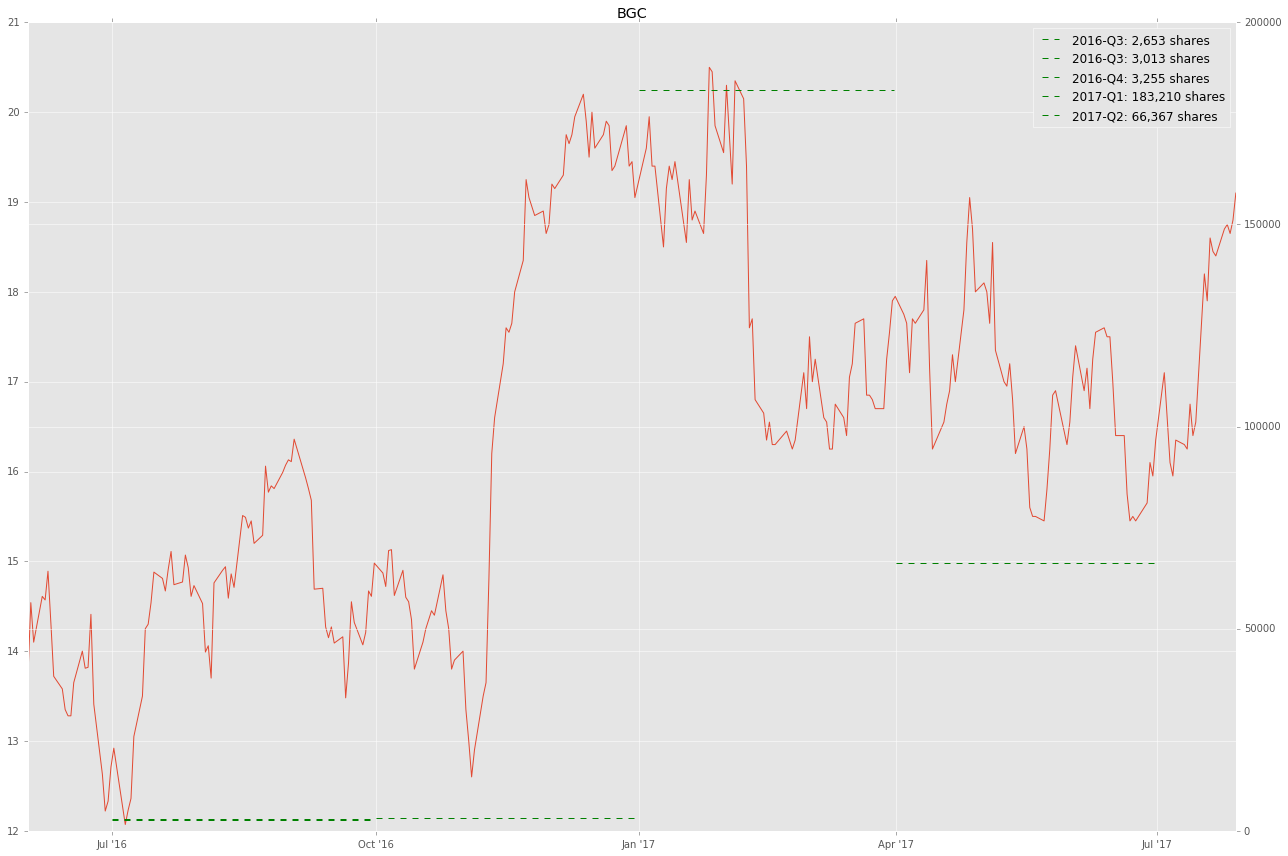

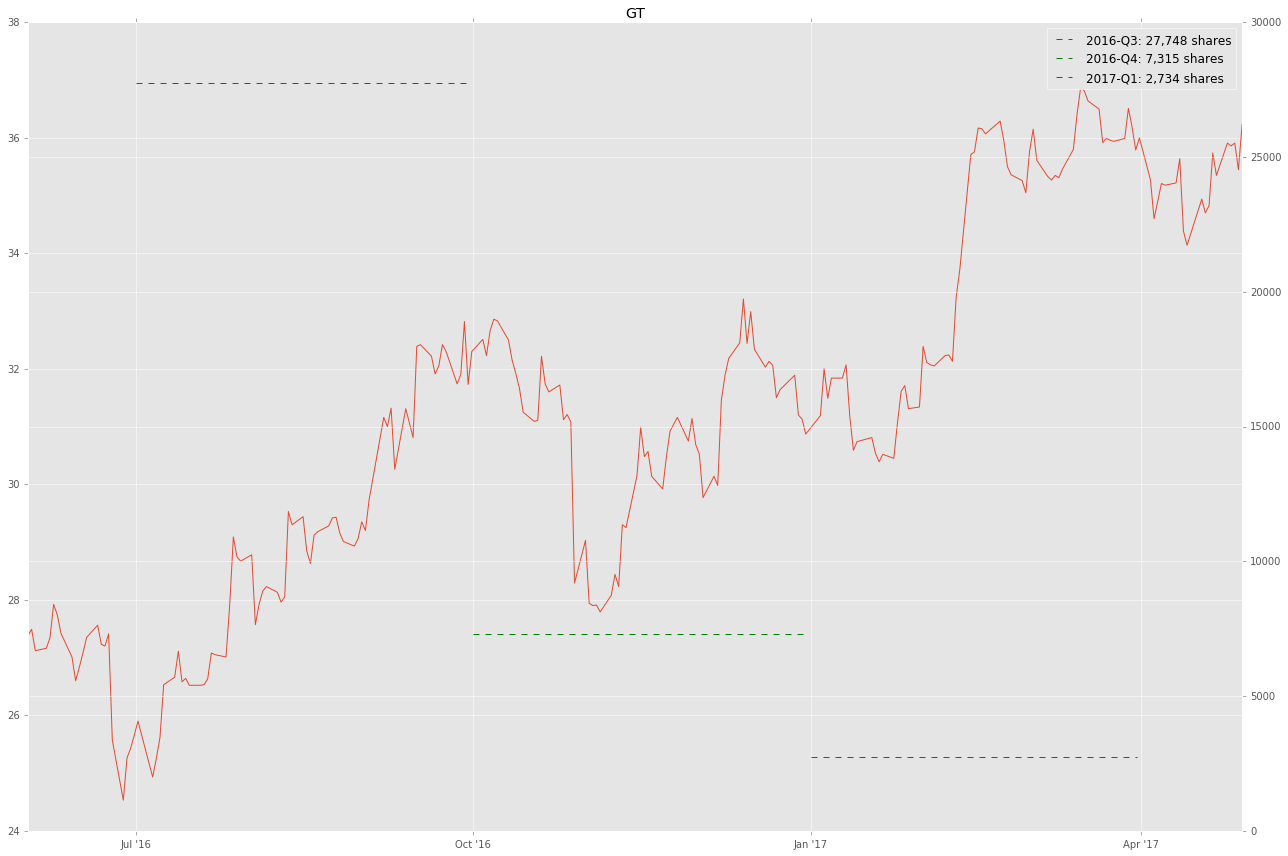

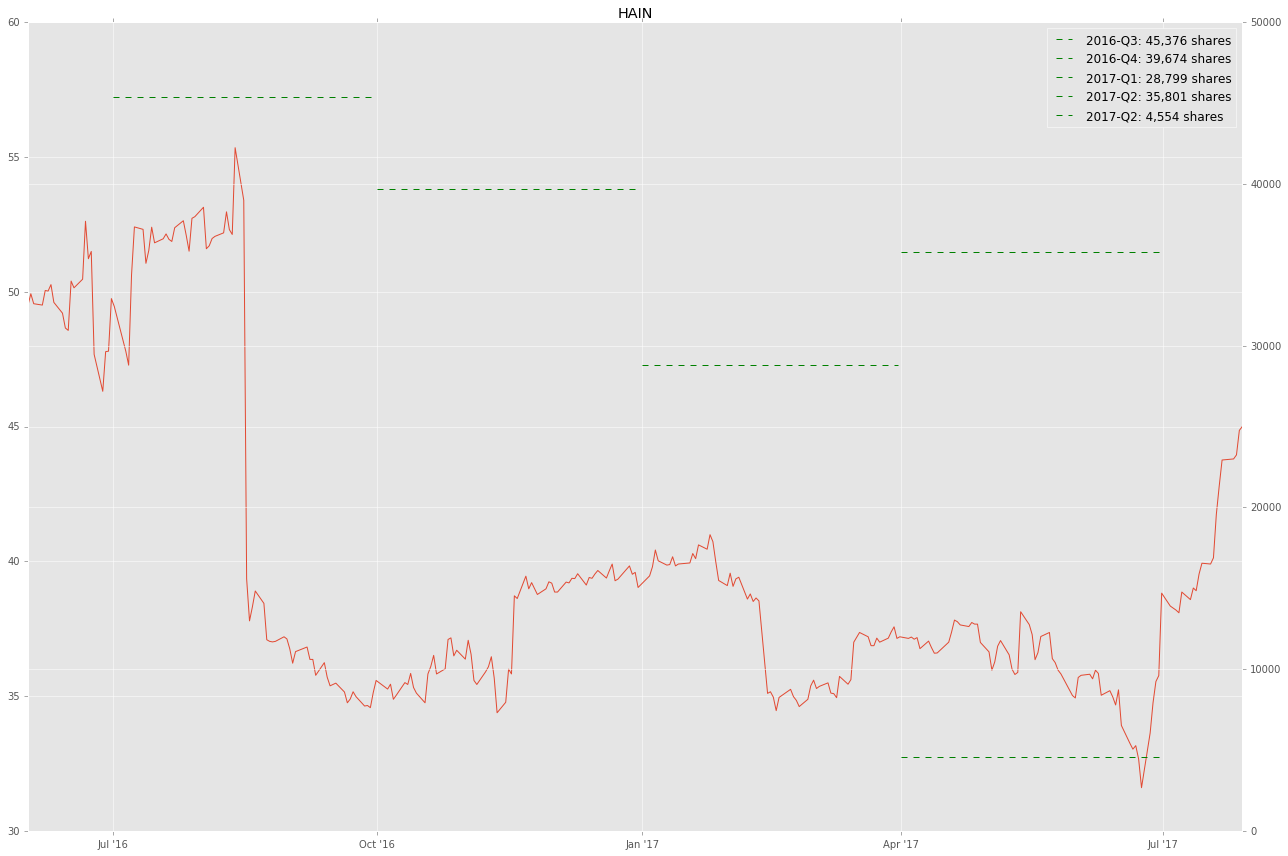

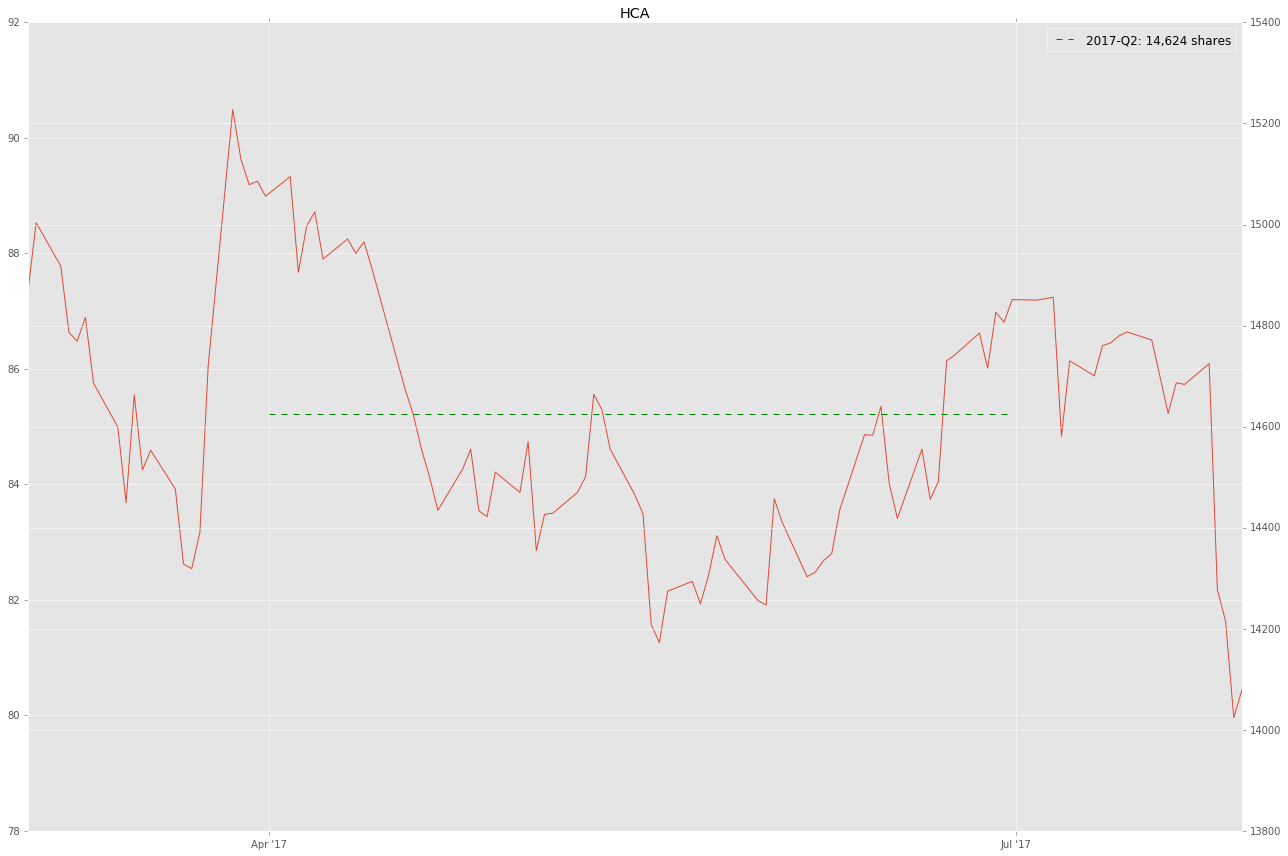

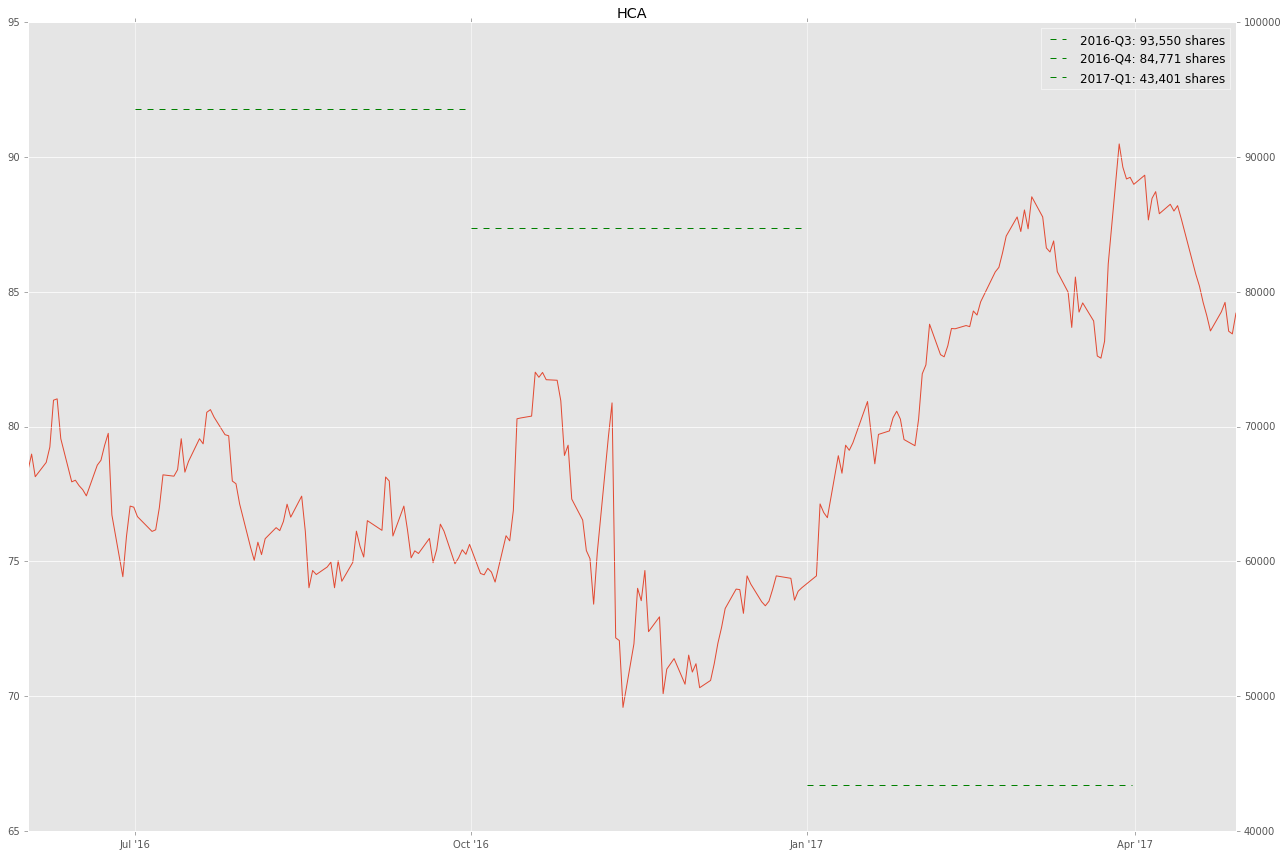

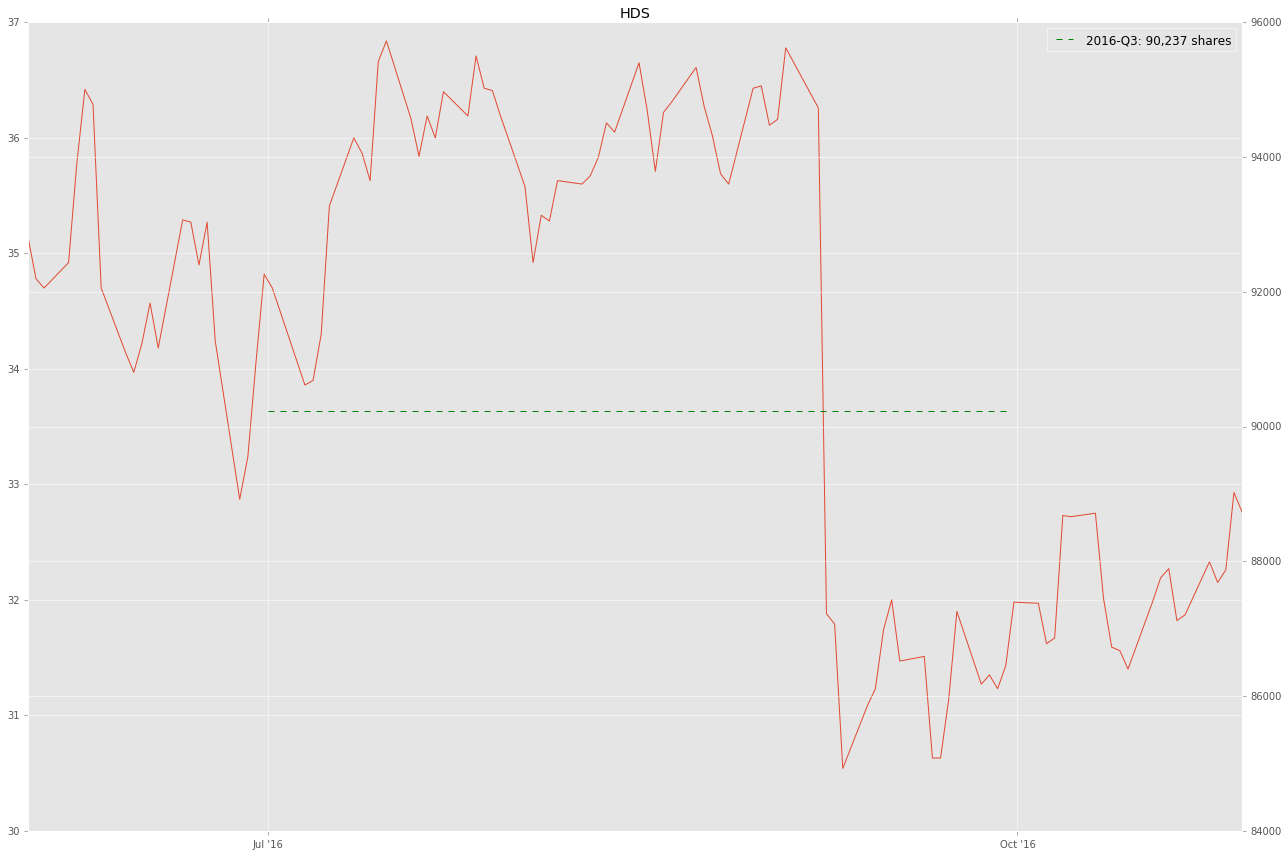

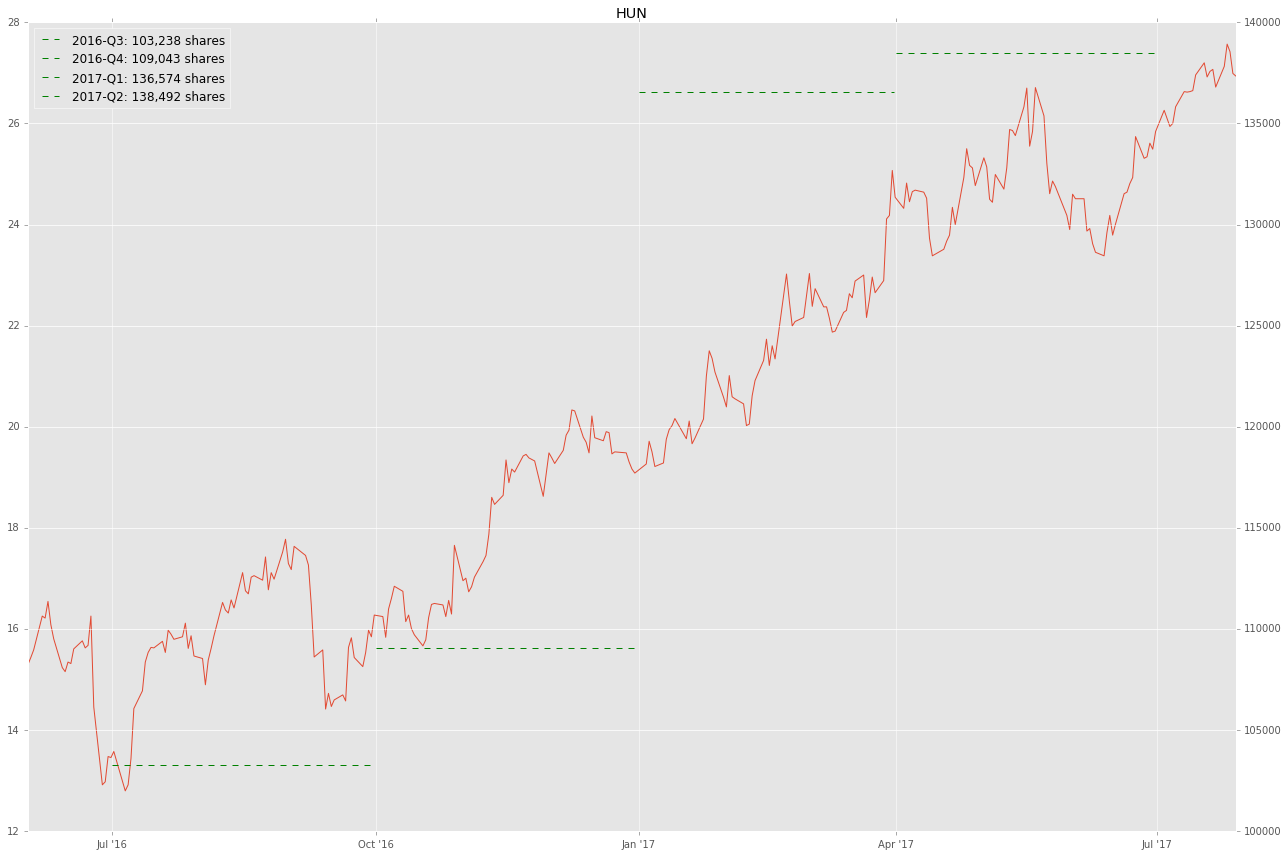

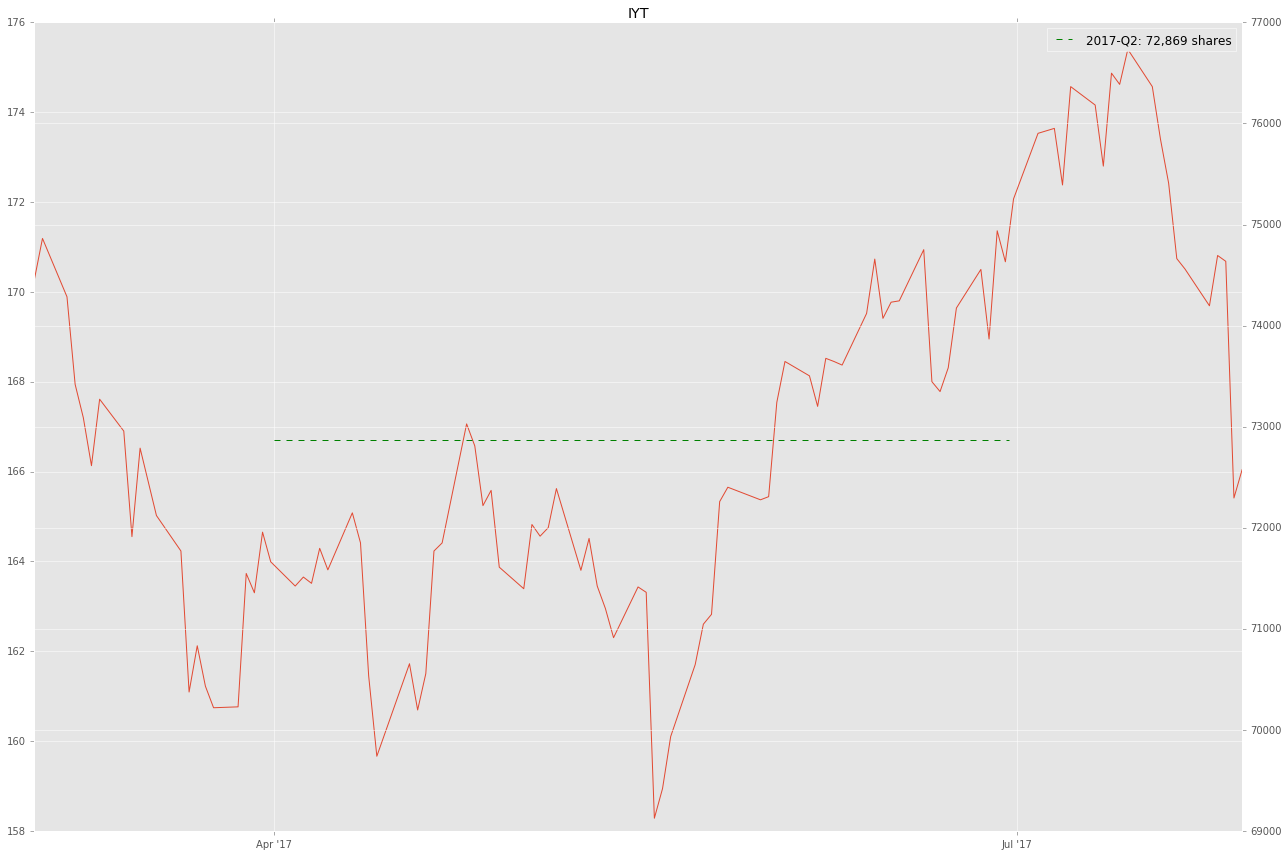

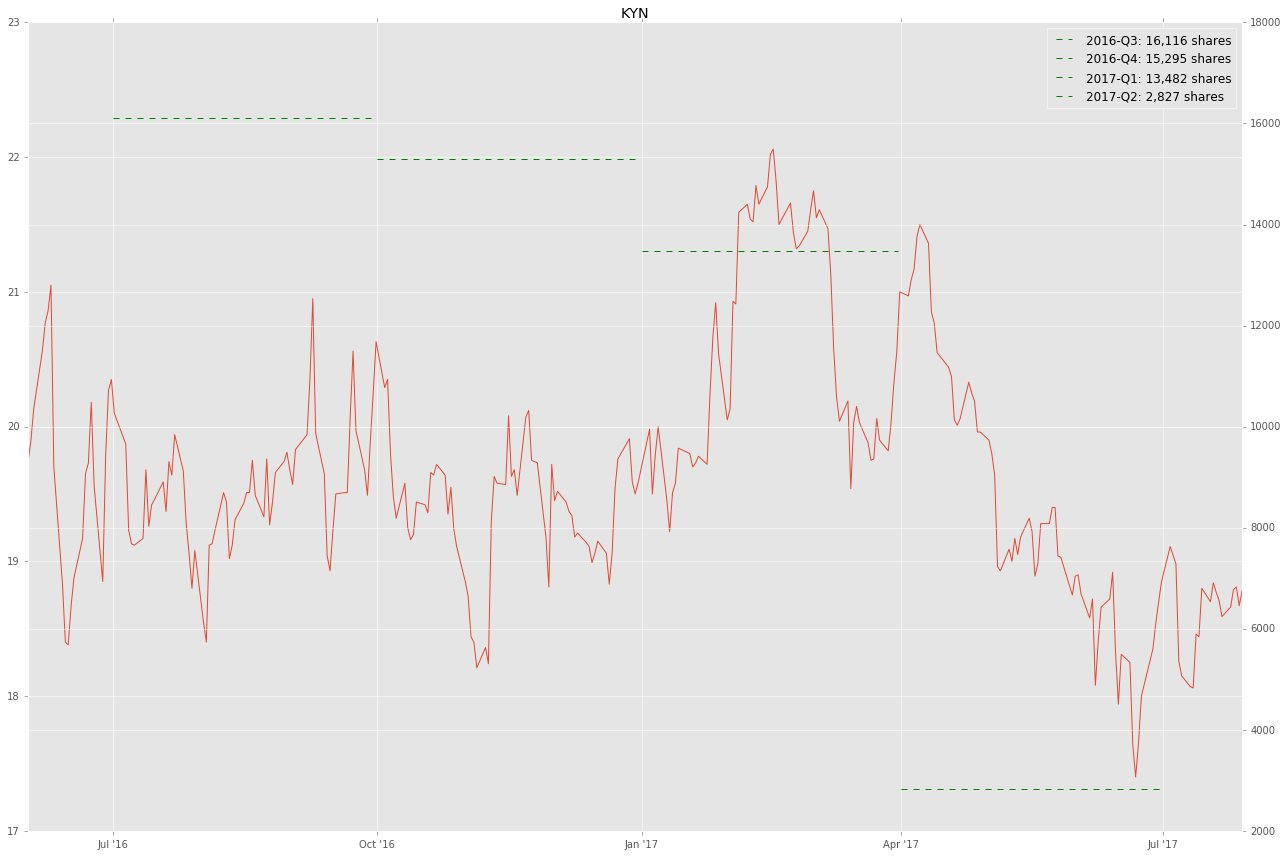

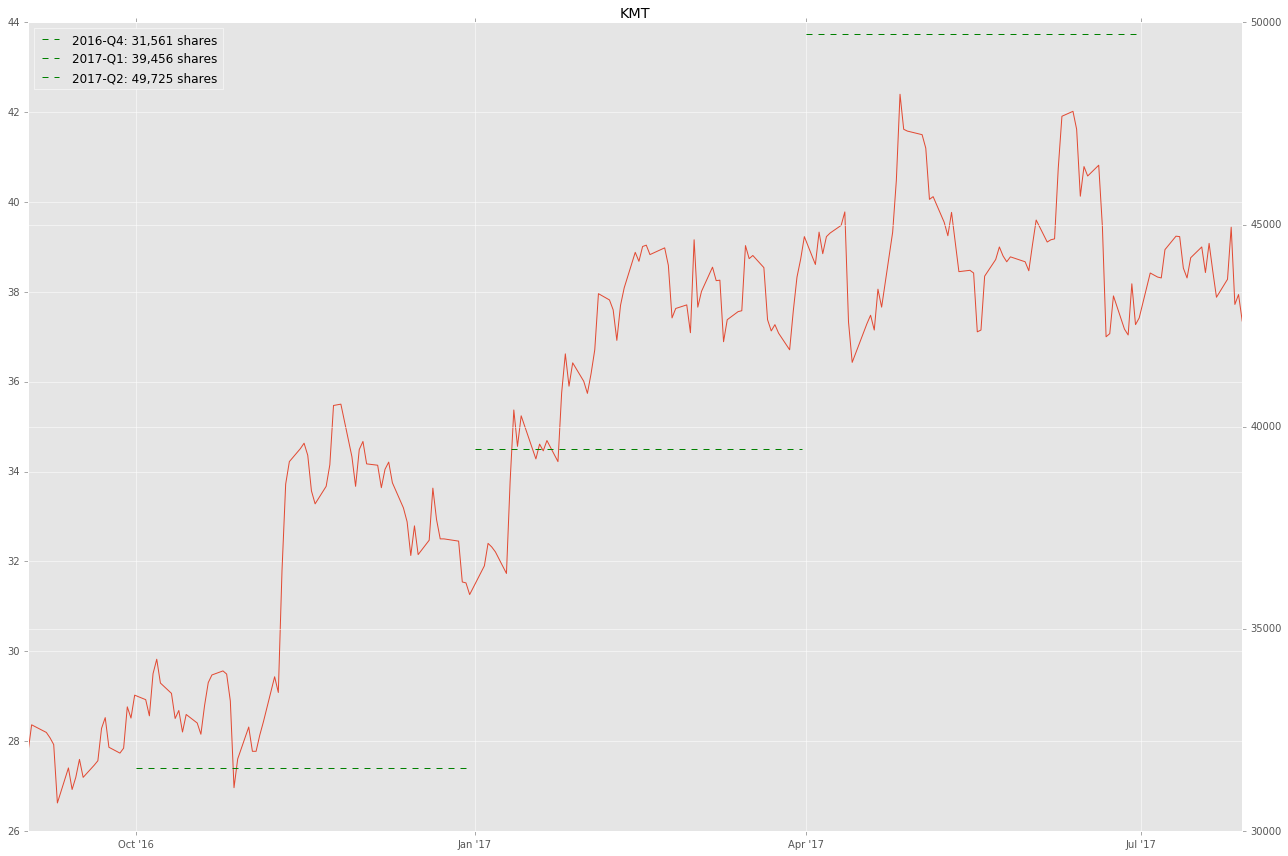

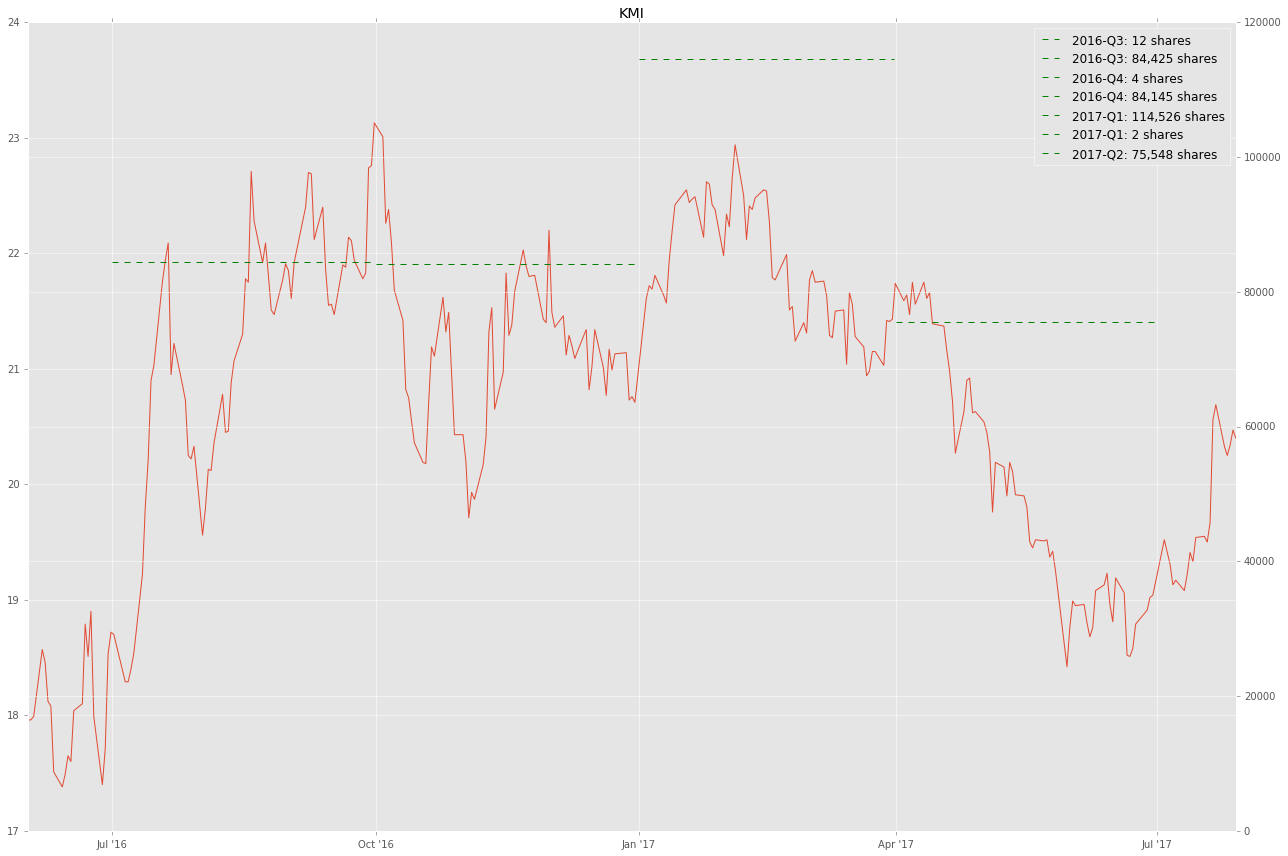

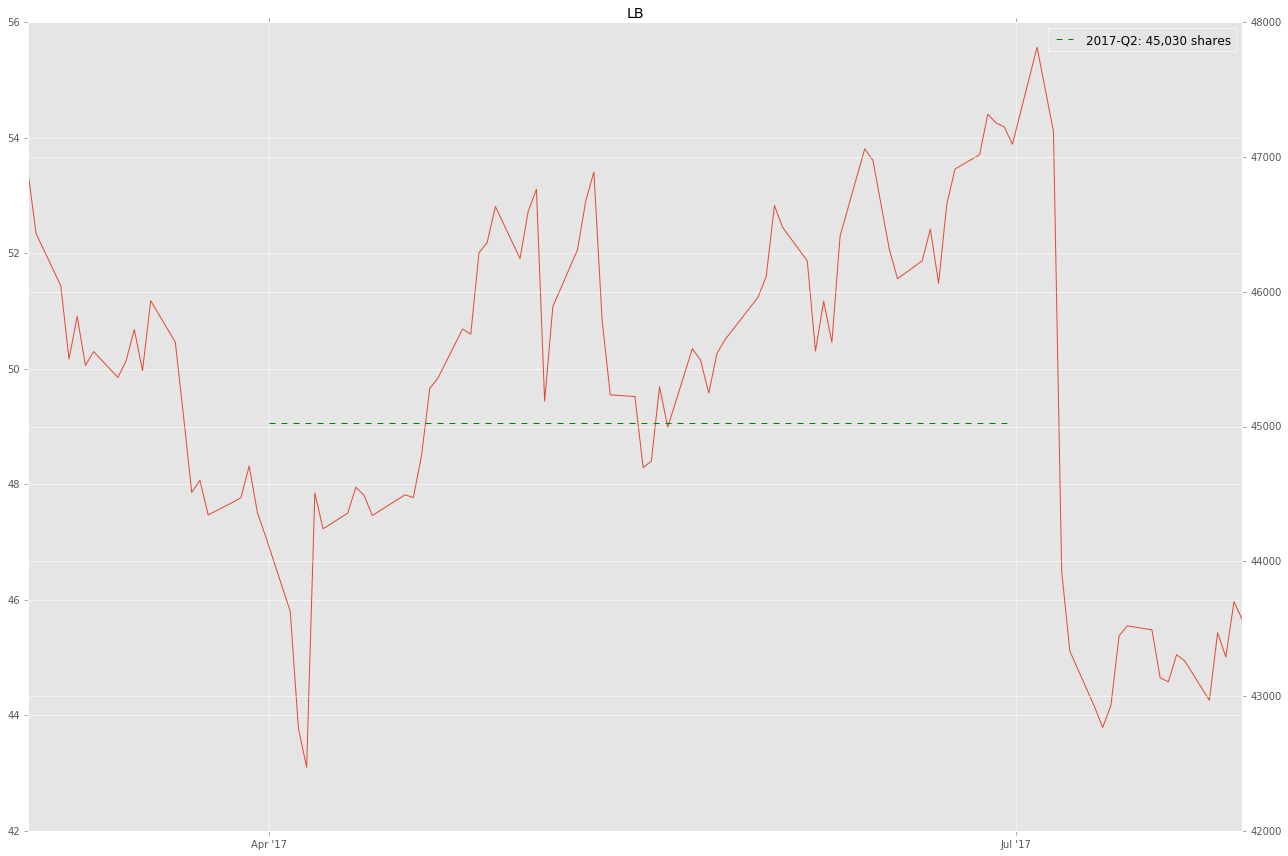

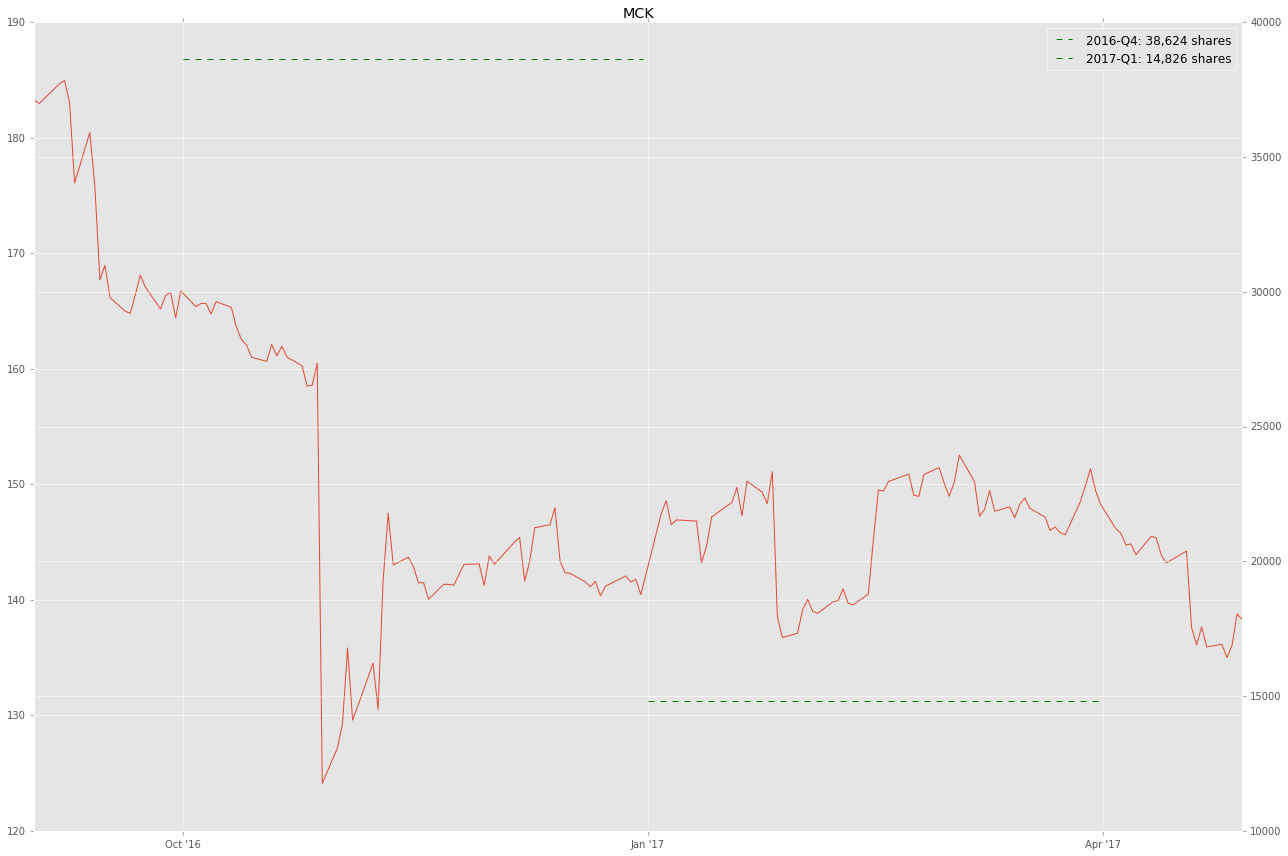

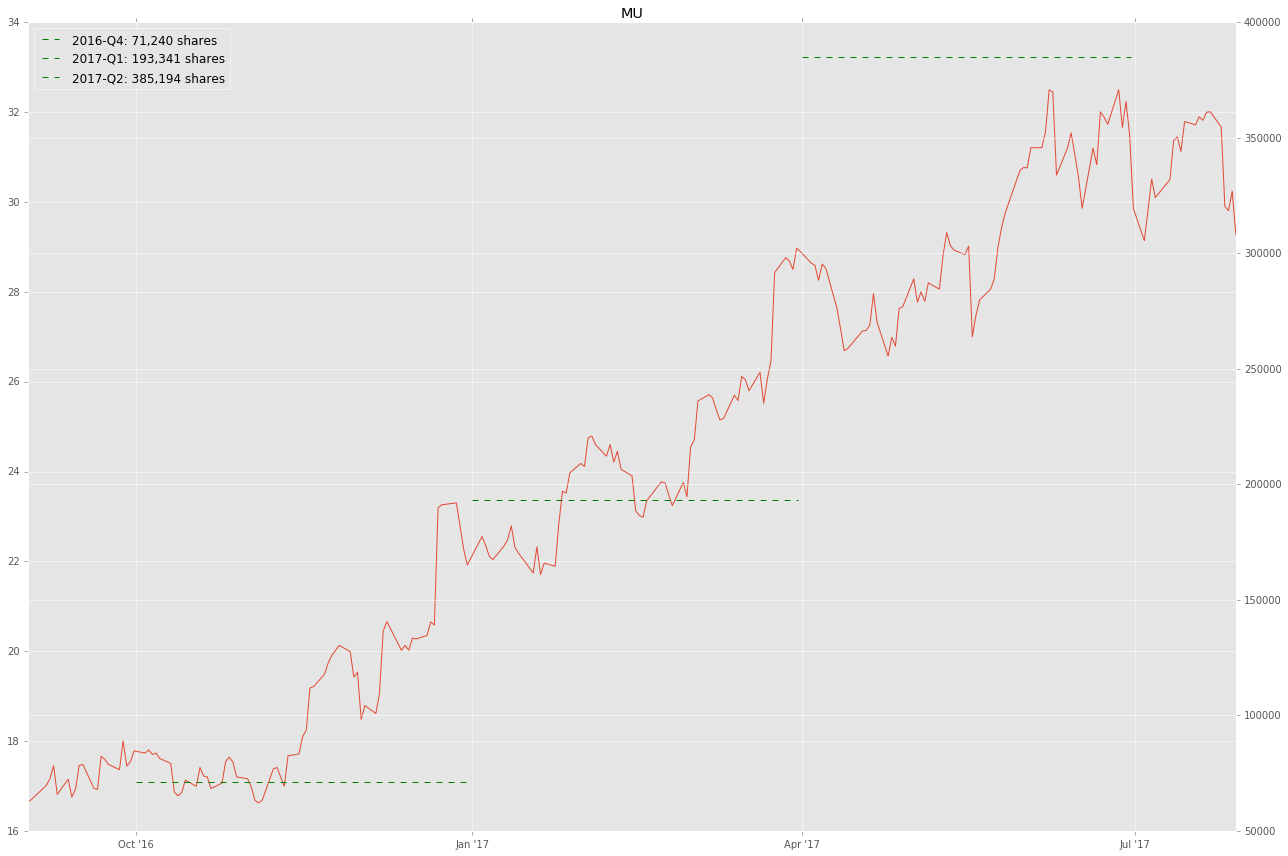

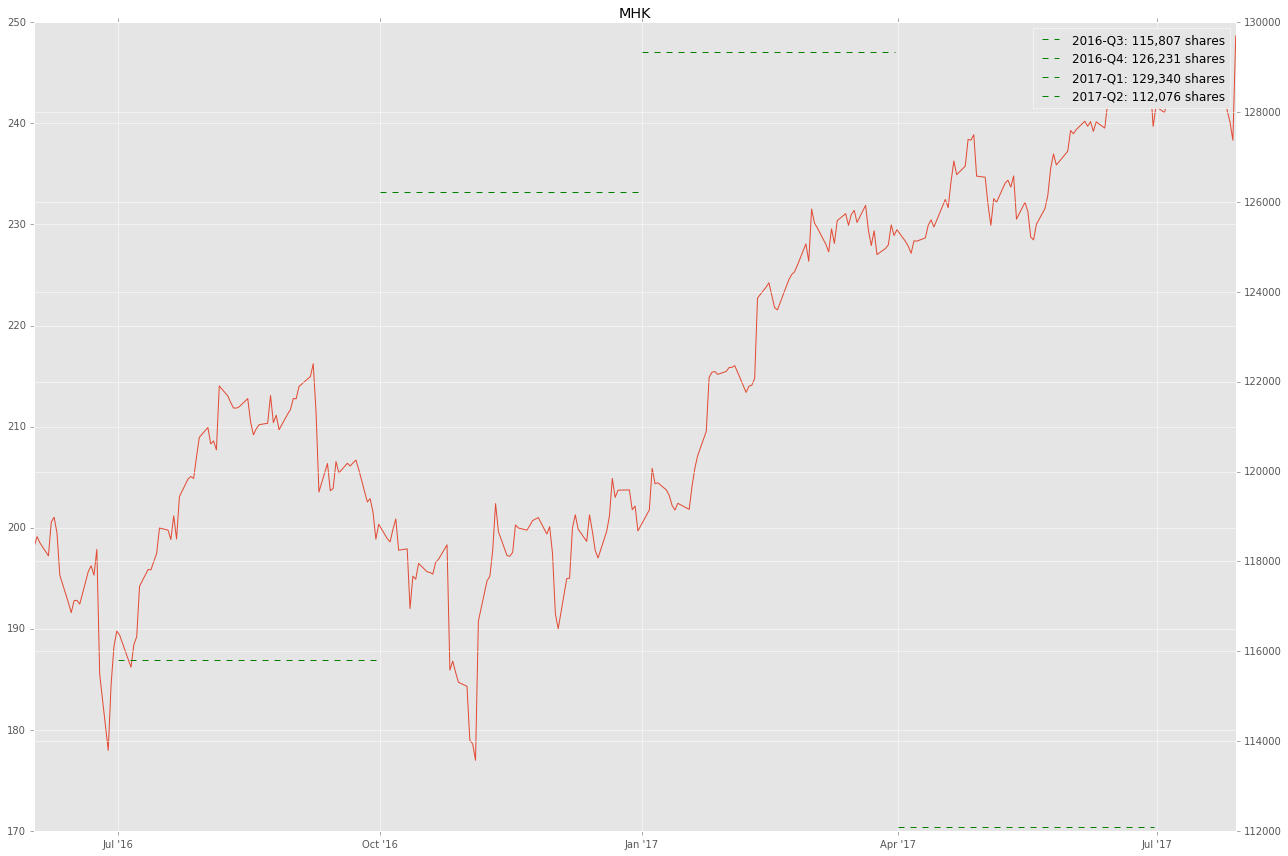

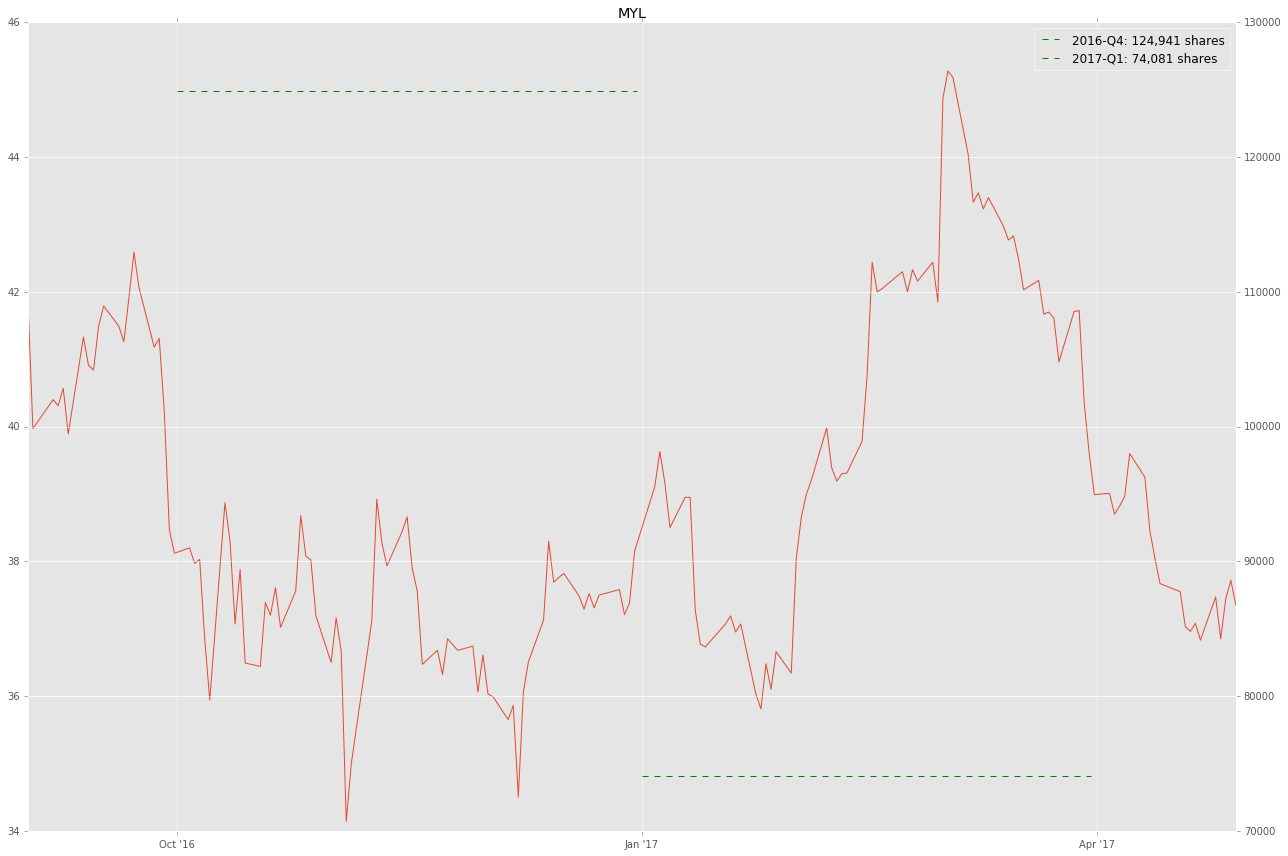

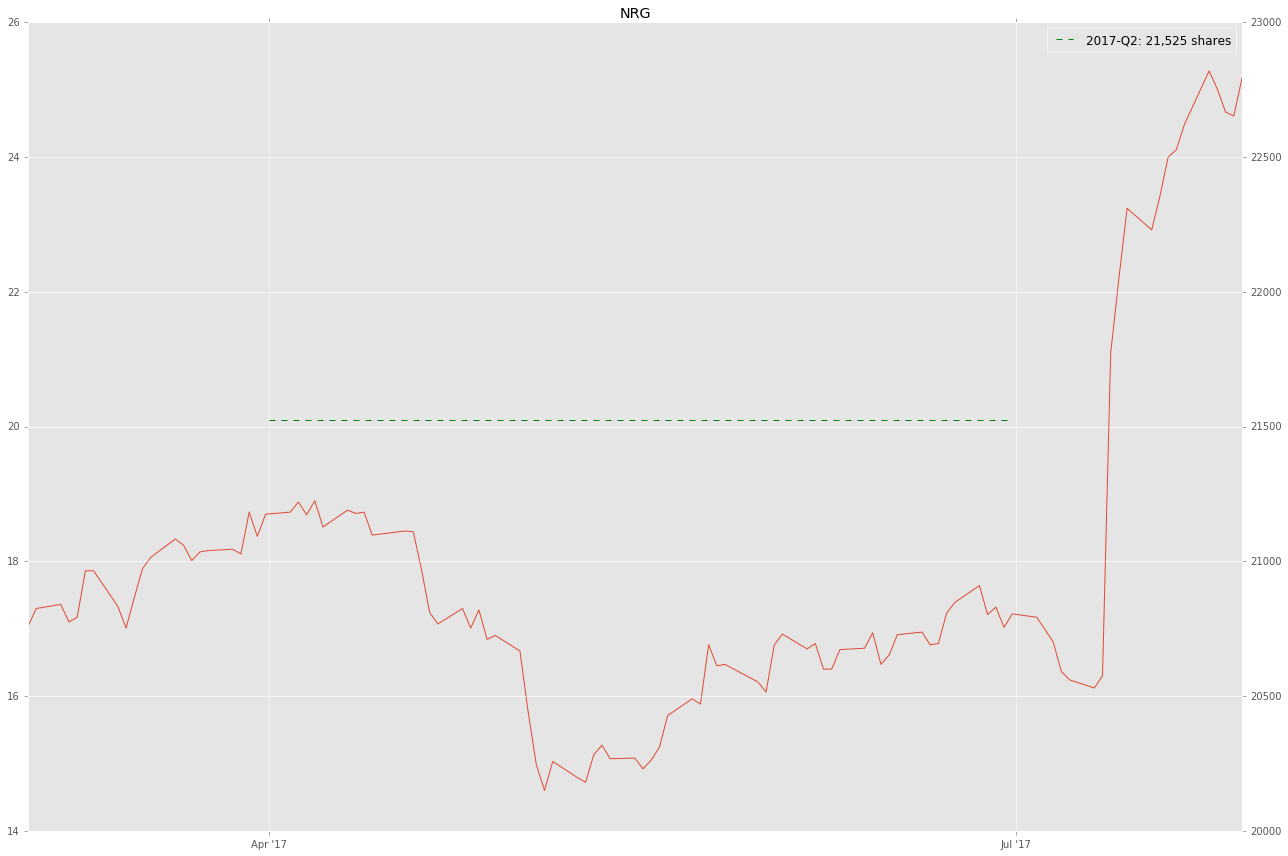

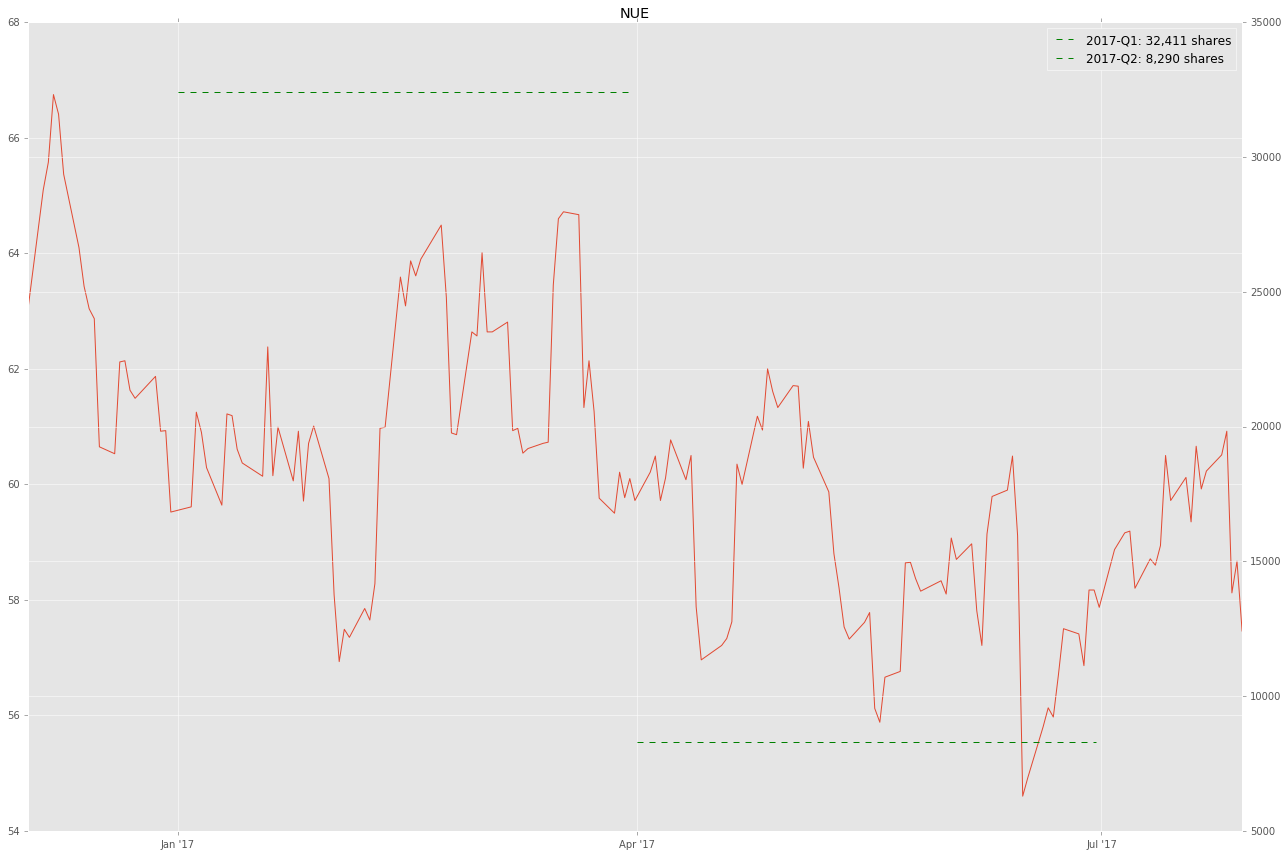

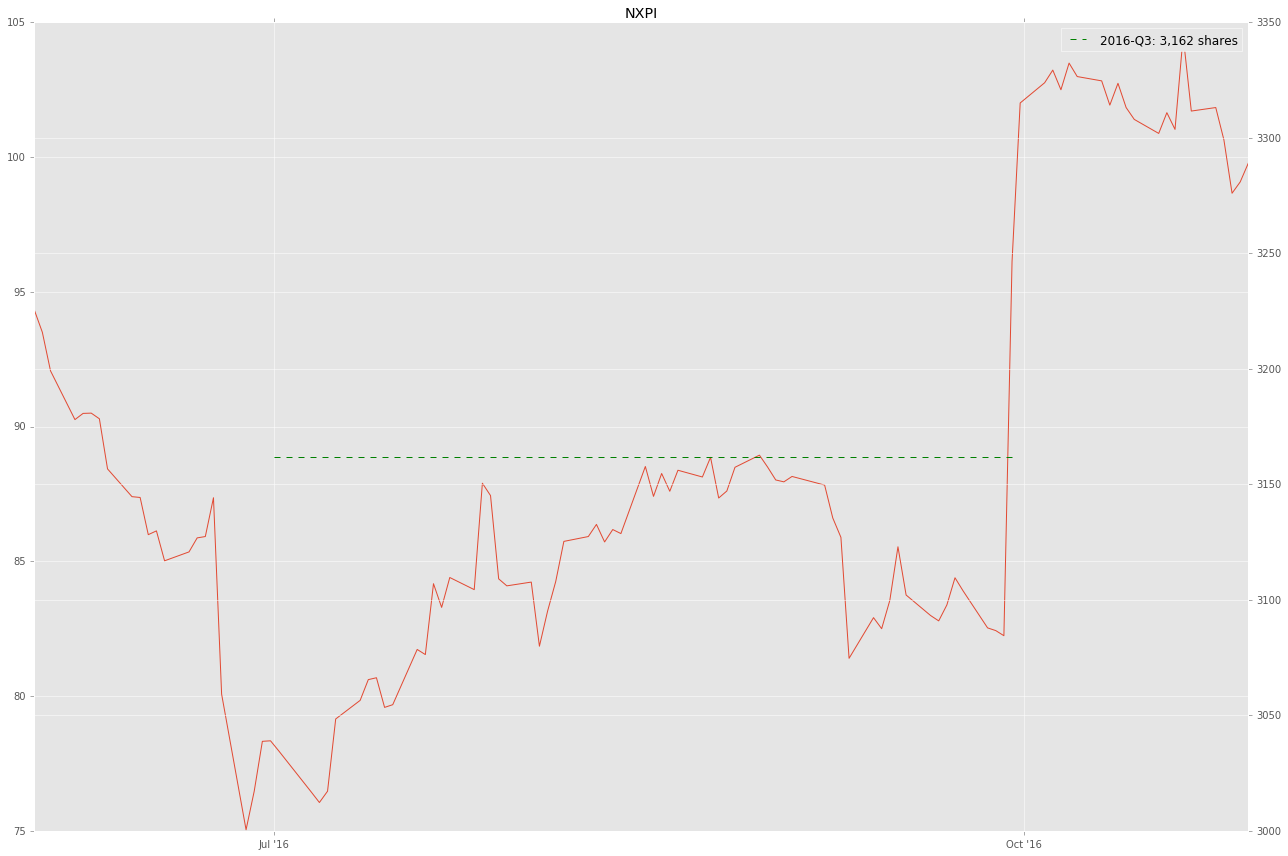

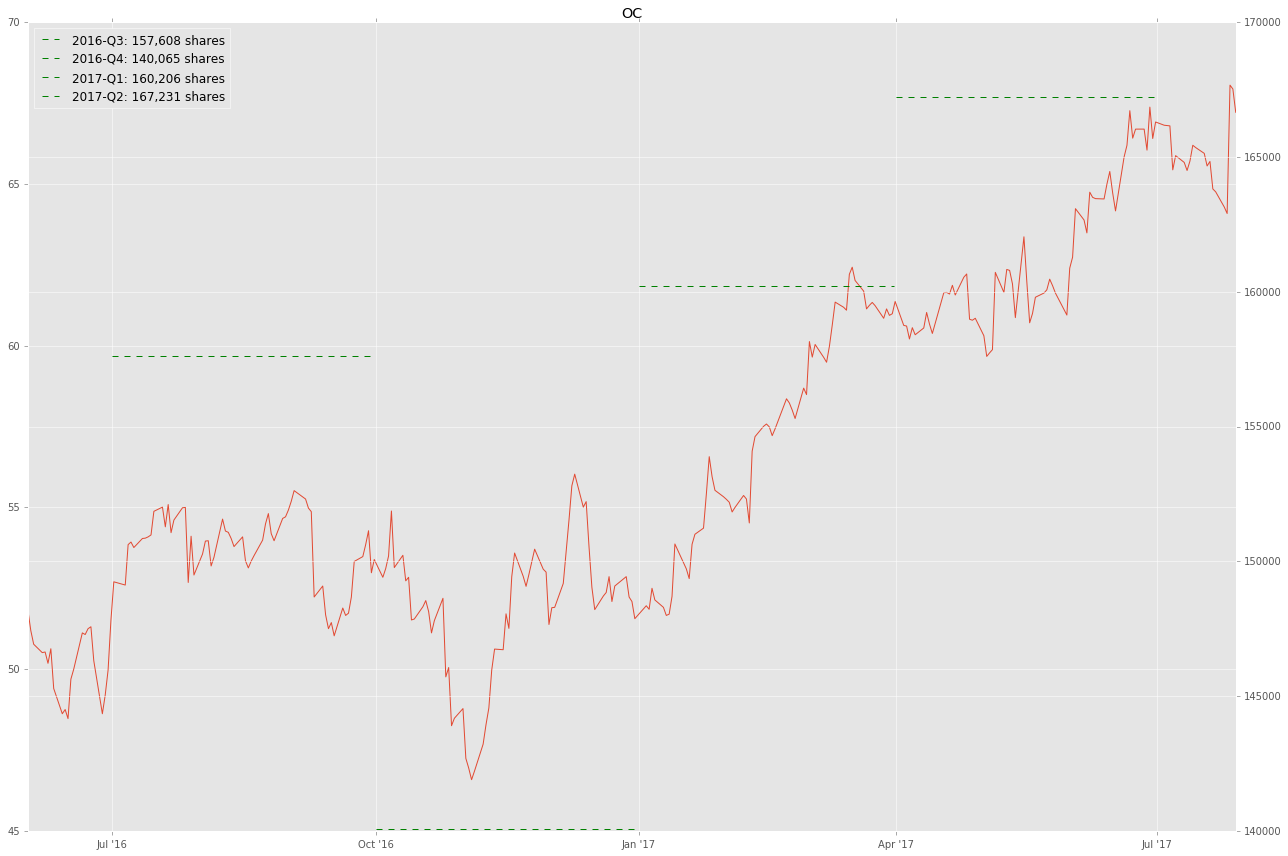

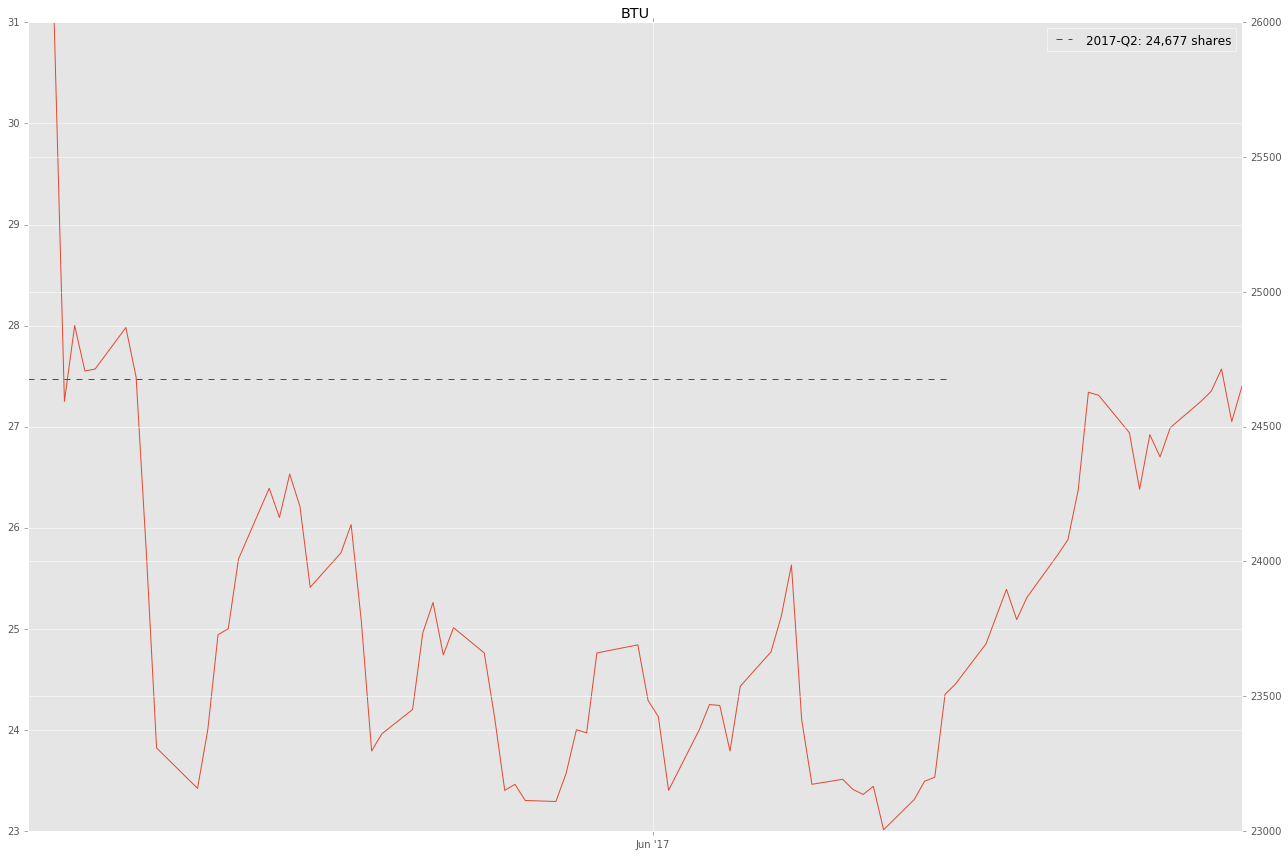

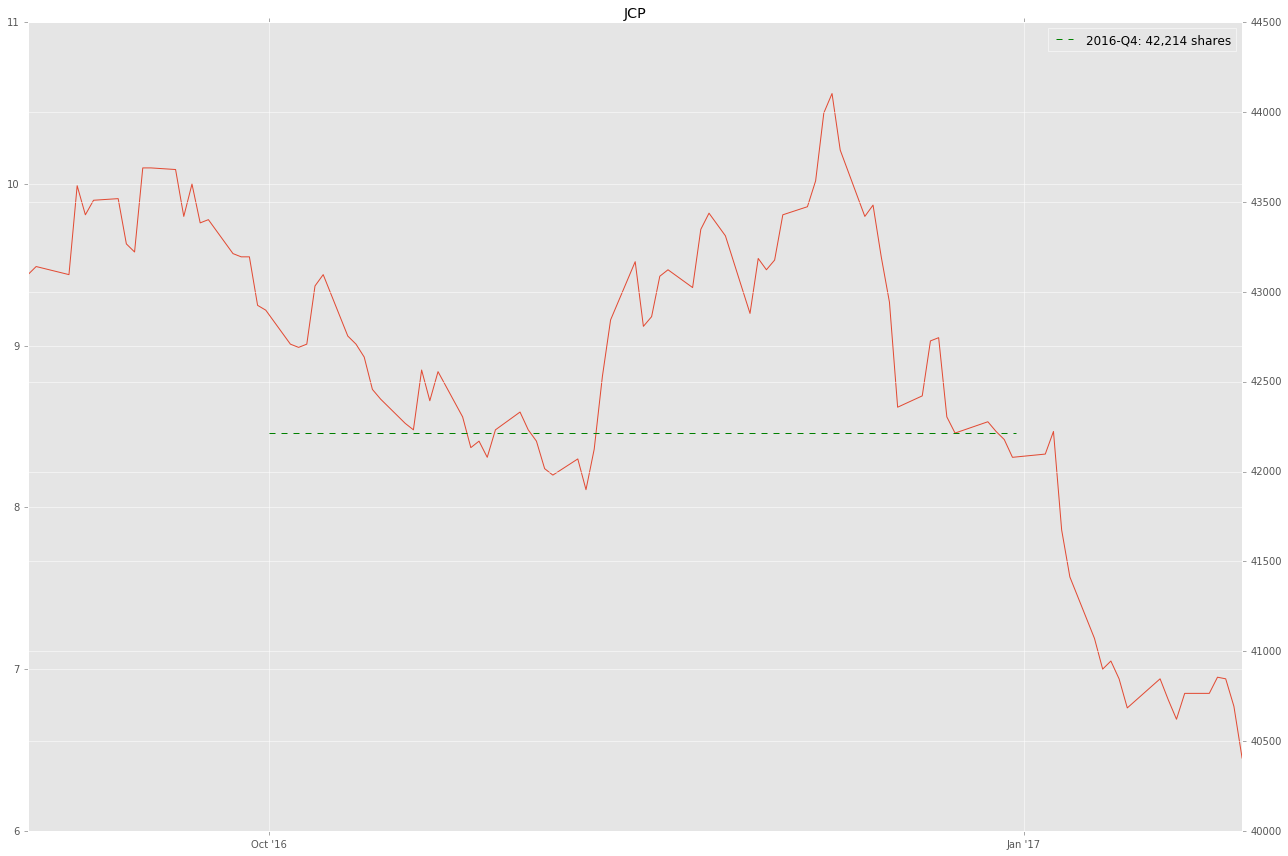

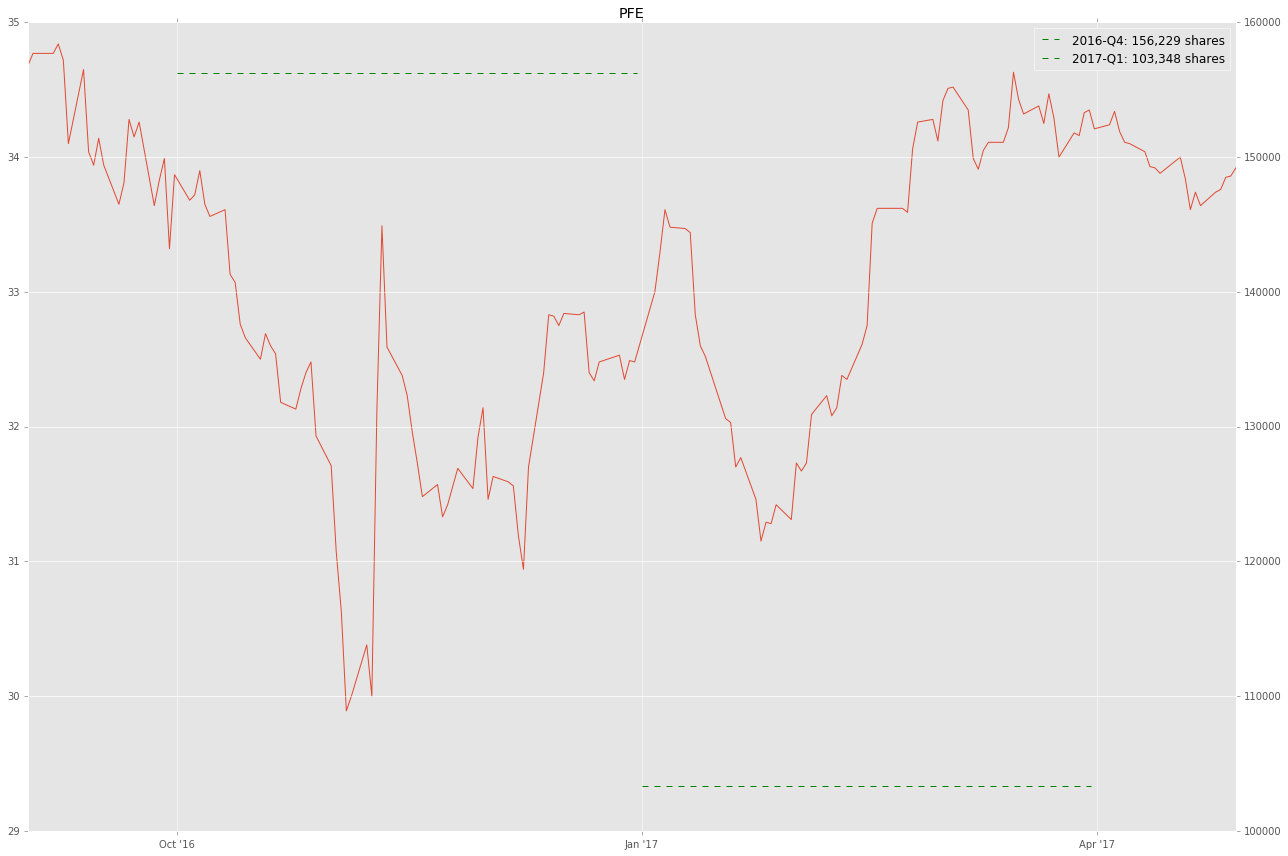

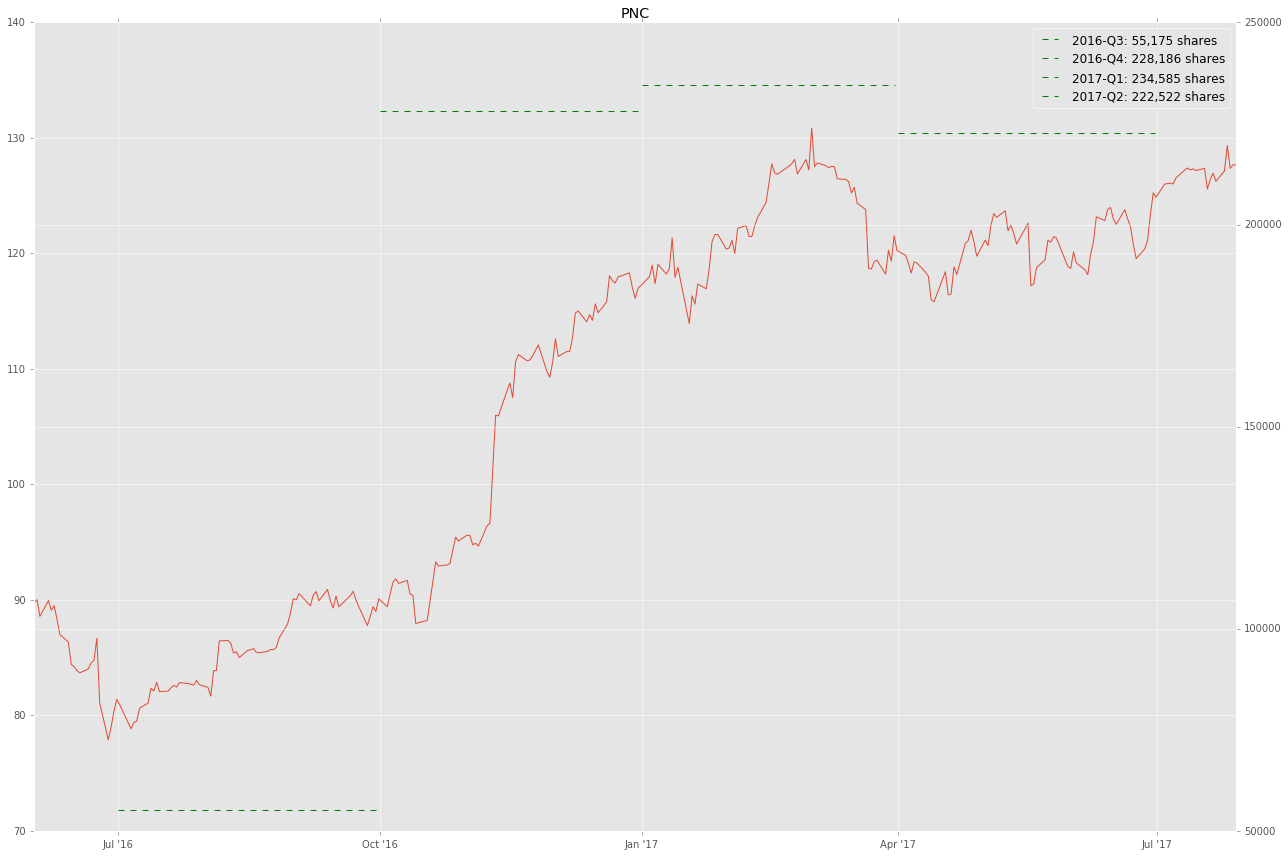

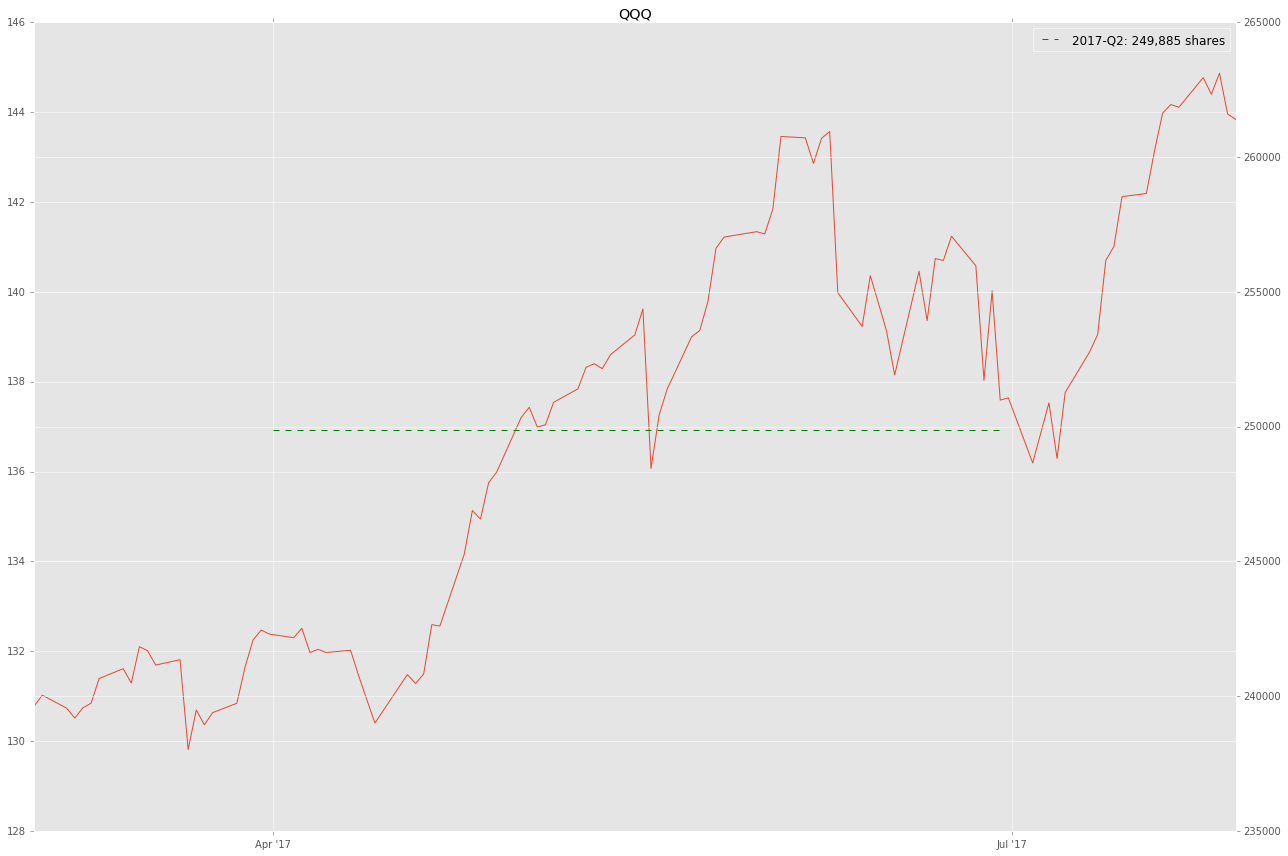

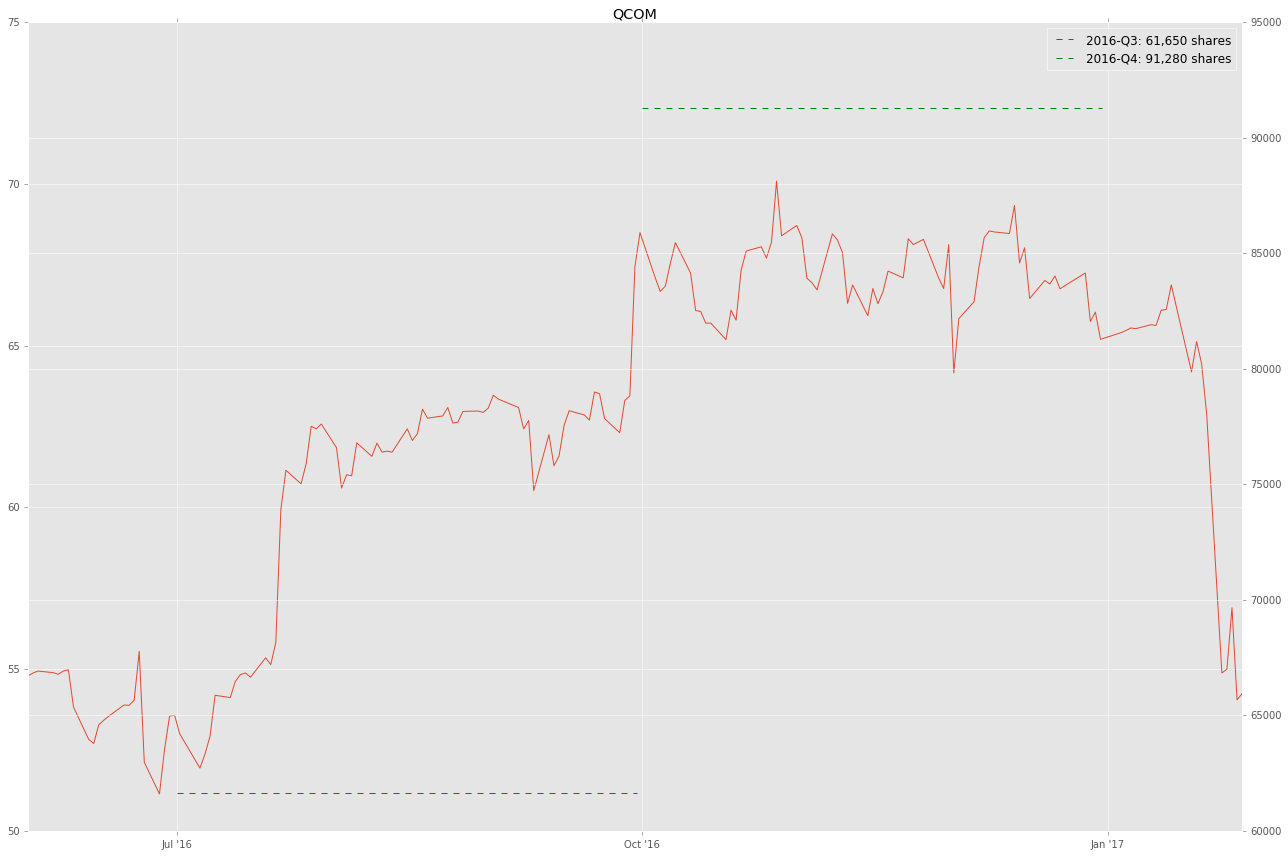

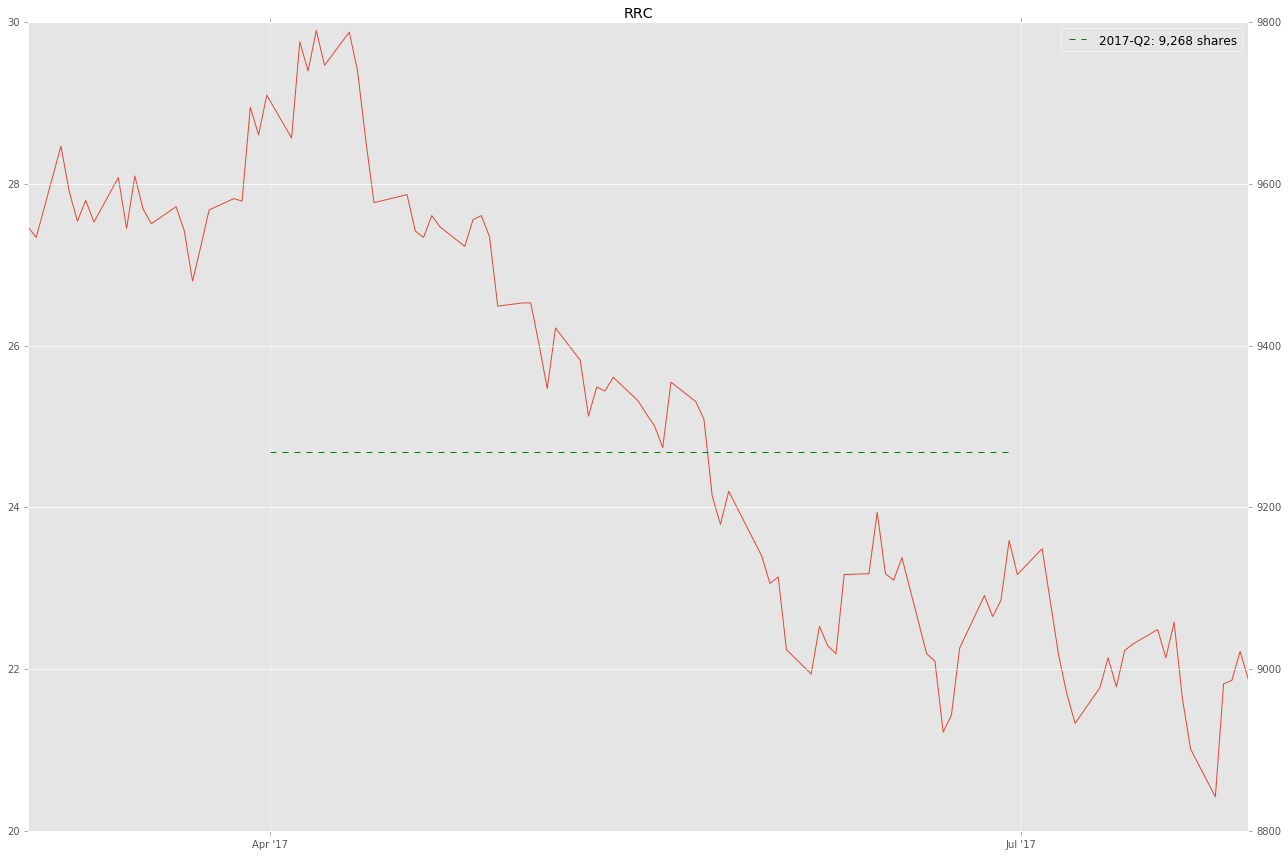

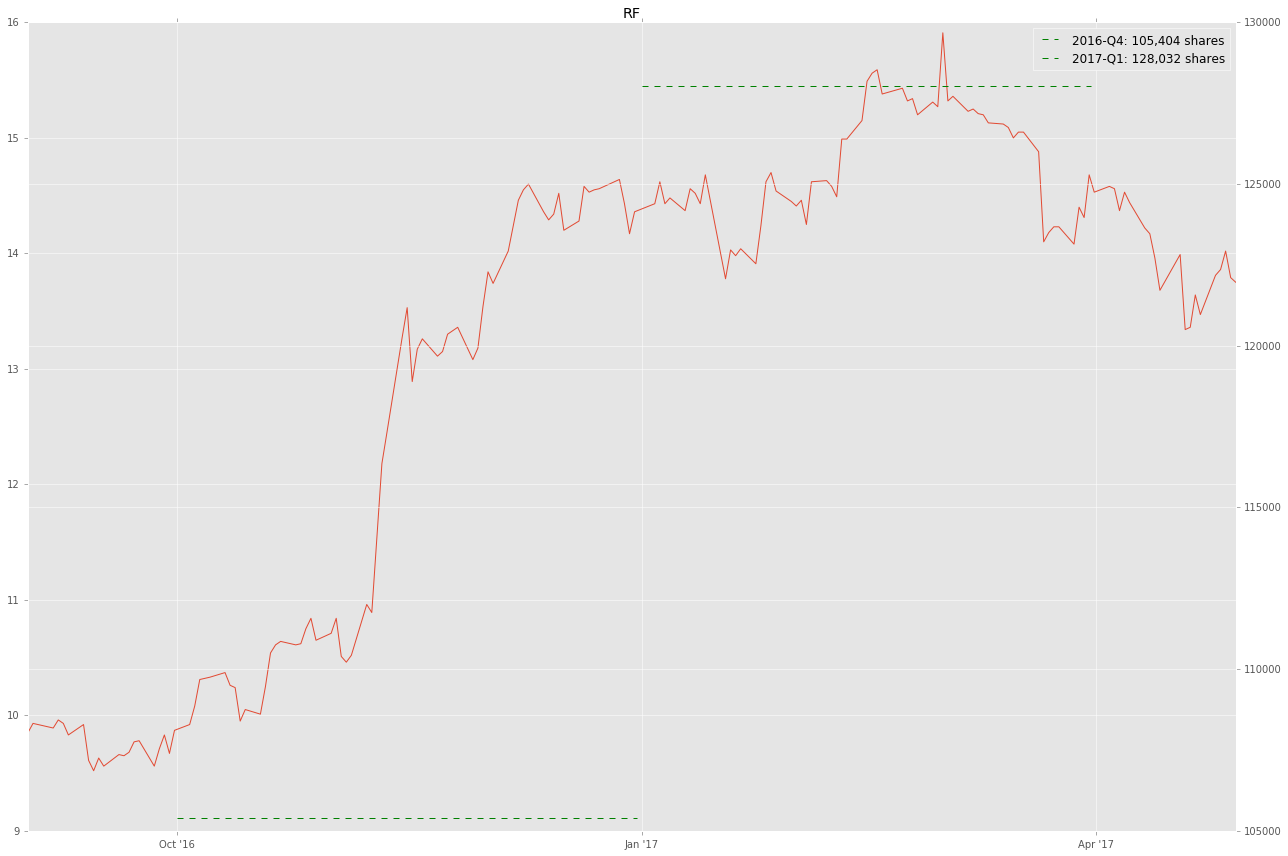

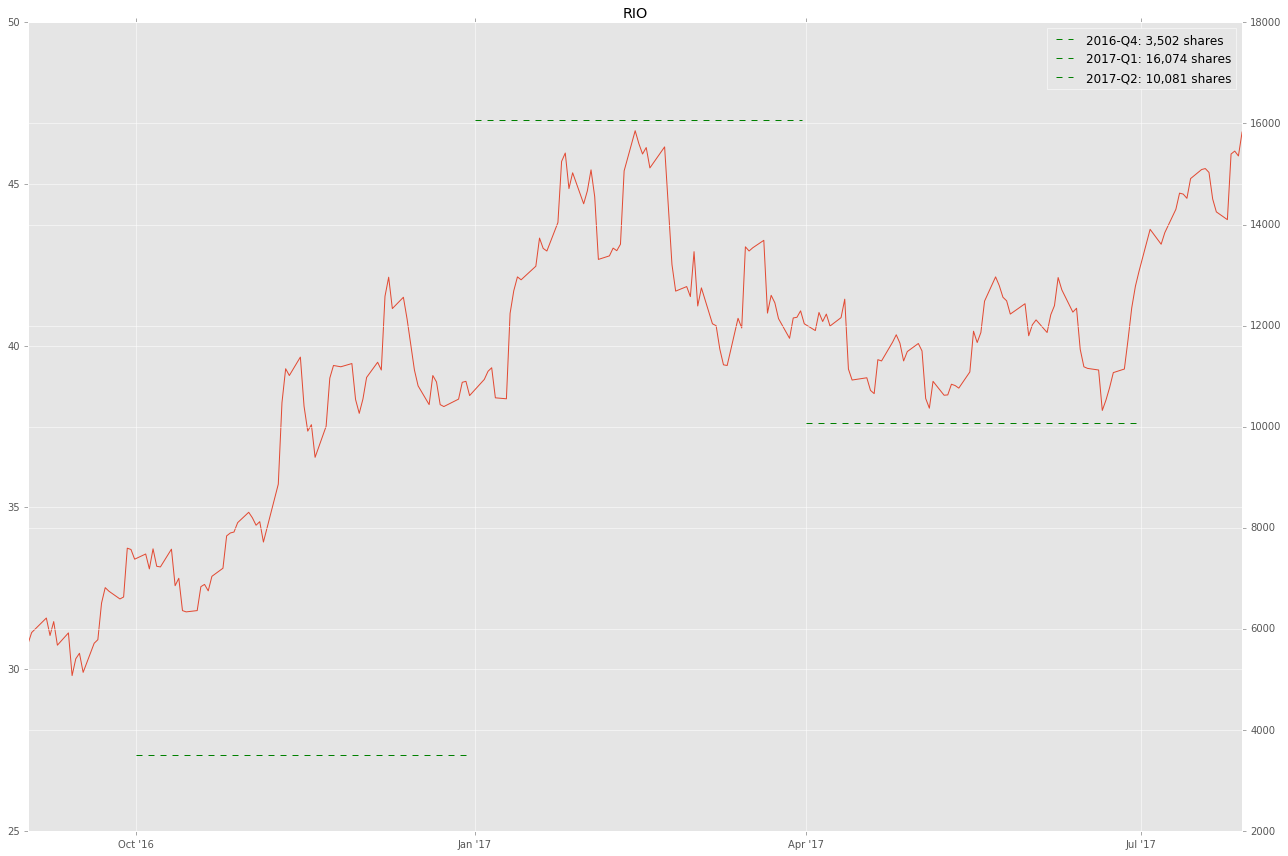

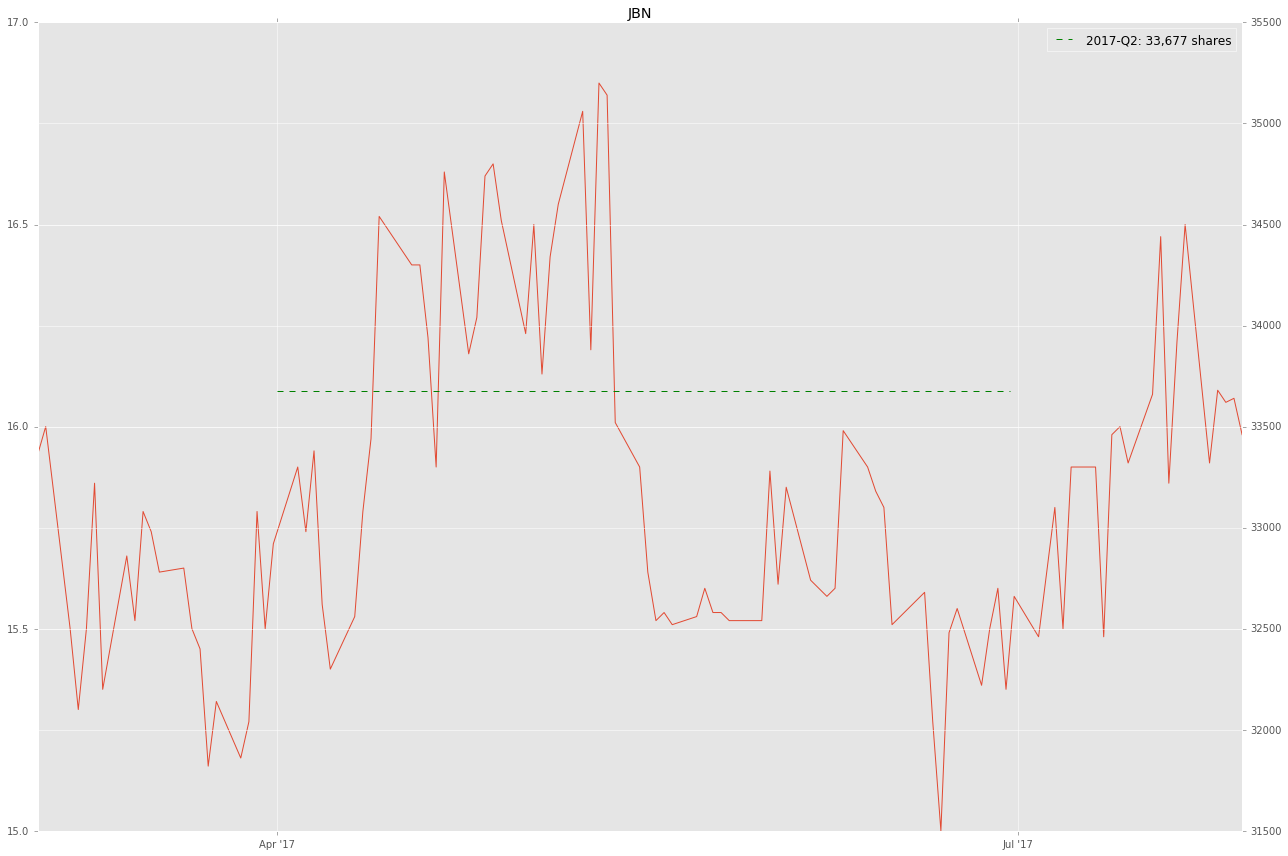

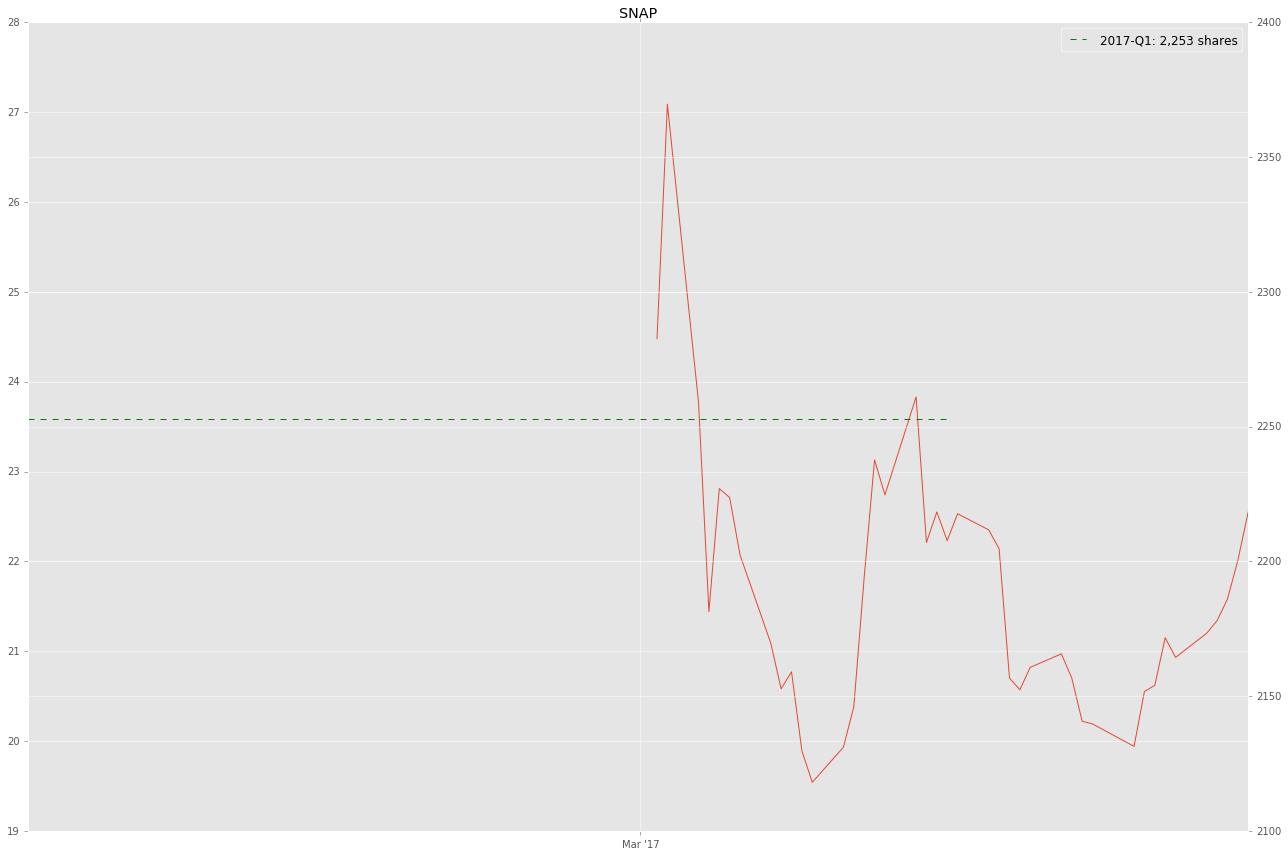

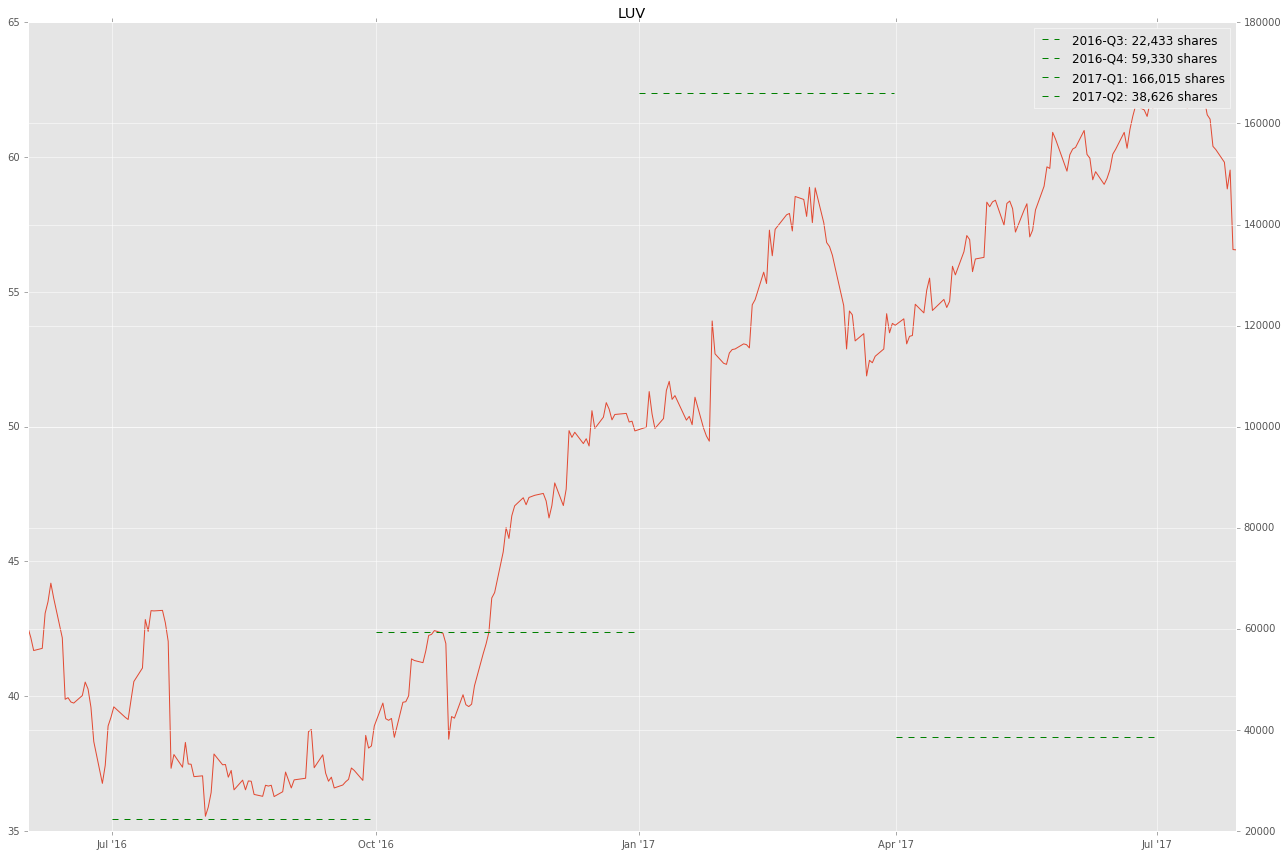

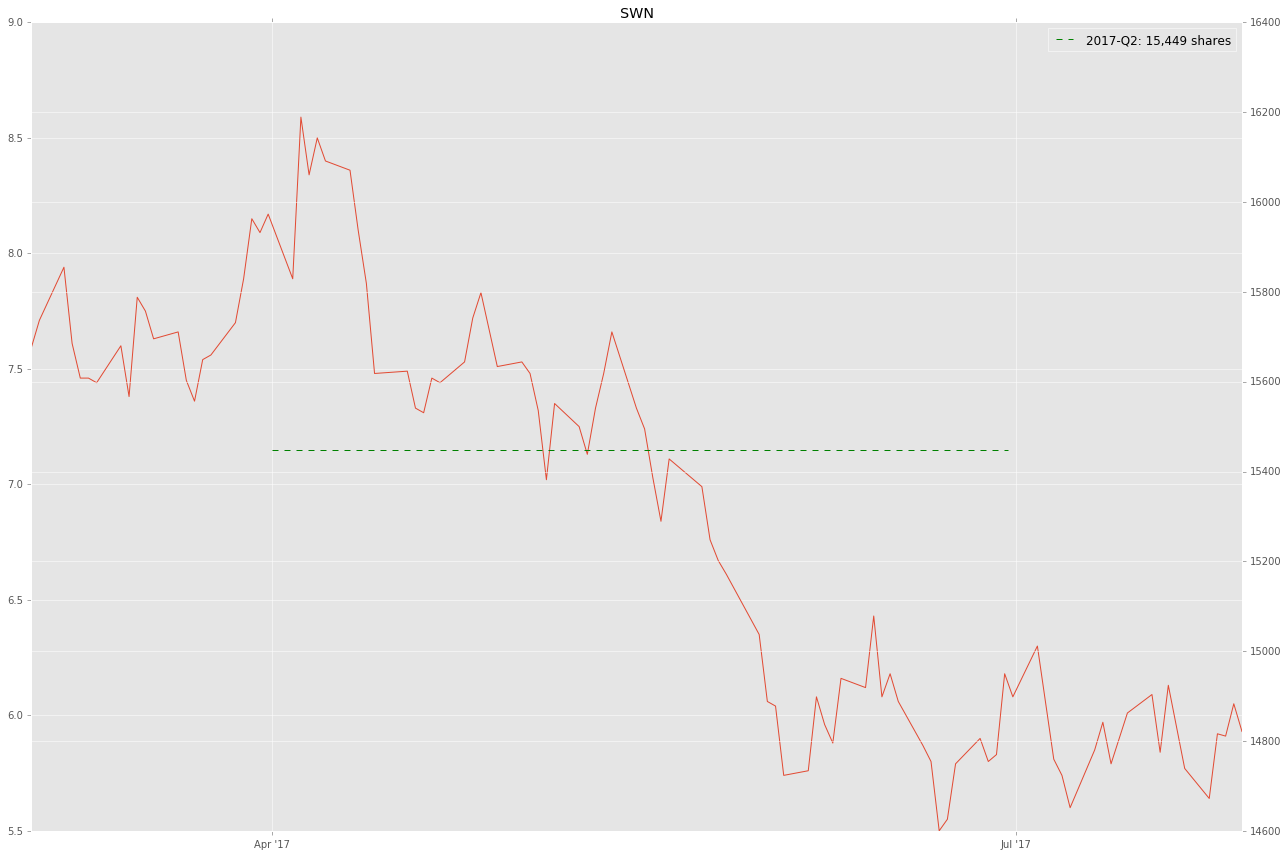

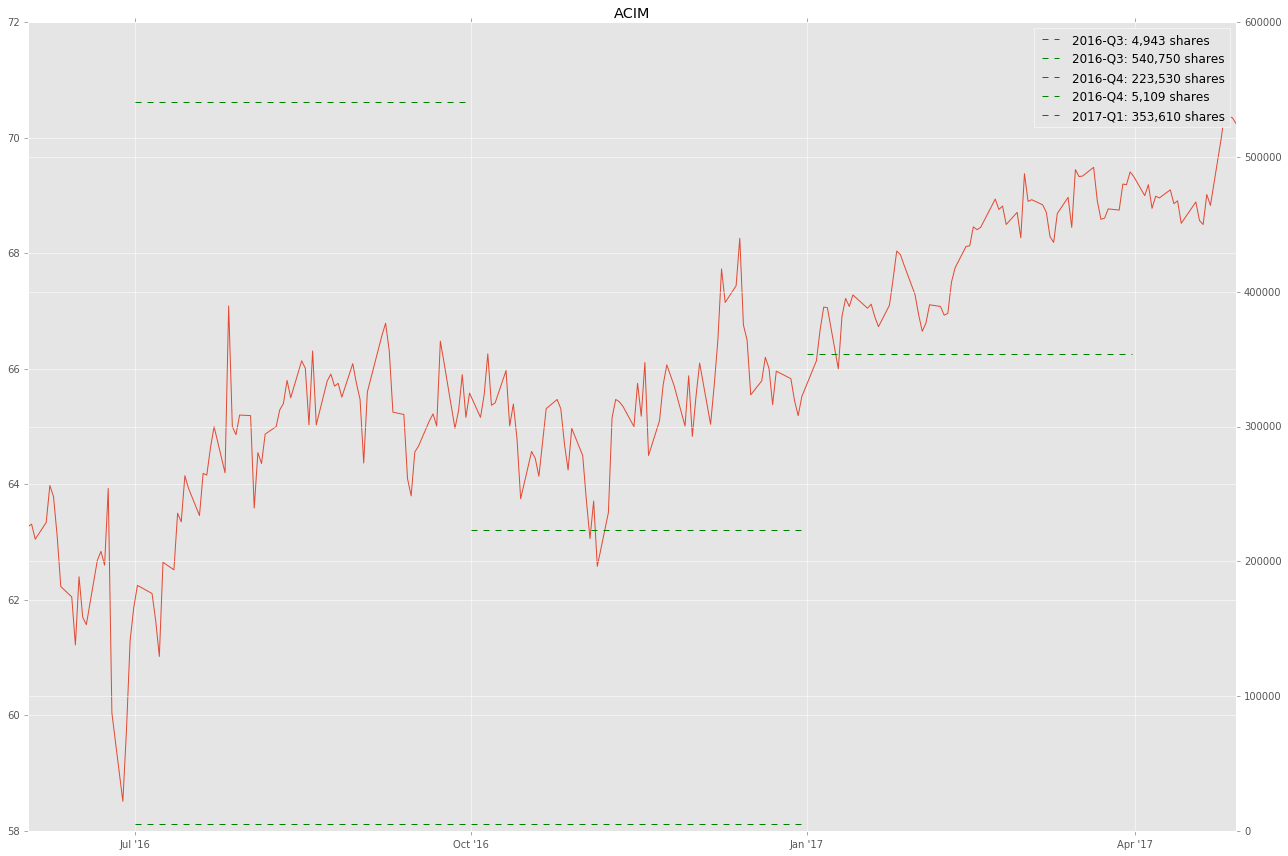

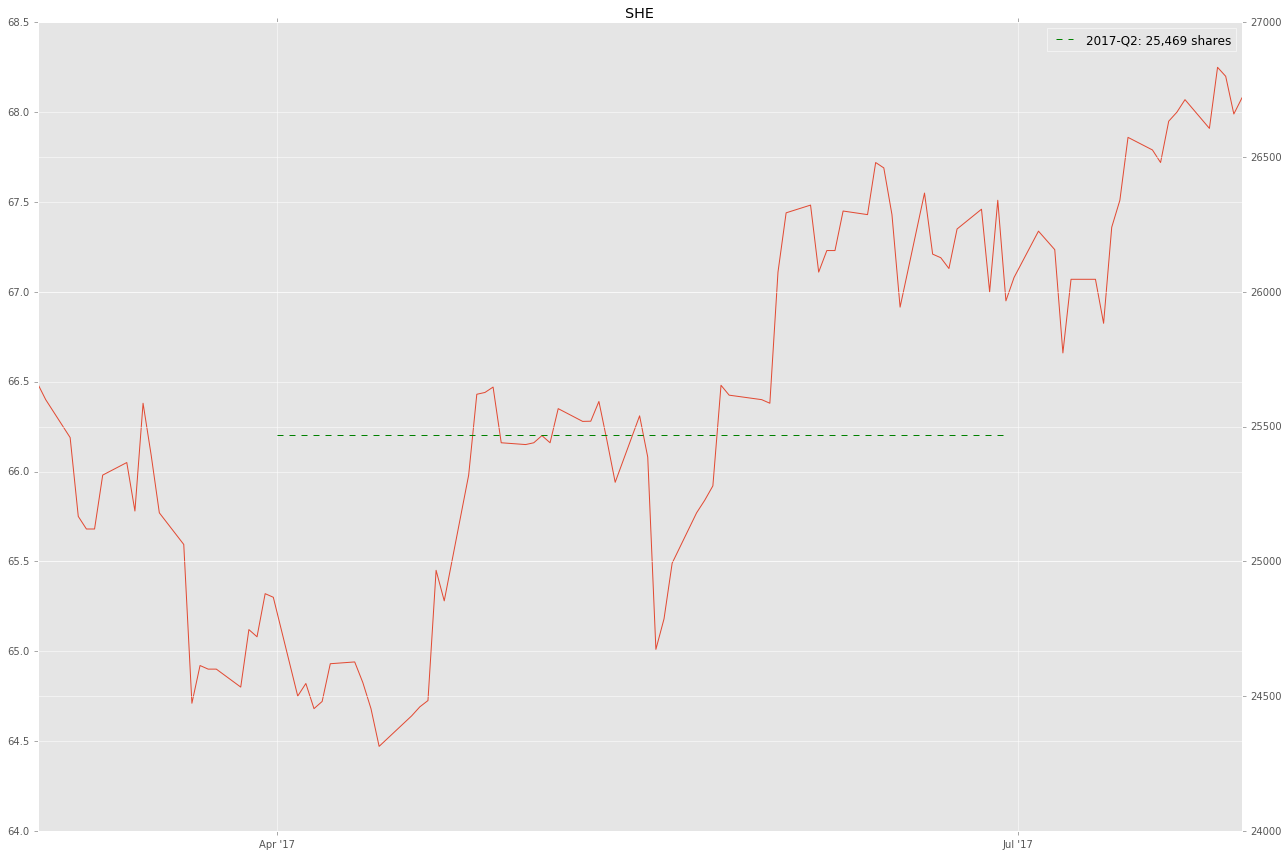

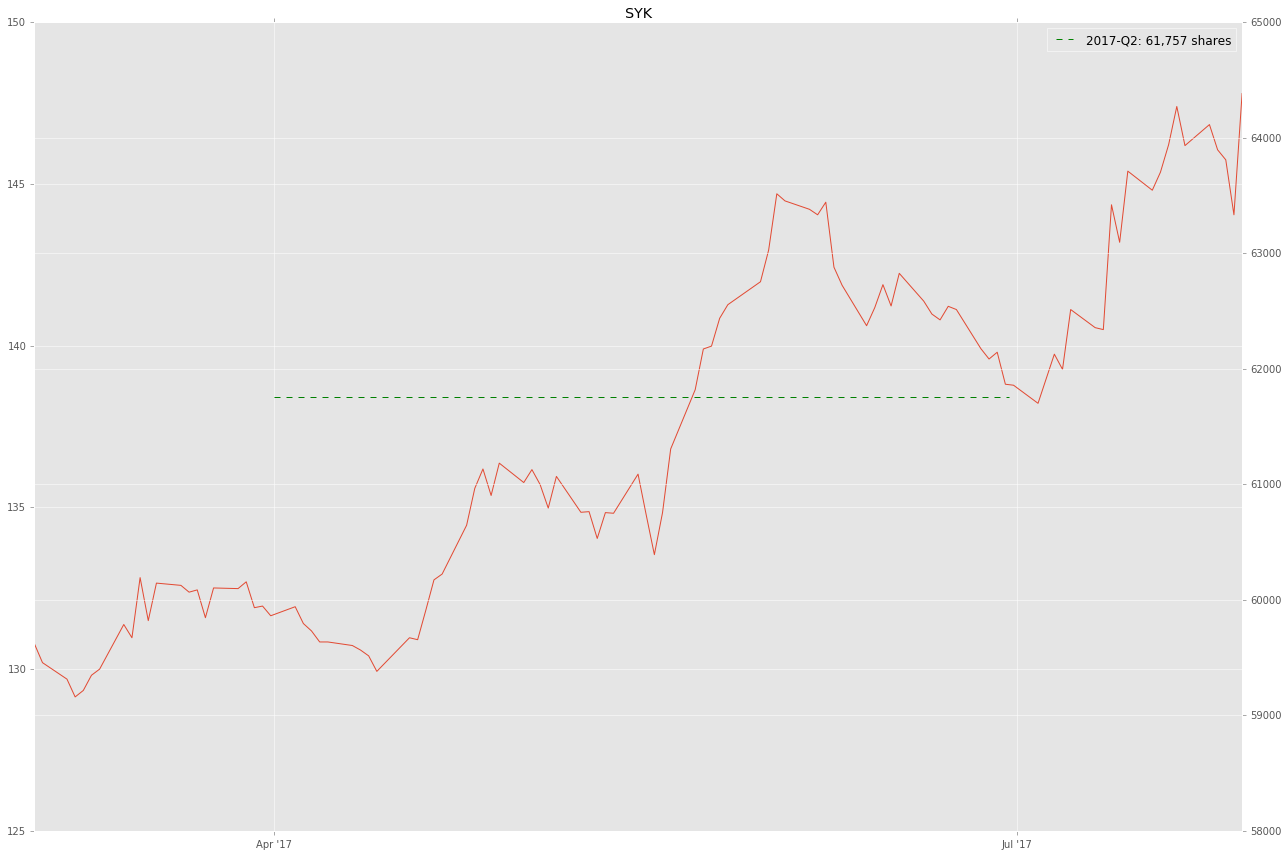

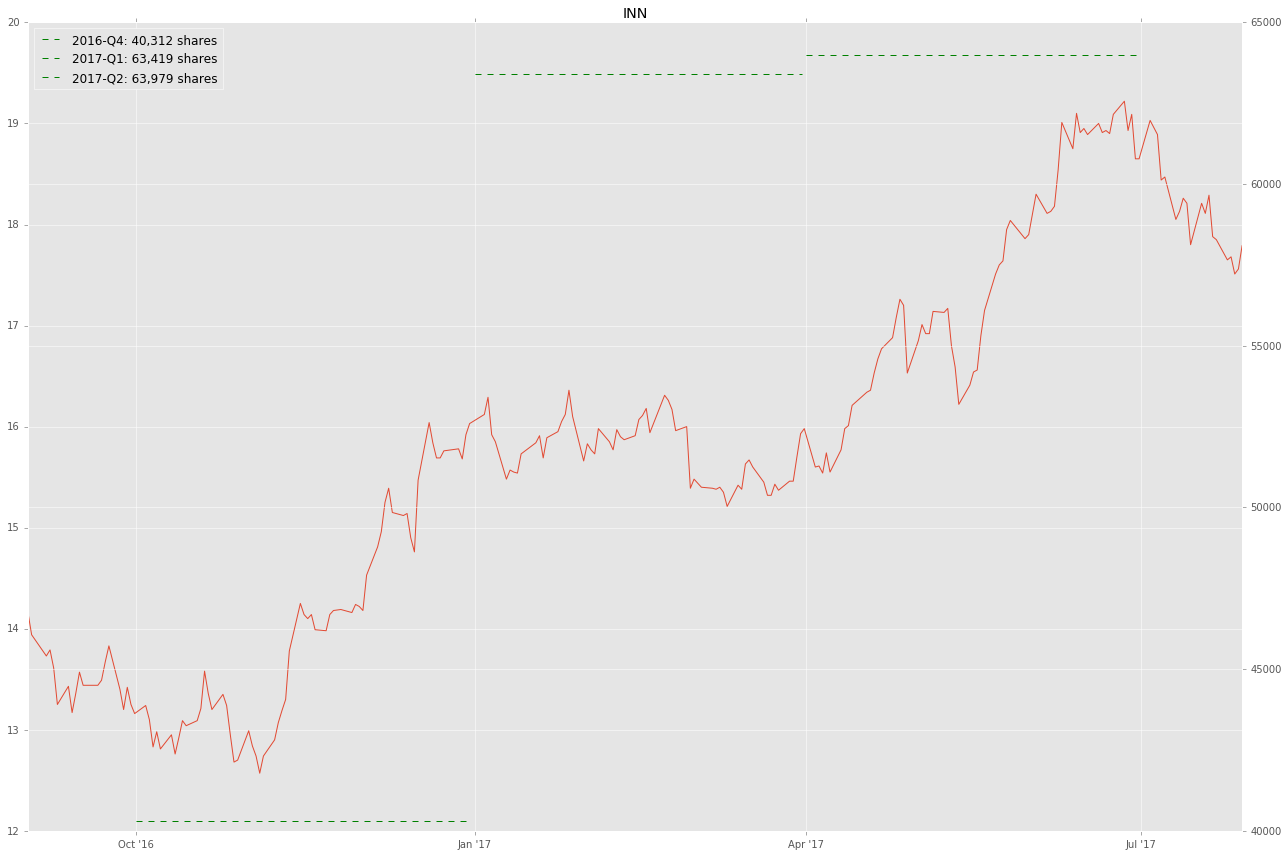

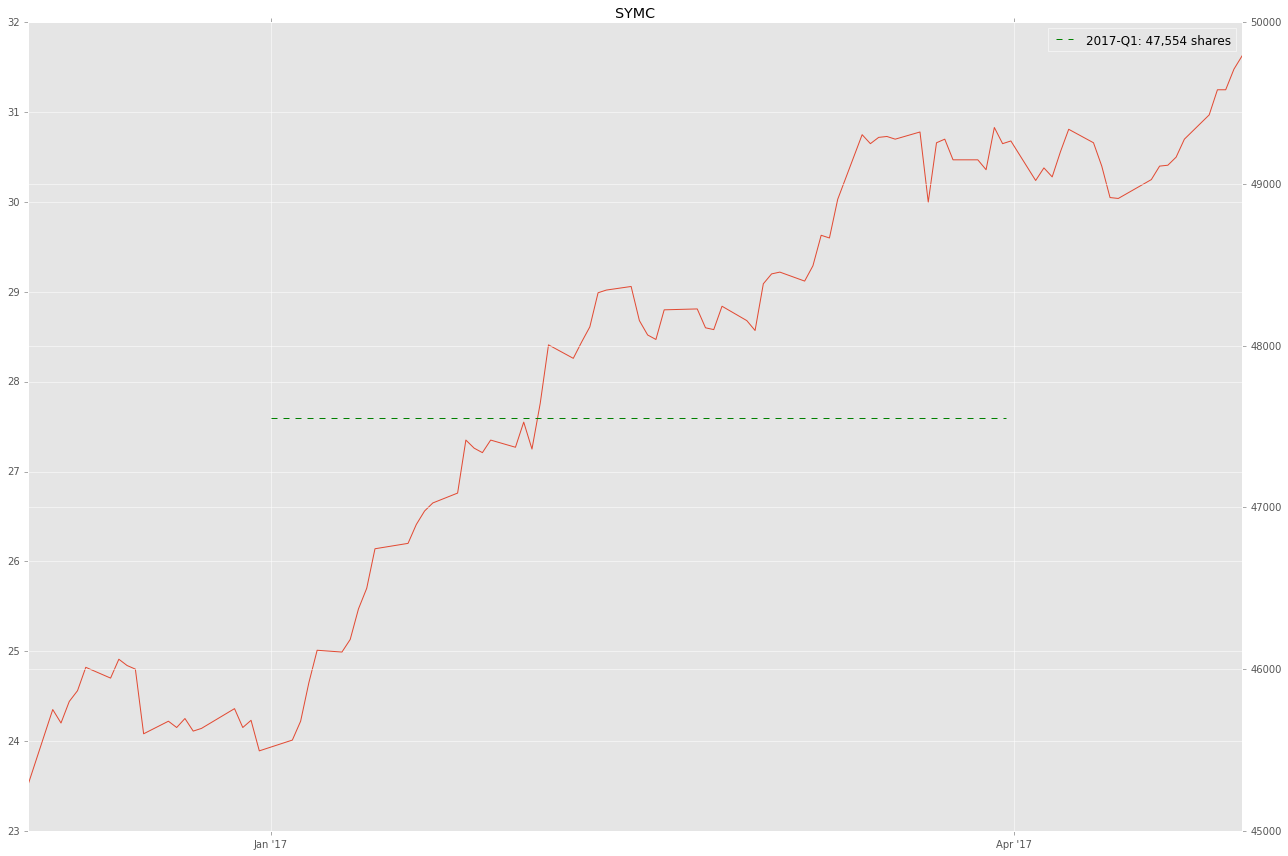

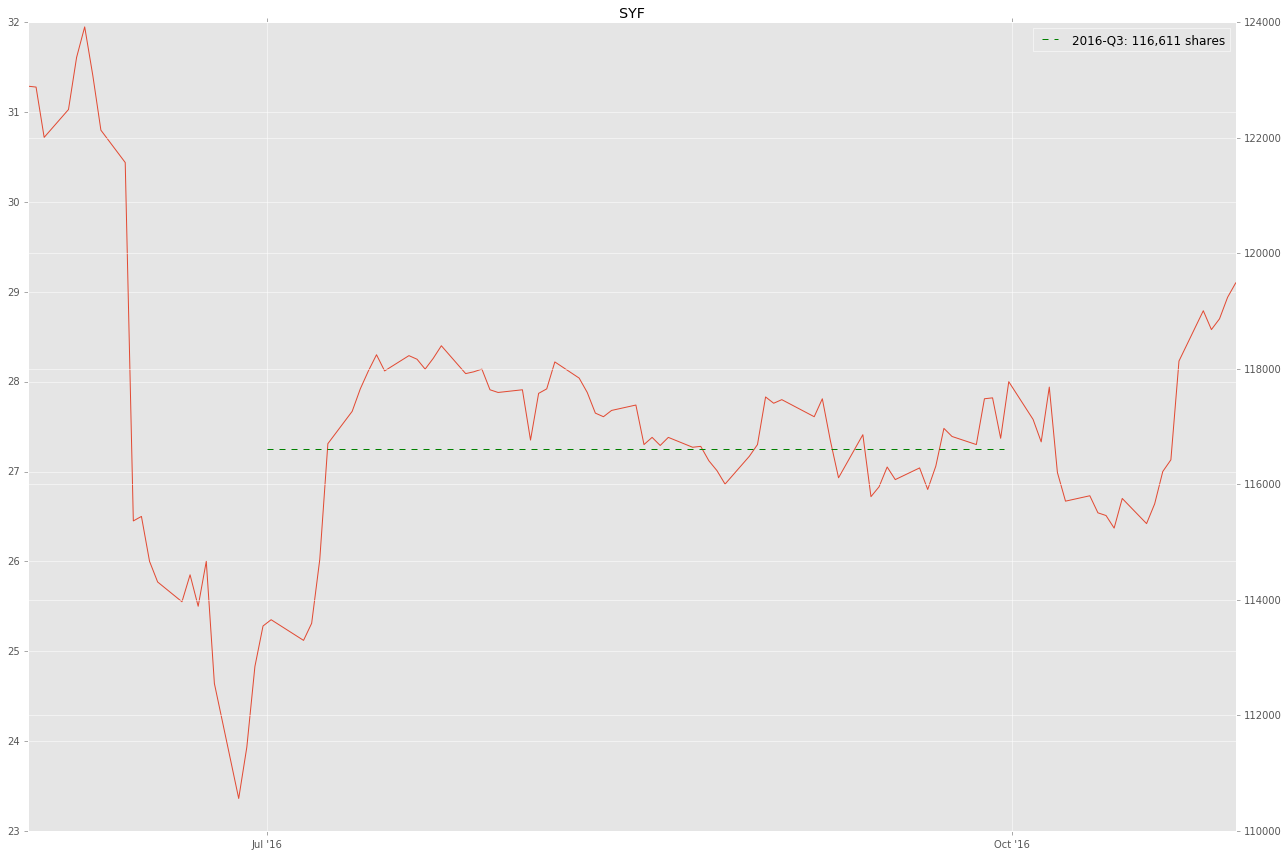

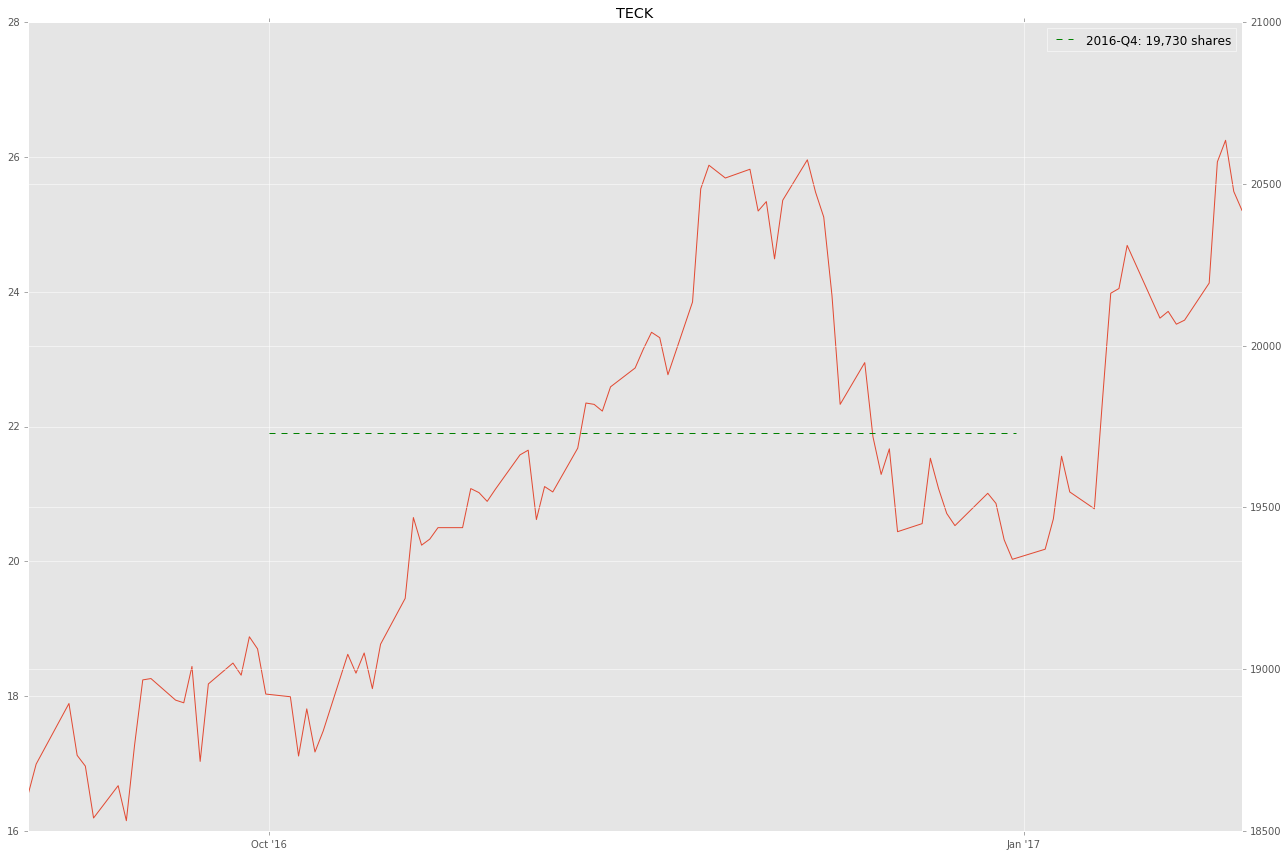

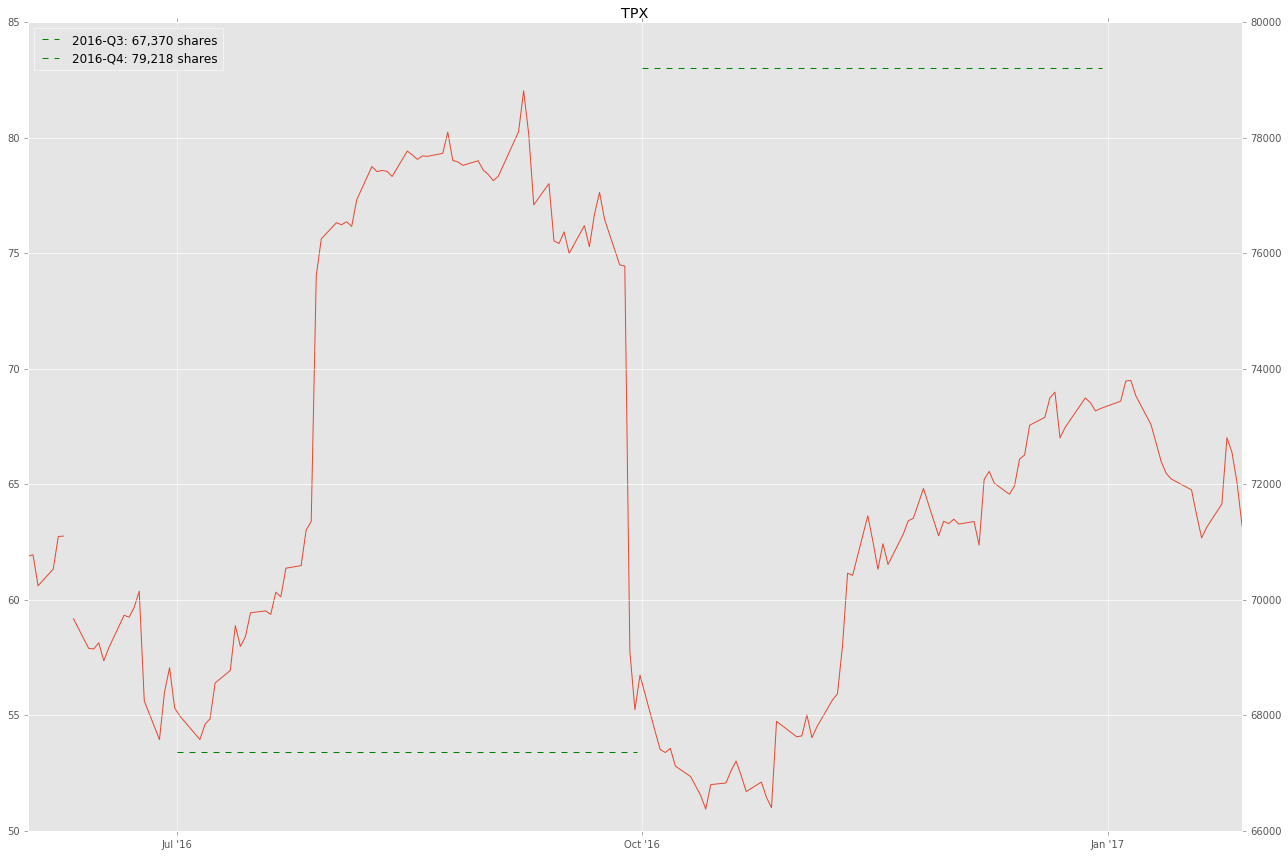

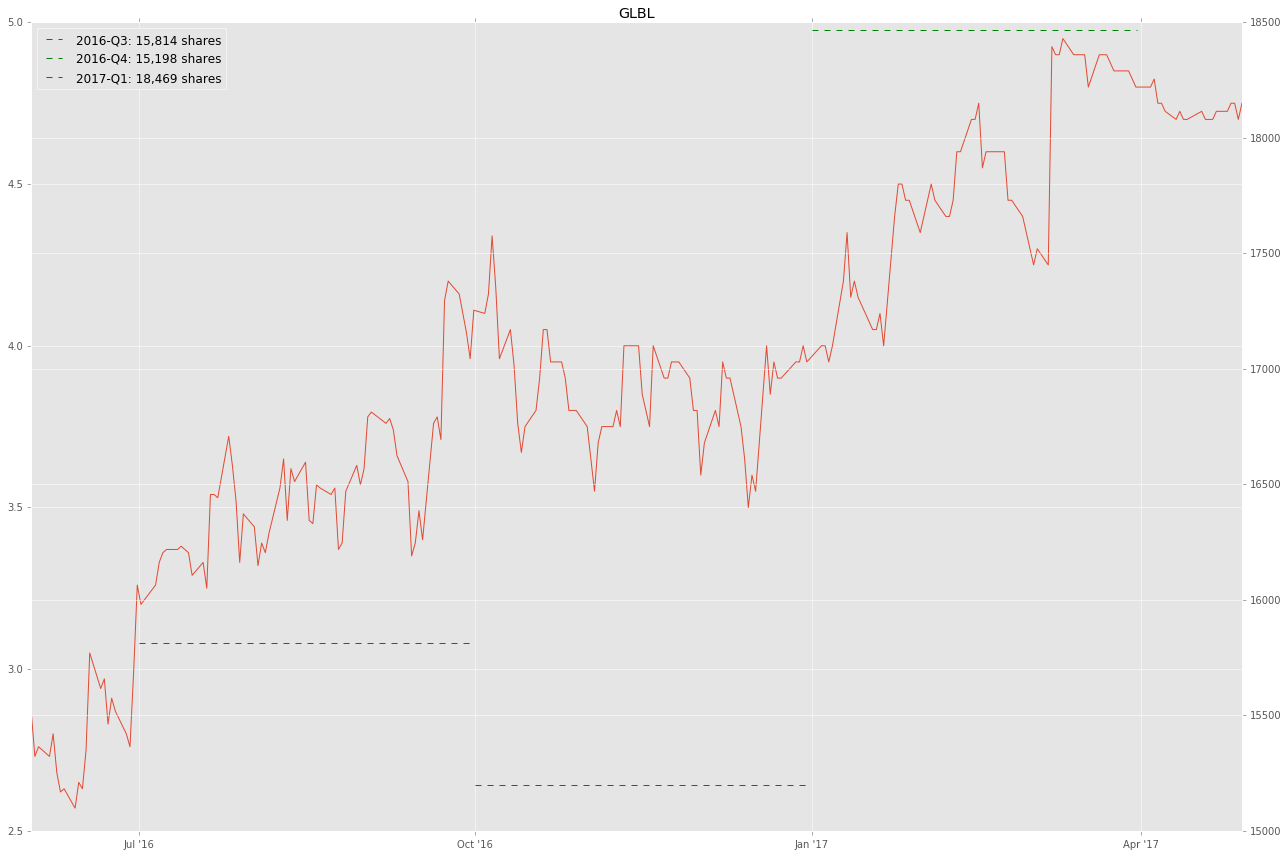

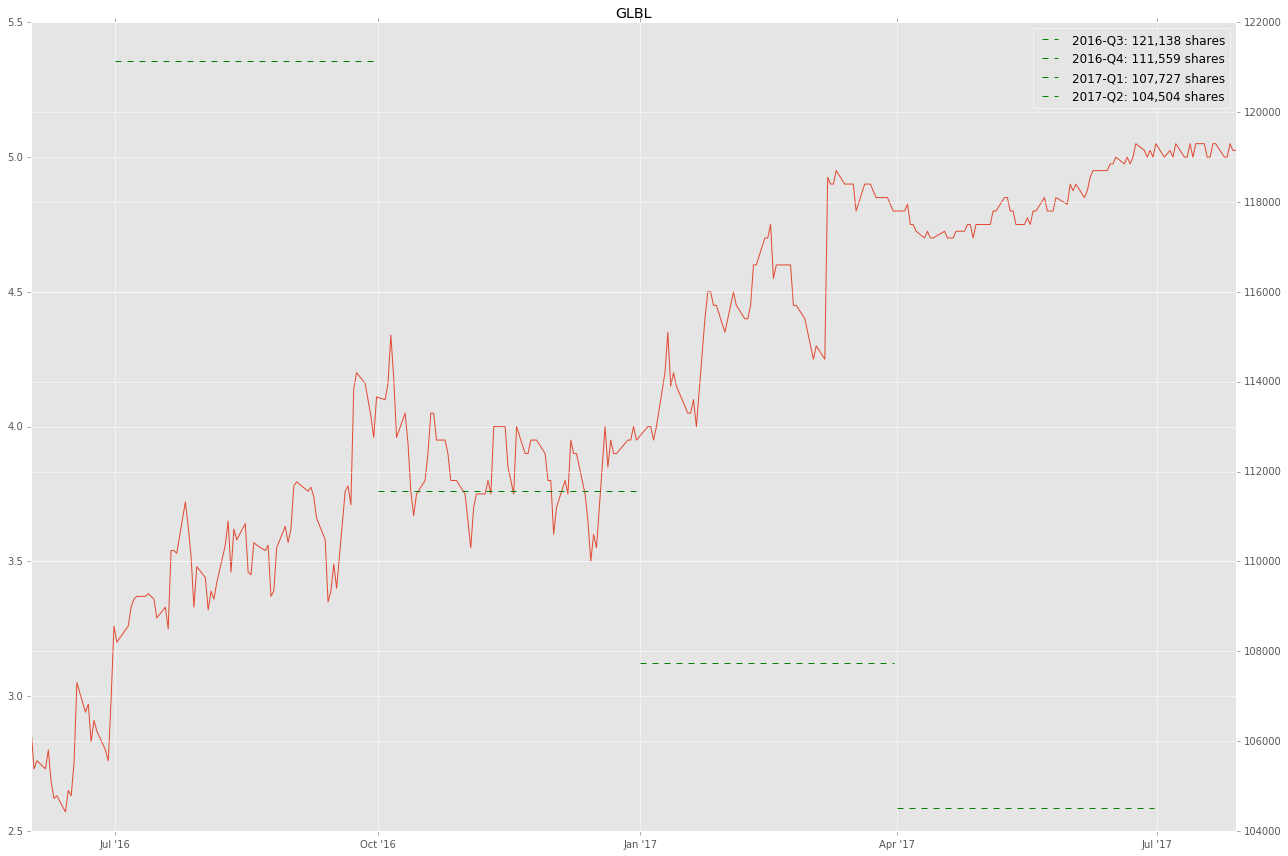

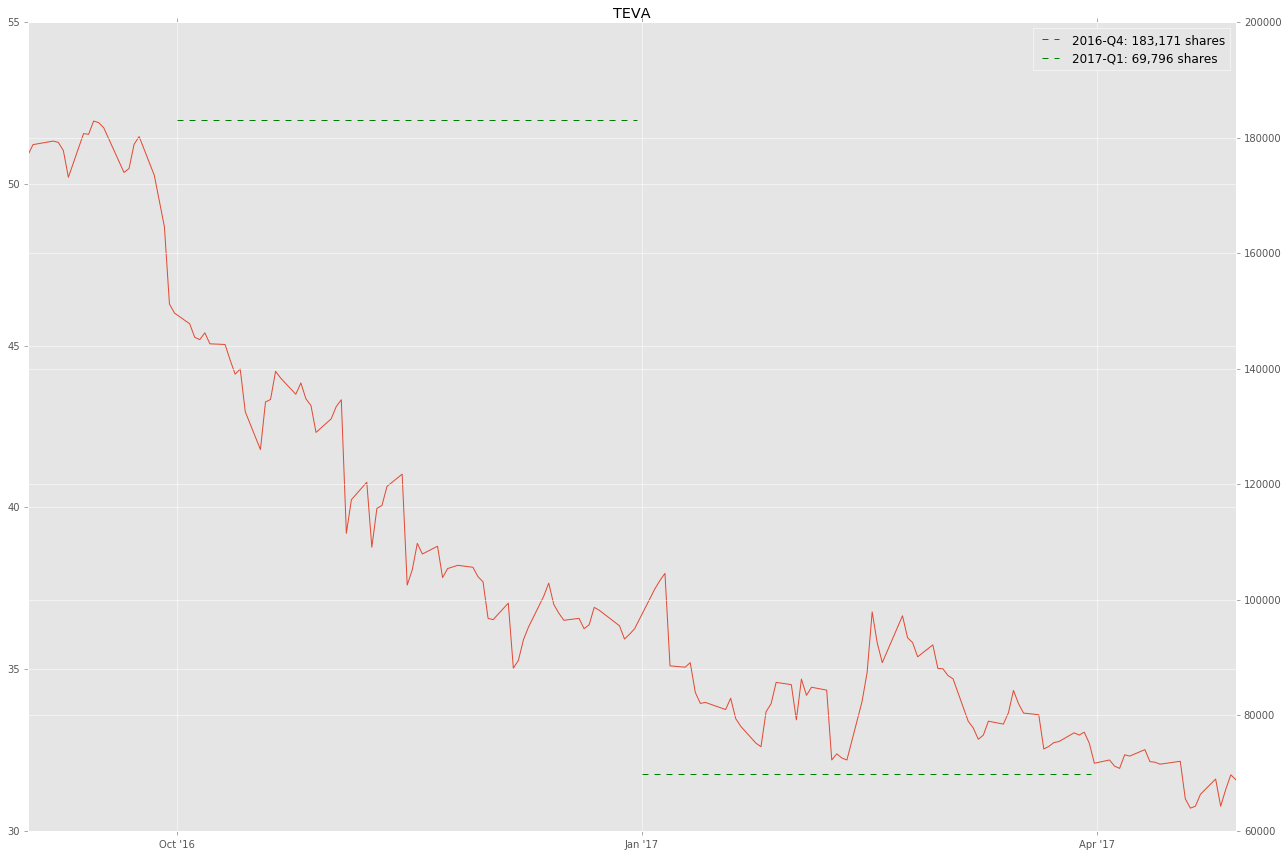

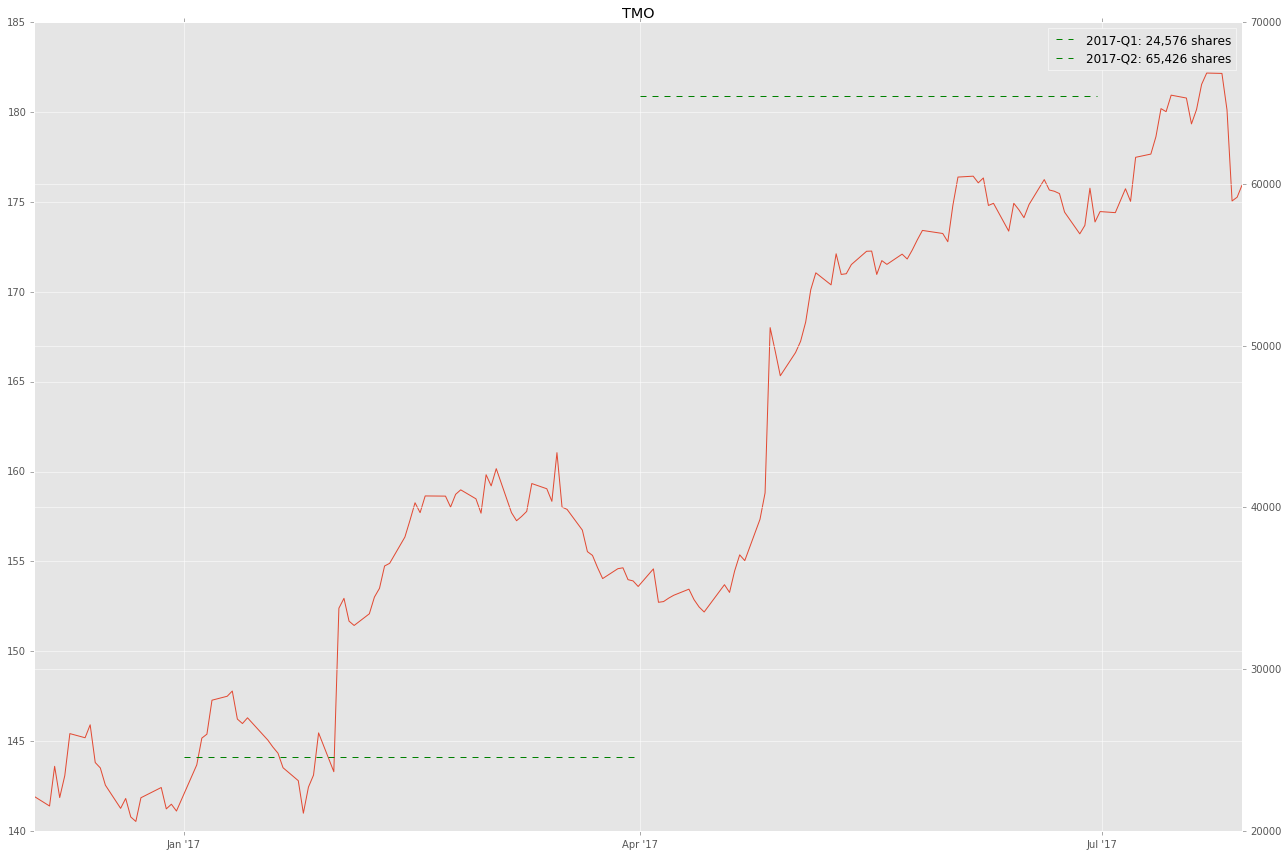

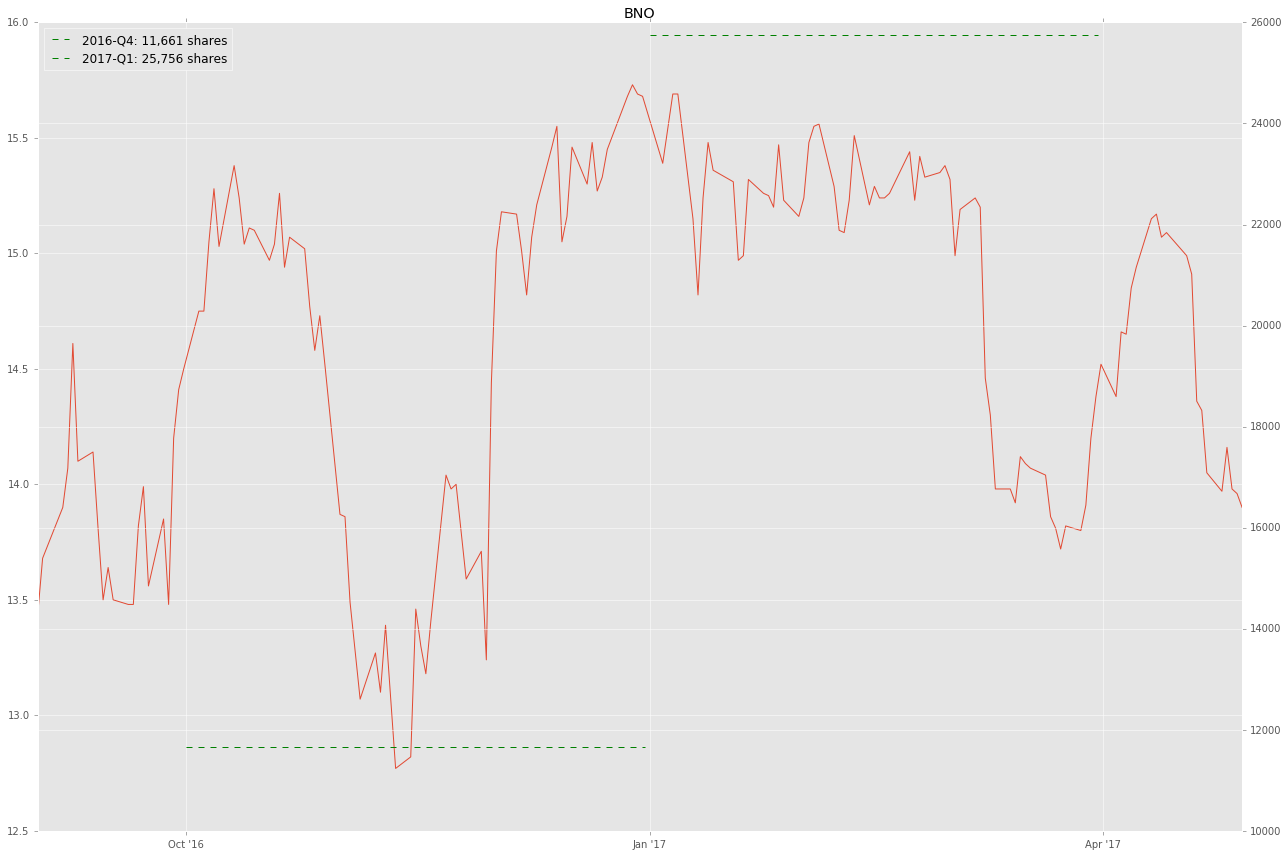

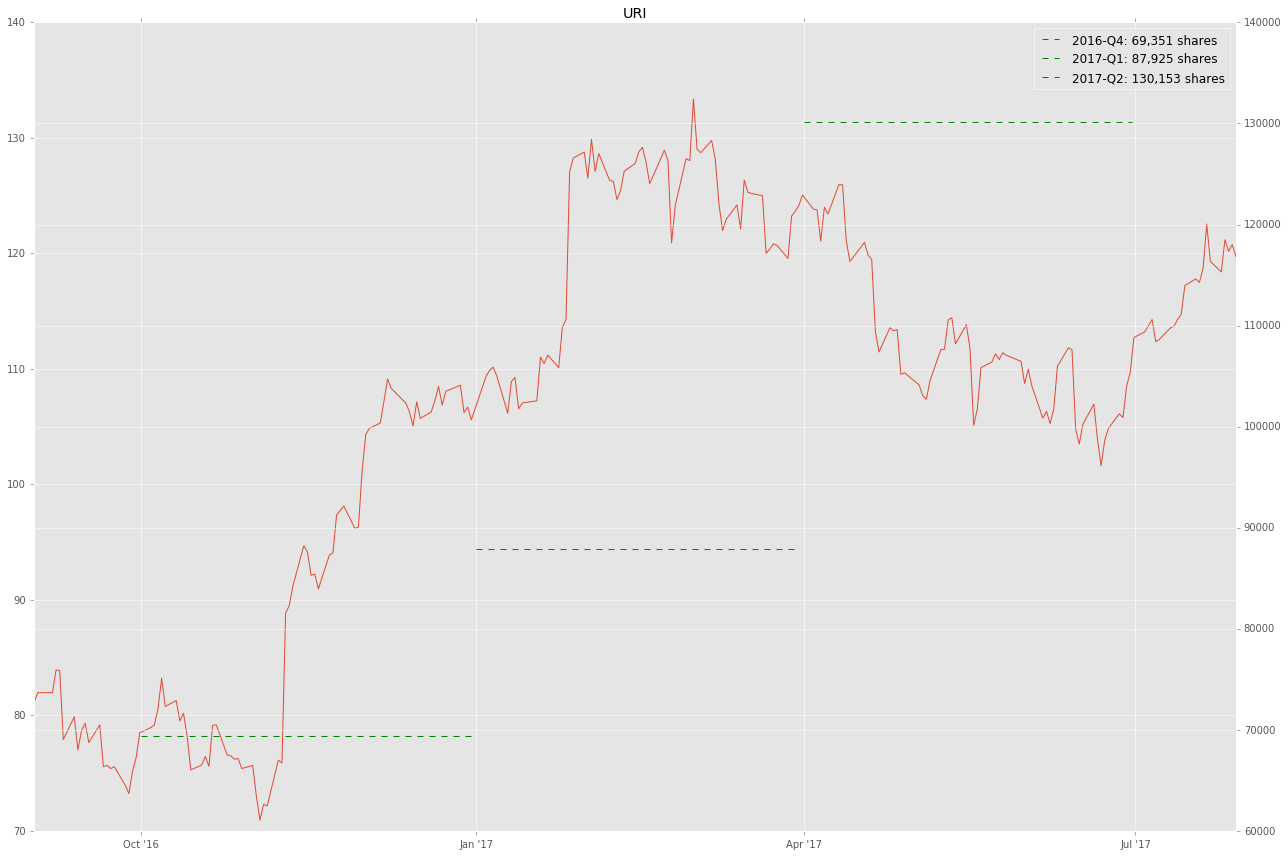

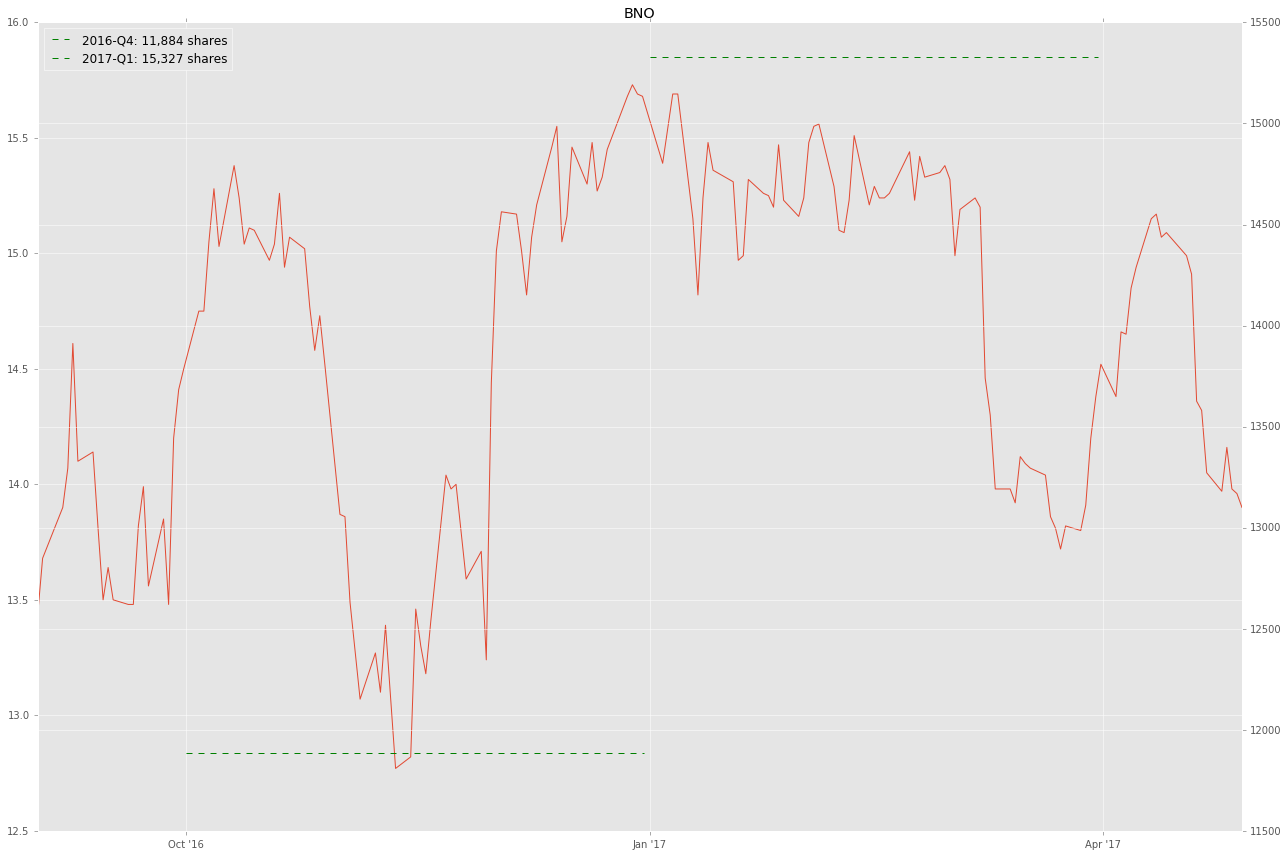

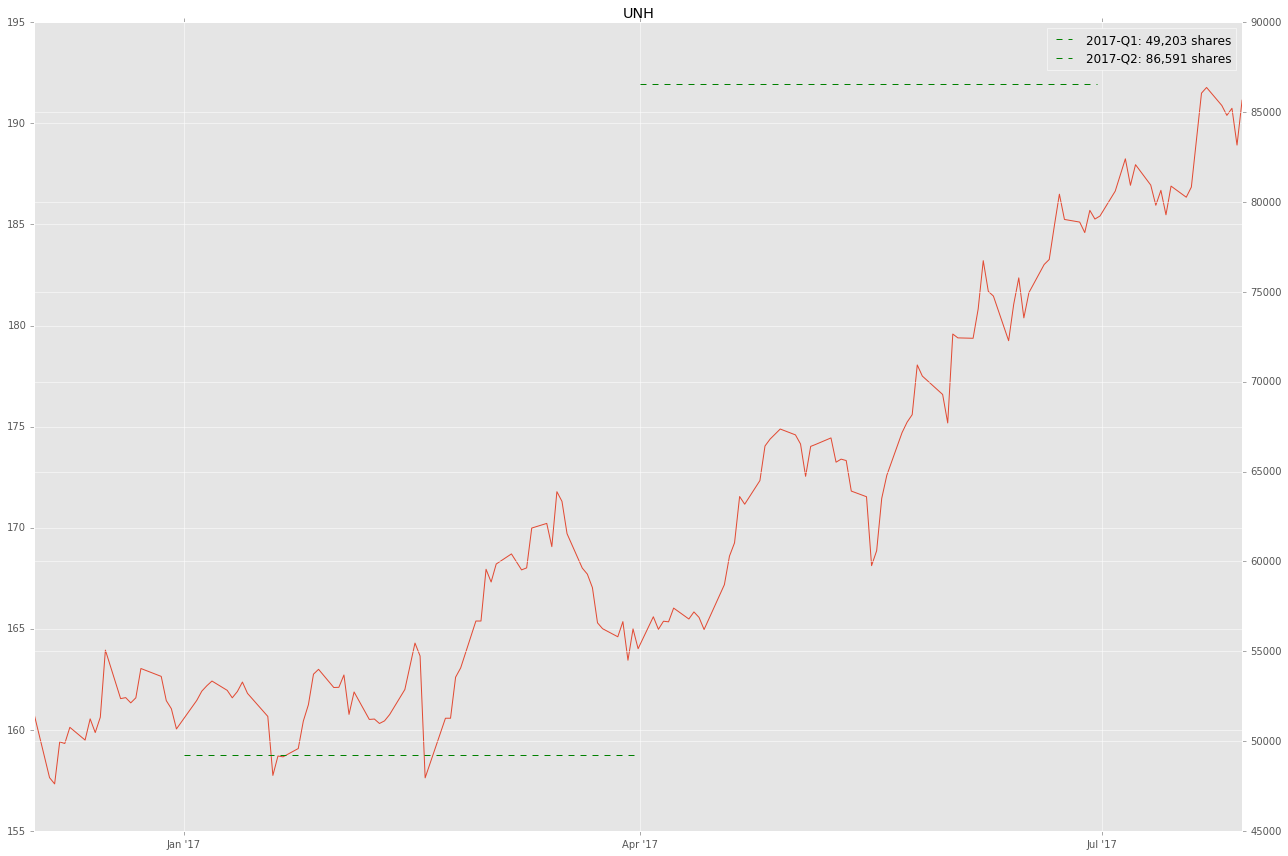

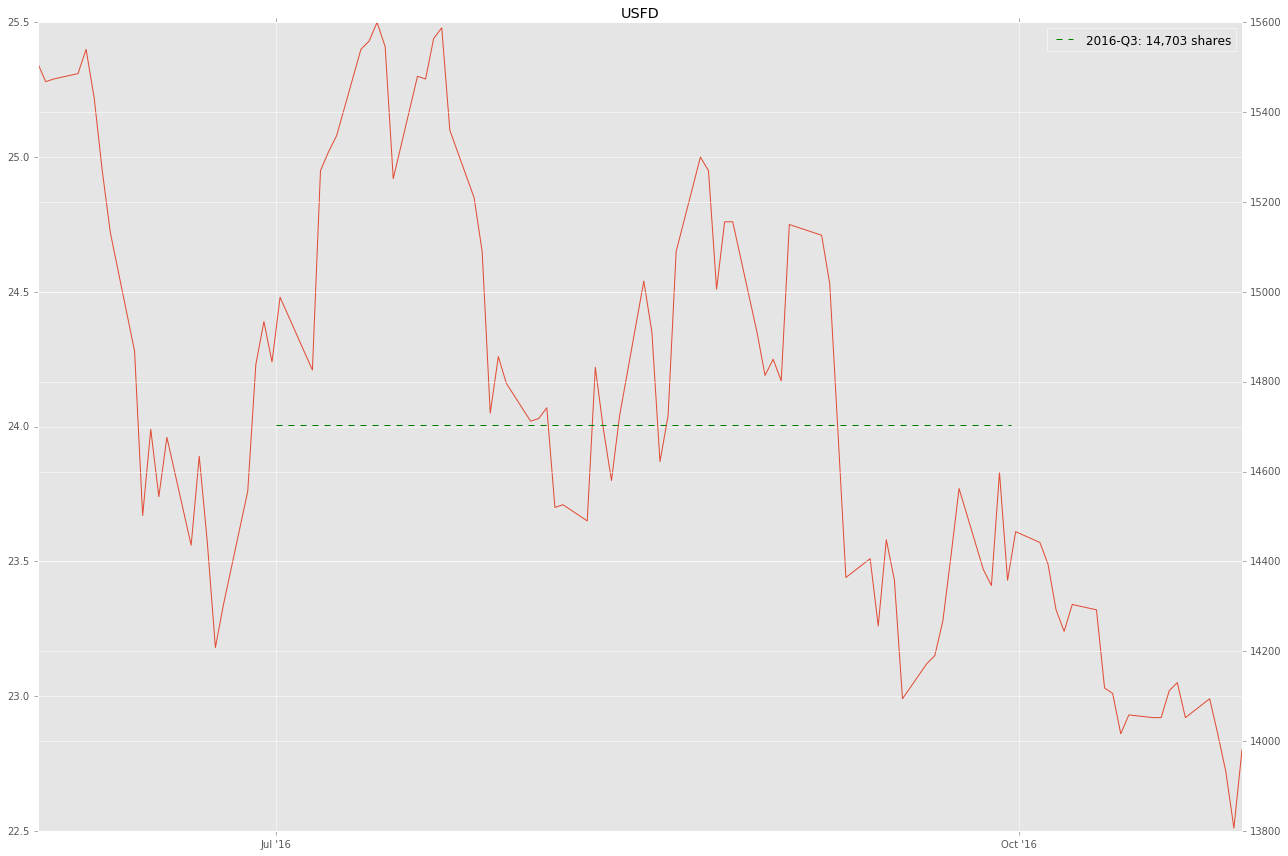

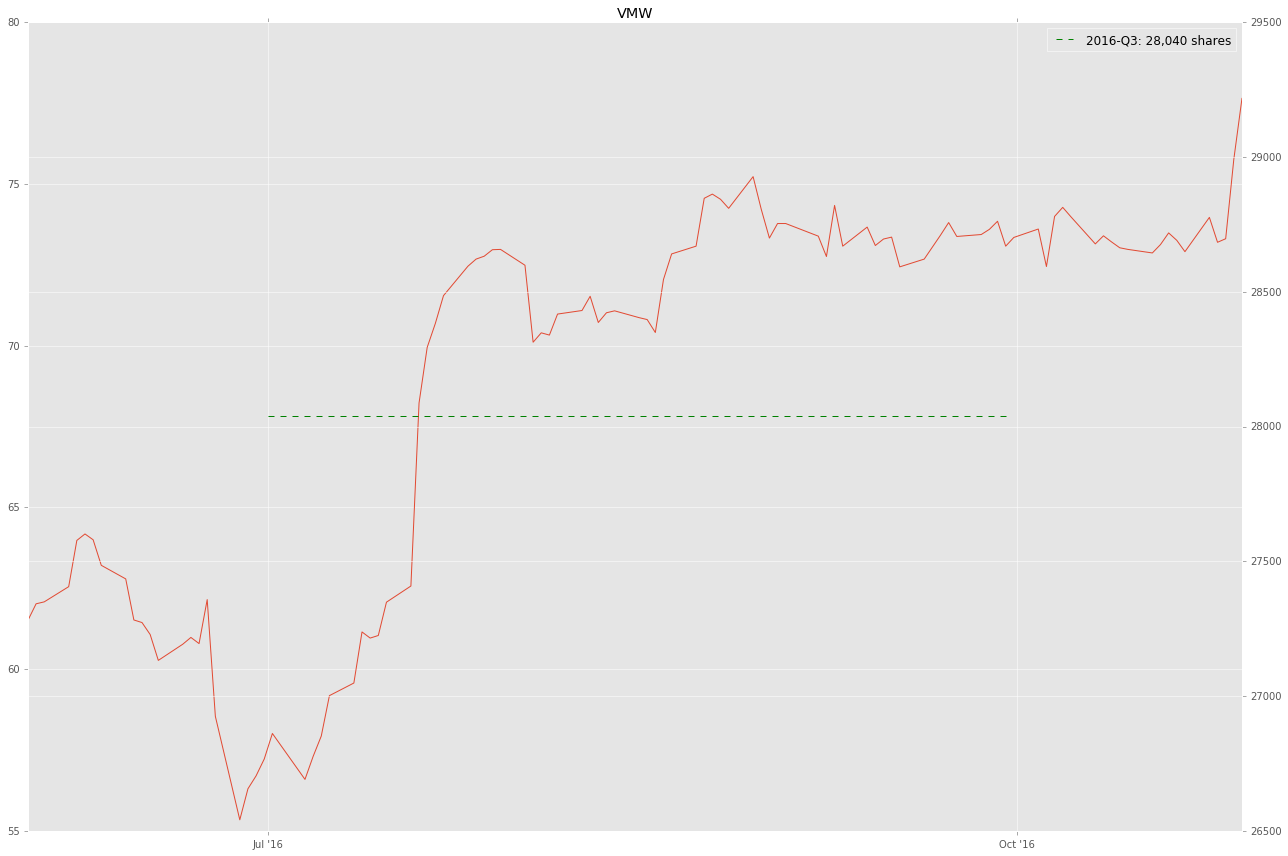

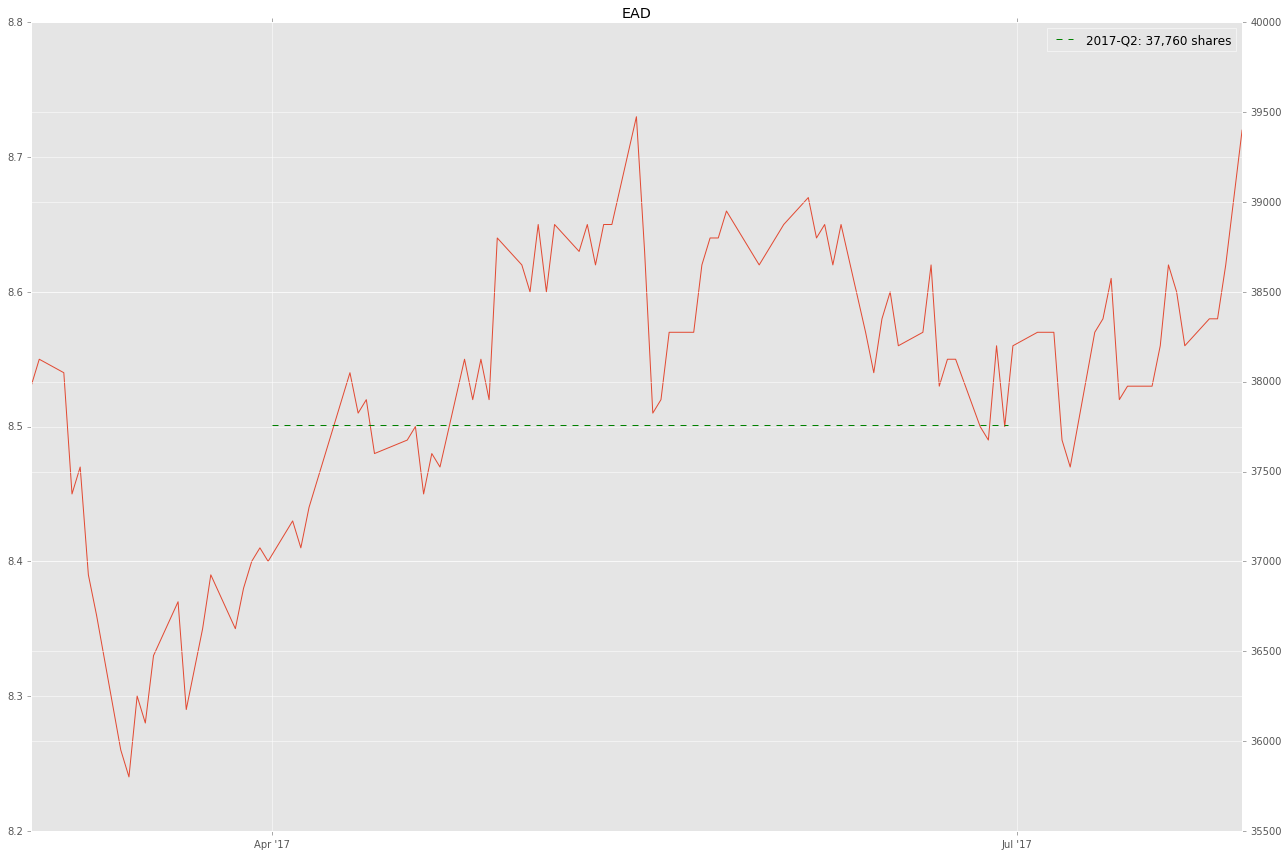

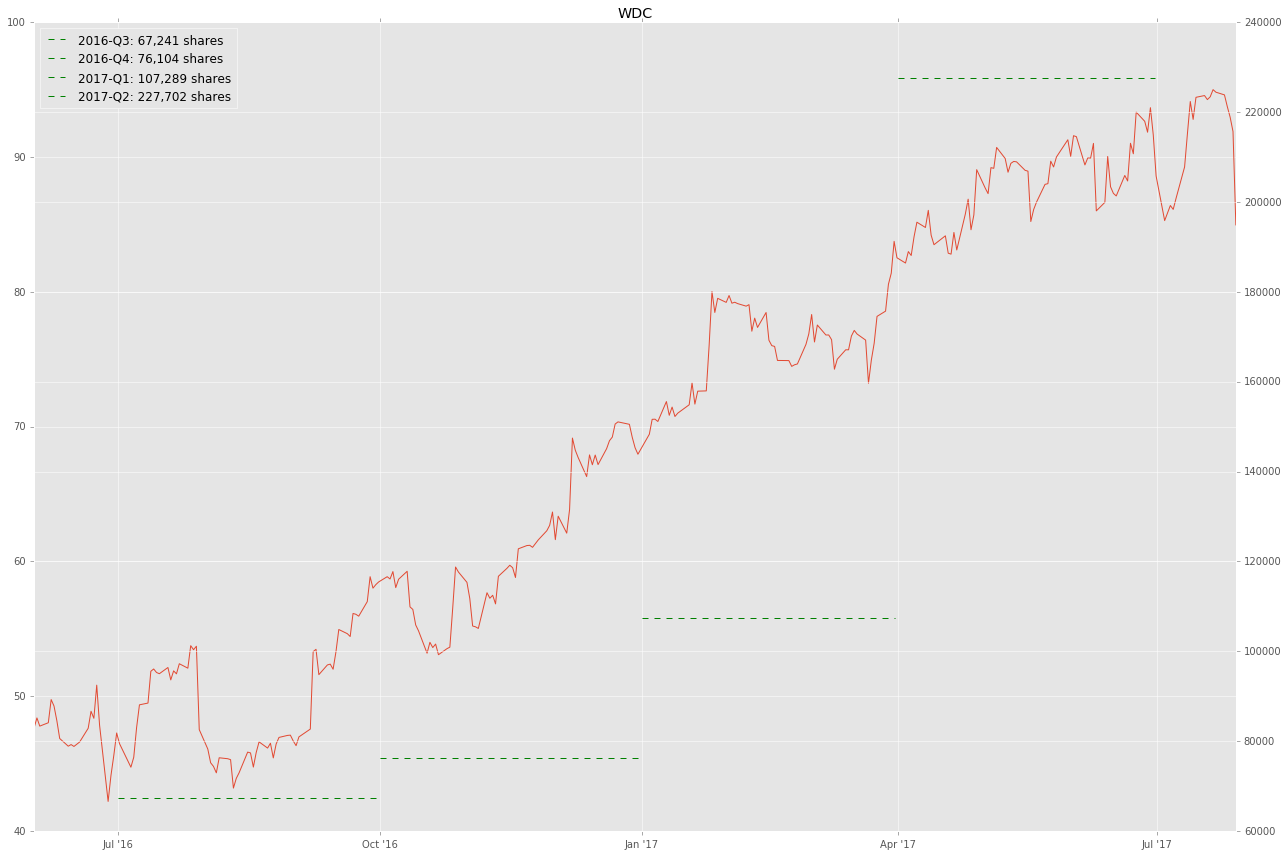

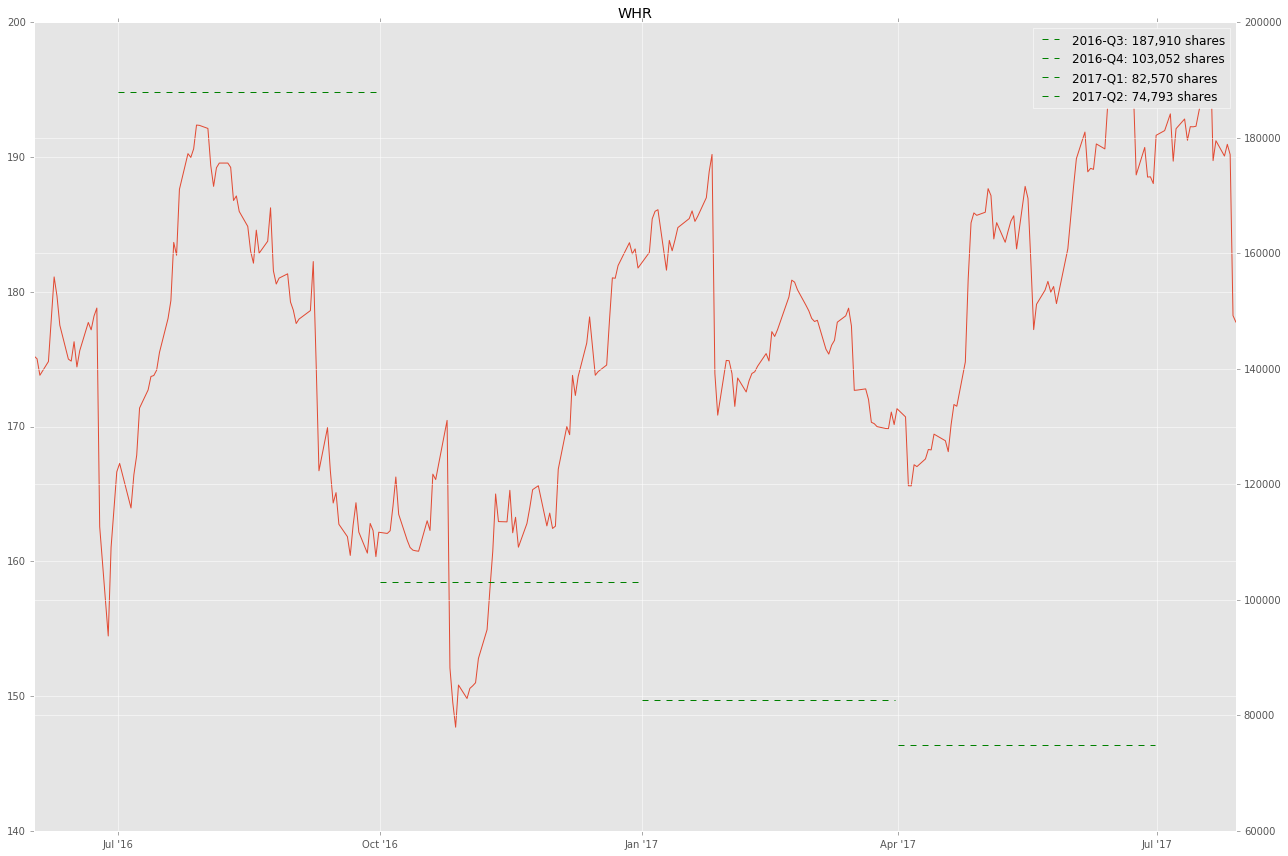

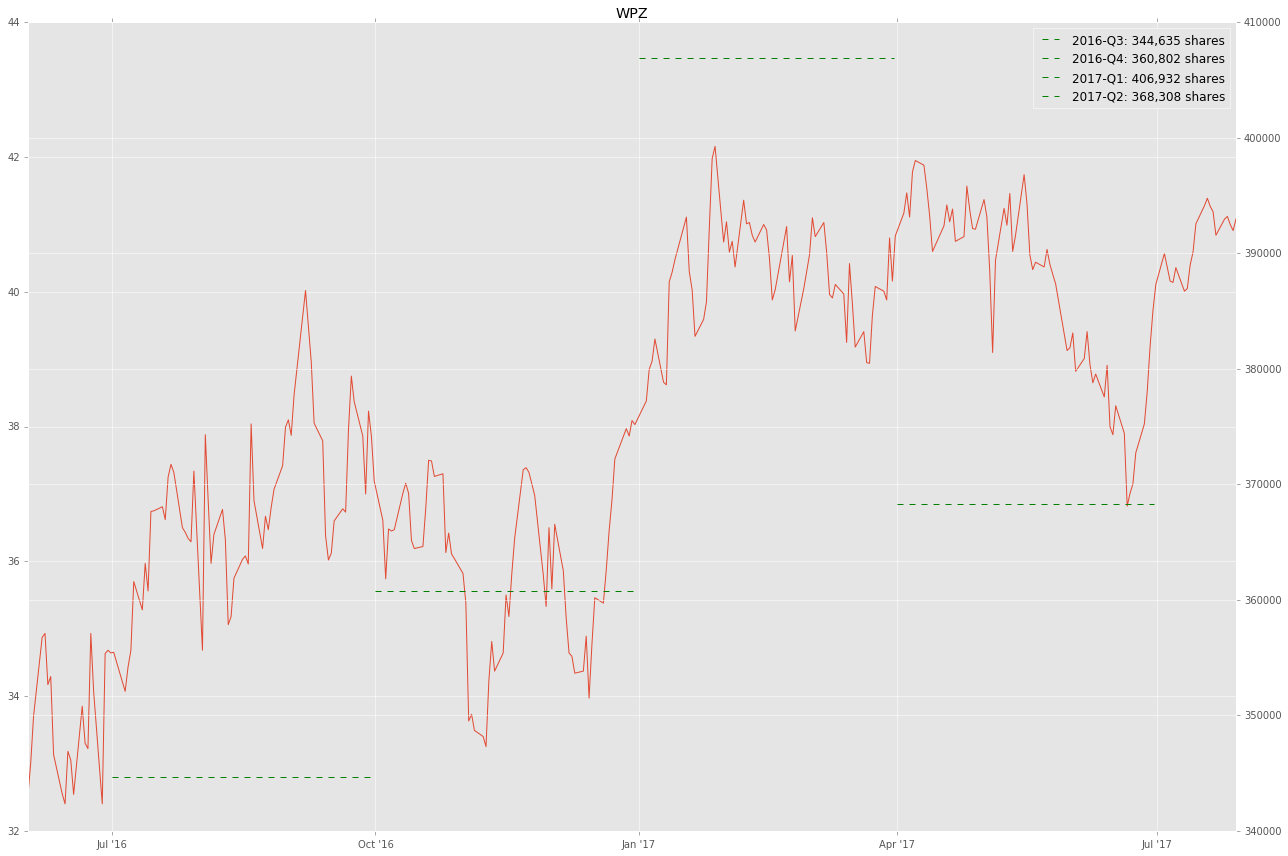

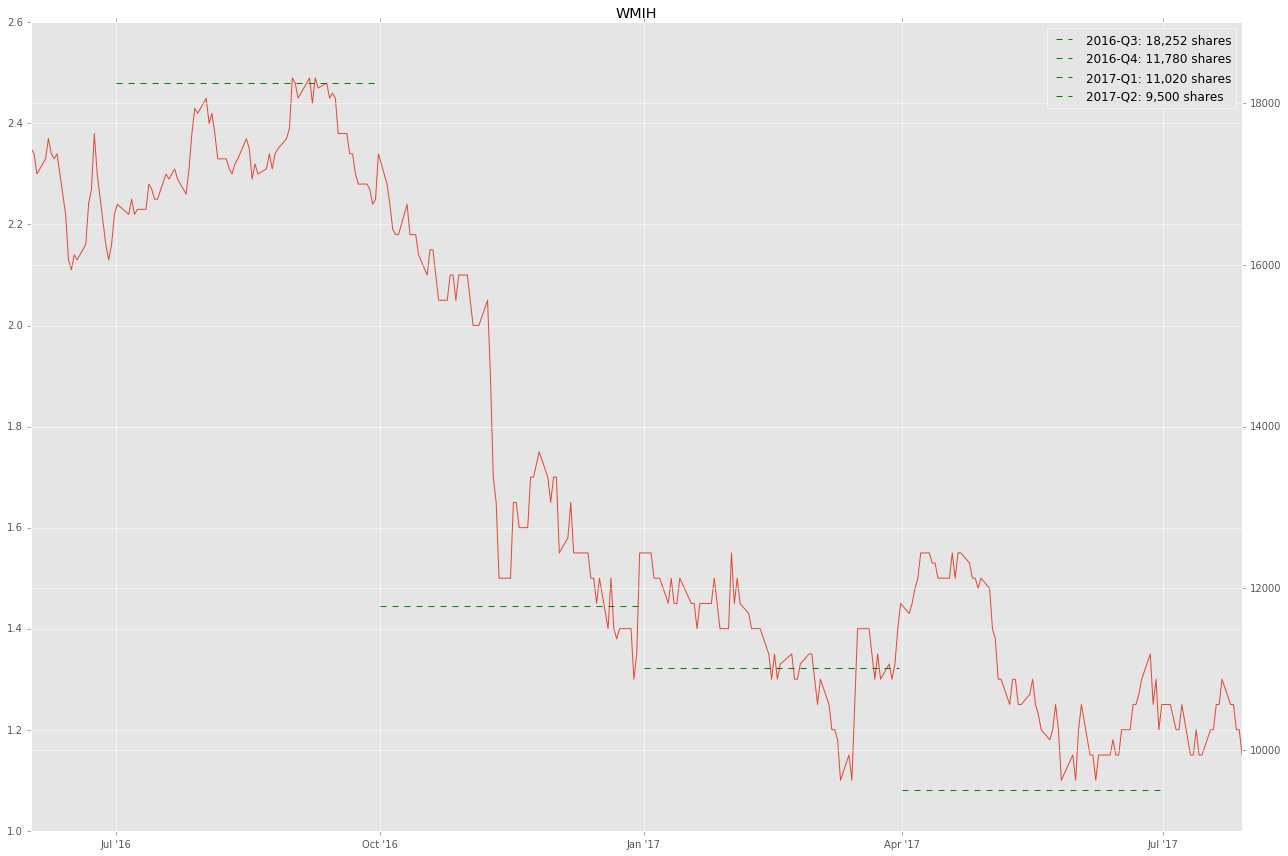

Symbol is undefined for 'YAHOO INC'


In [9]:
for name in shares.Name.unique():
    
    symbol = resolve_symbol(name)
    if symbol is None:
        print("Symbol is undefined for '{}'".format(name))
        continue
        
    shares_data = []
    for row in shares[shares.Name == name].itertuples():
        start = datetime.strptime(row.Date, DATE_FM)
        start = start.replace(month=start.month - 2, day=1)
        shares_data.append(
            (start, datetime.strptime(row.Date, DATE_FM), int(row.Value))
        )
    
    min_start = min(e[0] for e in shares_data)
    max_end = max(e[1] for e in shares_data)
    
    price_data = get_price_data(symbol, min_start - timedelta(days=30), max_end + timedelta(days=30))
    if price_data is None:
        continue
        
    plot_data(symbol, price_data, shares_data)